# Install and import necessary libraries

In [ ]:
pip install requests

In [ ]:
!pip install virtualenv
!virtualenv <your-env>
!<your-env>\Scripts\activate
!<your-env>\Scripts\pip.exe install traveltimepy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.9/468.9 kB 24.1 MB/s eta 0:00:00
/bin/bash: -c: line 1: syntax error near unexpected token `newline'
/bin/bash: -c: line 1: `virtualenv <your-env>'
/bin/bash: line 1: your-env: No such file or directory
/bin/bash: line 1: your-env: No such file or directory


In [ ]:
pip install traveltimepy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.8/409.8 kB 33.4 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of geojson-pydantic to determine which version is compatible with other requirements. This could take a while.
  Attempting uninstall: pydantic
    Found existing installation: pydantic 2.2.1
    Uninstalling pydantic-2.2.1:
      Successfully uninstalled pydantic-2.2.1
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.14.0 requires protobuf<4.21,>=3.20.3, but you have protobuf 4.21.12 which is incompatible.


In [ ]:
pip install nest_asyncio


In [ ]:
#let import all the libraries we will need
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Import dataset & Clean data

In [ ]:
# Load all sheets from the Excel file
xls = pd.read_excel('Teesside Journey Routing Project.xlsx', sheet_name=None)

dataframes = {}  # This dictionary will store each sheet's data

for sheet_name, df in xls.items():
    # Only keep columns from 0 to 8 and drop rows with NaN values (identify by Departure column)
    df = df.iloc[:, 0:9].dropna(subset=['Departure'])
    dataframes[sheet_name] = df
    print(f"Sheet '{sheet_name}' Shape:", df.shape)

# Check each dataframe shape:
mon_17 = dataframes['Monday 17th May']
tue_18 = dataframes['Tuesday 18th May']
wed_19 = dataframes['Wednesday 19th May']
thu_20 = dataframes['Thursday 20th May']
fri_21 = dataframes['Friday 21st May']
mon_24 = dataframes['Monday 24th May']
tue_25 = dataframes['Tuesday 25th May']
wed_26 = dataframes['Wednesday 26th May']
thu_27 = dataframes['Thursday 27th May']
fri_28 = dataframes['Friday 28th May']

Sheet 'Monday 17th May' Shape: (92, 9)
Sheet 'Tuesday 18th May' Shape: (87, 9)
Sheet 'Wednesday 19th May' Shape: (108, 9)
Sheet 'Thursday 20th May' Shape: (106, 9)
Sheet 'Friday 21st May' Shape: (86, 9)
Sheet 'Monday 24th May' Shape: (103, 9)
Sheet 'Tuesday 25th May' Shape: (102, 9)
Sheet 'Wednesday 26th May' Shape: (78, 9)
Sheet 'Thursday 27th May' Shape: (101, 9)
Sheet 'Friday 28th May' Shape: (98, 9)


Prepare data

In [ ]:
def time_subtraction(time1, time2):
    if pd.isnull(time1) or pd.isnull(time2):
        return pd.NaT

    datetime1 = datetime.datetime.combine(datetime.date.today(), time1)
    datetime2 = datetime.datetime.combine(datetime.date.today(), time2)

    return datetime2 - datetime1

In [ ]:
def time_difference(t1, t2):
    # Assign a dummy date and convert time to datetime
    dummy_date = datetime.date(2000, 1, 1)  # Just a placeholder date
    dt1 = datetime.datetime.combine(dummy_date, t1)
    dt2 = datetime.datetime.combine(dummy_date, t2)

    # Return the difference
    return dt2 - dt1

In [ ]:
def preprocess_dataframe(df):
    df_copy = df.copy()

    # Split column based on fixed width
    df_copy['Departure_time'] = df_copy['Departure'].str.slice(0, 5)
    df_copy['Arrival_time'] = df_copy['Arrival'].str.slice(0, 5)

    # Preprocess 'Departure' and 'Arrival' columns to ensure only the last four splits are kept
    df_copy['Departure'] = df_copy['Departure'].apply(lambda x: ','.join(x.split(',')[-4:]) if x.count(',') >= 4 else x)
    df_copy['Arrival'] = df_copy['Arrival'].apply(lambda x: ','.join(x.split(',')[-4:]) if x.count(',') >= 4 else x)

    # Split the 'Departure' and 'Arrival' into multiple columns
    df_copy[['Departure_location', 'Departure_town', 'Departure_county', 'Departure_postcode']] = df_copy['Departure'].str.split(',', expand=True)
    df_copy[['Arrival_location', 'Arrival_town', 'Arrival_county', 'Arrival_postcode']] = df_copy['Arrival'].str.split(',', expand=True)

    # Split column based on fixed width
    df_copy['Departure_name'] = df_copy['Departure_location'].str.slice(6, )
    df_copy['Arrival_name'] = df_copy['Arrival_location'].str.slice(6, )

    # Convert str to datetime
    df_copy['Departure_time'] = pd.to_datetime(df_copy['Departure_time']).dt.time
    df_copy['Arrival_time'] = pd.to_datetime(df_copy['Arrival_time']).dt.time

    # Create a shifted column outside the apply function
    df_copy['Shifted_Departure_time'] = df_copy['Departure_time'].shift(-1)

    # Now reference this new column directly in your lambda function
    df_copy['Waiting time'] = df_copy.apply(lambda row: time_subtraction(row['Arrival_time'], row['Shifted_Departure_time']), axis=1)

    # drop the shifted column
    df_copy = df_copy.drop(columns=['Shifted_Departure_time'])

    # fill last row with previous data
    df_copy['Waiting time'] = df_copy['Waiting time'].fillna(method='ffill').fillna(method='bfill')

    # Apply the function to calculate the difference
    df_copy['Travel time'] = df_copy.apply(lambda row: time_difference(row['Departure_time'], row['Arrival_time']), axis=1)

    # add the 'waiting time' and 'Subtrip travel time timedelta' columns
    # df_copy['Temp time'] = df_copy['Waiting time'] + df_copy['Travel time']

    # cal cumsum
    # df_copy['Cumulative travel time'] = df_copy['Temp time'].cumsum()

    # Drop the original columns
    df_copy.drop(columns=['Departure', 'Departure_location', 'Arrival', 'Arrival_location'], inplace=True)

    df_copy = df_copy[['Trip', 'Departure_time', 'Departure_name', 'Departure_town', 'Departure_county', 'Departure_postcode',
                       'Arrival_time', 'Arrival_name', 'Arrival_town', 'Arrival_county', 'Arrival_postcode', 'Distance (miles)',
                       'Avg speed (mph)', 'Waiting time', 'Travel time']]

    return df_copy

In [ ]:
mon_17_re = preprocess_dataframe(mon_17)
tue_18_re = preprocess_dataframe(tue_18)
wed_19_re = preprocess_dataframe(wed_19)
thu_20_re = preprocess_dataframe(thu_20)
fri_21_re = preprocess_dataframe(fri_21)
mon_24_re = preprocess_dataframe(mon_24)
tue_25_re = preprocess_dataframe(tue_25)
wed_26_re = preprocess_dataframe(wed_26)
thu_27_re = preprocess_dataframe(thu_27)
fri_28_re = preprocess_dataframe(fri_28)

In [ ]:
wed_19_re

Trip Departure_time                Departure_name Departure_town  \
1      1        06:22:00             Blakelock Gardens     HARTLEPOOL   
2      2        07:20:00  BASE - Teesside Sales Office           None   
3      3        08:09:00             Blakelock Gardens     HARTLEPOOL   
4      4        08:19:00                   Seaton Lane     HARTLEPOOL   
5      5        08:21:00                  Jutland Road     HARTLEPOOL   
..    ...            ...                           ...            ...   
104  103        17:06:00             Borrowdale Street     HARTLEPOOL   
105  104        17:10:00             Worcester Gardens     HARTLEPOOL   
106  105        17:16:00             Borrowdale Street     HARTLEPOOL   
107   NaN       17:19:00                 Sydenham Road     HARTLEPOOL   
108  106        17:31:00                   Grange Road     HARTLEPOOL   

    Departure_county Departure_postcode Arrival_time  \
1          Cleveland            TS255QW     06:43:00   
2               None               None     07:44:00   
3          Cleveland            TS255QW     08:15:00   
4          Cleveland            TS251HB     08:20:00   
5          Cleveland            TS251LR     08:22:00   
..               ...                ...          ...   
104        Cleveland            TS251QL     17:07:00   
105        Cleveland            TS251RD     17:11:00   
106        Cleveland            TS251QJ     17:16:00   
107        Cleveland            TS251QB     17:25:00   
108        Cleveland            TS268JL     17:36:00   

                                  Arrival_name Arrival_town Arrival_county  \
1                 BASE - Teesside Sales Office         None           None   
2                            Blakelock Gardens   HARTLEPOOL      Cleveland   
3                                  Seaton Lane   HARTLEPOOL      Cleveland   
4                                 Jutland Road   HARTLEPOOL      Cleveland   
5                                 Jutland Road   HARTLEPOOL      Cleveland   
..                                         ...          ...            ...   
104                          Worcester Gardens   HARTLEPOOL      Cleveland   
105                          Borrowdale Street   HARTLEPOOL      Cleveland   
106  Stopped with Ignition ON at Sydenham Road   HARTLEPOOL      Cleveland   
107                                Grange Road   HARTLEPOOL      Cleveland   
108                          Blakelock Gardens   HARTLEPOOL      Cleveland   

    Arrival_postcode  Distance (miles)  Avg speed (mph)    Waiting time  \
1               None              14.1             39.9 0 days 00:37:00   
2            TS255QW              14.1             36.0 0 days 00:25:00   
3            TS251HB               1.5             16.3 0 days 00:04:00   
4            TS251LR               0.3             11.6 0 days 00:01:00   
5            TS251LS               0.1              3.8 0 days 00:03:00   
..               ...               ...              ...             ...   
104          TS251RD               0.1              8.9 0 days 00:03:00   
105          TS251QJ               0.2              9.4 0 days 00:05:00   
106          TS251QB               NaN              NaN 0 days 00:03:00   
107          TS268JL               1.3              8.4 0 days 00:06:00   
108          TS255QW               1.3             16.7 0 days 00:06:00   

        Travel time  
1   0 days 00:21:00  
2   0 days 00:24:00  
3   0 days 00:06:00  
4   0 days 00:01:00  
5   0 days 00:01:00  
..              ...  
104 0 days 00:01:00  
105 0 days 00:01:00  
106 0 days 00:00:00  
107 0 days 00:06:00  
108 0 days 00:05:00  

[108 rows x 15 columns]

In [ ]:
# List of your dataframes
journeys = [mon_17_re, tue_18_re, wed_19_re, thu_20_re, fri_21_re, mon_24_re, tue_25_re, wed_26_re,
            thu_27_re, fri_28_re]

In [ ]:
for journey in journeys:
    journey['Waiting time'] = journey['Waiting time'].shift(1)
    journey.loc[1, 'Waiting time'] = pd.to_timedelta(0, unit='d')

In [ ]:
mon_17_re

Trip Departure_time                Departure_name Departure_town  \
1    1        06:23:00             Blakelock Gardens     HARTLEPOOL   
2    2        07:37:00  BASE - Teesside Sales Office           None   
3    3        08:14:00             Blakelock Gardens     HARTLEPOOL   
4    4        08:25:00                  Sitwell Walk     HARTLEPOOL   
5    5        08:30:00                   Swift Grove     HARTLEPOOL   
..  ...            ...                           ...            ...   
88  84        17:31:00              Waverley Terrace     HARTLEPOOL   
89  85        17:36:00                   Oxford Road     HARTLEPOOL   
90  86        17:48:00                    ntine Road     HARTLEPOOL   
91  87        17:52:00               Serpentine Road     HARTLEPOOL   
92  88        18:01:00            Shakespeare Avenue     HARTLEPOOL   

   Departure_county Departure_postcode Arrival_time  \
1         Cleveland            TS255QW     06:46:00   
2              None               None     08:00:00   
3         Cleveland            TS255QW     08:17:00   
4         Cleveland            TS254NA     08:26:00   
5         Cleveland            TS254HS     08:30:00   
..              ...                ...          ...   
88        Cleveland            TS255ND     17:32:00   
89        Cleveland            TS255QA     17:45:00   
90        Cleveland            TS260HH     17:50:00   
91        Cleveland            TS260HG     17:58:00   
92        Cleveland            TS255NR     18:02:00   

                    Arrival_name Arrival_town Arrival_county Arrival_postcode  \
1   BASE - Teesside Sales Office         None           None             None   
2              Blakelock Gardens   HARTLEPOOL      Cleveland          TS255QW   
3                   Sitwell Walk   HARTLEPOOL      Cleveland          TS254NA   
4                    Swift Grove   HARTLEPOOL      Cleveland          TS254HS   
5                    Dryden Road   HARTLEPOOL      Cleveland          TS254HU   
..                           ...          ...            ...              ...   
88                   Oxford Road   HARTLEPOOL      Cleveland          TS255QA   
89                    ntine Road   HARTLEPOOL      Cleveland          TS260HH   
90               Serpentine Road   HARTLEPOOL      Cleveland          TS260HG   
91            Shakespeare Avenue   HARTLEPOOL      Cleveland          TS255NR   
92             Blakelock Gardens   HARTLEPOOL      Cleveland          TS255QW   

    Distance (miles)  Avg speed (mph)    Waiting time     Travel time  
1               14.1             37.6 0 days 00:00:00 0 days 00:23:00  
2               14.1             37.3 0 days 00:51:00 0 days 00:23:00  
3                1.0             19.5 0 days 00:14:00 0 days 00:03:00  
4                0.1              4.4 0 days 00:08:00 0 days 00:01:00  
5                0.1              5.9 0 days 00:04:00 0 days 00:00:00  
..               ...              ...             ...             ...  
88               0.2              6.2 0 days 00:03:00 0 days 00:01:00  
89               1.7             11.0 0 days 00:04:00 0 days 00:09:00  
90               0.2              9.2 0 days 00:03:00 0 days 00:02:00  
91               1.4             13.1 0 days 00:02:00 0 days 00:06:00  
92               0.2             10.1 0 days 00:03:00 0 days 00:01:00  

[92 rows x 15 columns]

In [ ]:
# Adjust some of the missing data
for df in journeys:
    df.loc[2, 'Departure_postcode'] = 'TS13RA'
    df.loc[2, 'Arrival_postcode'] = 'TS13RA'

In [ ]:
fri_28_re.loc[fri_28_re['Departure_name'] == 'HOME David Butcher', 'Departure_postcode'] = 'TS248LR'

In [ ]:
fri_21_re.loc[86, 'Departure_postcode'] = 'TS39AW'

In [ ]:
# Adjust waiting time column
waiting_times_dict = {}

for index, journey in enumerate(journeys):
    df_waiting = journey[['Departure_postcode', 'Waiting time']].copy()
    df_waiting['Waiting time'] = df_waiting['Waiting time'].dt.total_seconds() / 60
    df_waiting['Waiting time'].fillna(0, inplace=True)  # Fill NaN values with 0
    df_waiting['Waiting time'] = df_waiting['Waiting time'].astype(int)

    # Save to dictionary
    key_name = f"waiting_times_df_{index+1}"
    waiting_times_dict[key_name] = df_waiting


In [ ]:
waiting_times_dict['waiting_times_df_1']

Departure_postcode  Waiting time
1             TS255QW             0
2              TS13RA            51
3             TS255QW            14
4             TS254NA             8
5             TS254HS             4
..                ...           ...
88            TS255ND             3
89            TS255QA             4
90            TS260HH             3
91            TS260HG             2
92            TS255NR             3

[92 rows x 2 columns]

In [ ]:
for key, df in waiting_times_dict.items():
    df['Departure_postcode'] = df['Departure_postcode'].str.replace(' ', '')


In [ ]:
thu_27_re

Trip Departure_time                Departure_name Departure_town  \
1      1        06:23:00             Blakelock Gardens     HARTLEPOOL   
2      2        07:20:00  BASE - Teesside Sales Office           None   
3      3        08:10:00             Blakelock Gardens     HARTLEPOOL   
4      4        08:23:00                   Truro Drive     HARTLEPOOL   
5      5        08:27:00                   Truro Drive     HARTLEPOOL   
..    ...            ...                           ...            ...   
97    96        17:06:00                 Retford Grove     HARTLEPOOL   
98    97        17:12:00                 Thetford Road     HARTLEPOOL   
99    98        17:18:00              Chichester Close     HARTLEPOOL   
100   99        18:15:00             Blakelock Gardens     HARTLEPOOL   
101  100        19:36:00             Blakelock Gardens     HARTLEPOOL   

    Departure_county Departure_postcode Arrival_time  \
1          Cleveland            TS255QW     06:43:00   
2               None             TS13RA     07:42:00   
3          Cleveland            TS255QW     08:18:00   
4          Cleveland            TS252QB     08:24:00   
5          Cleveland            TS252QE     08:27:00   
..               ...                ...          ...   
97         Cleveland            TS252NP     17:09:00   
98         Cleveland            TS252GG     17:16:00   
99         Cleveland            TS252QT     17:30:00   
100        Cleveland            TS255QW     18:15:00   
101        Cleveland            TS255QW     19:36:00   

                     Arrival_name Arrival_town Arrival_county  \
1    BASE - Teesside Sales Office         None           None   
2               Blakelock Gardens   HARTLEPOOL      Cleveland   
3                     Truro Drive   HARTLEPOOL      Cleveland   
4                     Truro Drive   HARTLEPOOL      Cleveland   
5                    Boston Close   HARTLEPOOL      Cleveland   
..                            ...          ...            ...   
97                  Thetford Road   HARTLEPOOL      Cleveland   
98               Chichester Close   HARTLEPOOL      Cleveland   
99              Blakelock Gardens   HARTLEPOOL      Cleveland   
100             Blakelock Gardens   HARTLEPOOL      Cleveland   
101             Blakelock Gardens   HARTLEPOOL      Cleveland   

    Arrival_postcode  Distance (miles)  Avg speed (mph)    Waiting time  \
1               None              14.1             40.8 0 days 00:00:00   
2             TS13RA              14.1             38.2 0 days 00:37:00   
3            TS252QB               2.2             17.9 0 days 00:28:00   
4            TS252QE               0.1              8.9 0 days 00:05:00   
5            TS252QQ               0.0              4.8 0 days 00:03:00   
..               ...               ...              ...             ...   
97           TS252GG               0.7             15.6 0 days 00:02:00   
98           TS252QT               1.0             16.7 0 days 00:03:00   
99           TS255QW               2.2             11.9 0 days 00:02:00   
100          TS255QW               0.0              1.4 0 days 00:45:00   
101          TS255QW               0.0              0.0 0 days 01:21:00   

        Travel time  
1   0 days 00:20:00  
2   0 days 00:22:00  
3   0 days 00:08:00  
4   0 days 00:01:00  
5   0 days 00:00:00  
..              ...  
97  0 days 00:03:00  
98  0 days 00:04:00  
99  0 days 00:12:00  
100 0 days 00:00:00  
101 0 days 00:00:00  

[101 rows x 15 columns]

In [ ]:
# remove the space between postcode
def remove_spaces(df):
    # Remove leading and trailing spaces
    df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

    # Remove spaces between words or characters
    return df.applymap(lambda x: x.replace(' ', '') if isinstance(x, str) else x)

In [ ]:
#let import the rest of the libraries we will need
from datetime import datetime
import requests
from traveltimepy import Location, Coordinates, PublicTransport, Property, FullRange, TravelTimeSdk
import asyncio
from traveltimepy import Driving, Coordinates, TravelTimeSdk

In [ ]:
journeys = [mon_17_re, tue_18_re, wed_19_re, thu_20_re, fri_21_re, mon_24_re, tue_25_re, wed_26_re, thu_27_re, fri_28_re]
journey_names = ["mon_17_re", "tue_18_re", "wed_19_re", "thu_20_re", "fri_21_re", "mon_24_re", "tue_25_re", "wed_26_re", "thu_27_re", "fri_28_re"]

# API request of Latitudes Longtitudes

API Documentation for UK postcode information from Postcodes.io

URL: https://postcodes.io/

In [ ]:
# HTTP requests to their endpoint to obtain the UK postcode information
def get_lat_lon_from_postcode(postcode):
    base_url = "https://api.postcodes.io/postcodes/"
    response = requests.get(base_url + postcode)
    data = response.json()

    # Ensure the request was successful and contains result
    if data['status'] == 200 and 'result' in data:
        latitude = data['result']['latitude']
        longitude = data['result']['longitude']
        return latitude, longitude
    else:
        print(f"Error fetching data for postcode {postcode}. Error message: {data['error']}")
        return None, None

In [ ]:
def get_lat_lon_from_postcode(postcode):
    if not postcode or pd.isna(postcode):
        return None, None

    base_url = "https://api.postcodes.io/postcodes/"
    response = requests.get(base_url + postcode)
    data = response.json()
    if data['status'] == 200 and 'result' in data:
        return data['result']['latitude'], data['result']['longitude']
    else:
        print(f"Error fetching data for postcode {postcode}. Error message: {data.get('error', 'Unknown error')}")
        return None, None

In [ ]:
for df in journeys:
    if 'Departure_postcode' in df.columns and 'Arrival_postcode' in df.columns:
        df['D_Latitude'], df['D_Longitude'] = zip(*df['Departure_postcode'].apply(get_lat_lon_from_postcode))
        # df['A_Latitude'], df['A_Longitude'] = zip(*df['Arrival_postcode'].apply(get_lat_lon_from_postcode))
    else:
        print("Warning: Missing expected columns in one of the dataframes.")

Error fetching data for postcode  TS3 9AB. Error message: Postcode not found


In [ ]:
fri_21_re.loc[6, 'D_Latitude'] = 54.56838622989222
fri_21_re.loc[6, 'D_Longitude'] = -1.1959348022563467

### Preparation for travel time matrix

In [ ]:
# Original dataframes
journeys = {
    'mon_17_re': mon_17_re, 'tue_18_re': tue_18_re, 'wed_19_re': wed_19_re,
    'thu_20_re': thu_20_re, 'fri_21_re': fri_21_re, 'mon_24_re': mon_24_re,
    'tue_25_re': tue_25_re, 'wed_26_re': wed_26_re, 'thu_27_re': thu_27_re,
    'fri_28_re': fri_28_re
}

# Extracting required columns
location_depots = {
    name.replace('_re', '_location_depot'): df[['Departure_postcode', 'D_Latitude', 'D_Longitude']]
    for name, df in journeys.items()
}


In [ ]:
for name in location_depots.keys():
    exec(f"{name} = location_depots['{name}']")


In [ ]:
location_depots_unique = location_depots

In [ ]:
for key in location_depots_unique.keys():
    modified_df = location_depots_unique[key].drop_duplicates(subset='Departure_postcode', keep='first').reset_index(drop=True)
    new_key_name = key + "_unique"
    globals()[new_key_name] = modified_df


# API request travel time data from TRAVELTIME (API_ID expired in 5th sep - Don't run)

API Documentation for travel time from TRAVELTIME (Expired in 5th Sep)
- 60 Hit per minute limitation

URL: https://account.traveltime.com/dashboard

## All location

Location 1

In [ ]:
locations_1 = []

for _, row in mon_17_location_depot_unique.iterrows():
    loc = Location(id=row['Departure_postcode'], coords=Coordinates(lat=row['D_Latitude'], lng=row['D_Longitude']))
    locations_1.append(loc)

print(locations_1)

[Location(id=' TS255QW', coords=Coordinates(lat=54.676974, lng=-1.220906)), Location(id='TS1 3RA', coords=Coordinates(lat=54.57271, lng=-1.237636)), Location(id=' TS254NA', coords=Coordinates(lat=54.668594, lng=-1.237207)), Location(id=' TS254HS', coords=Coordinates(lat=54.669321, lng=-1.238341)), Location(id=' TS254HU', coords=Coordinates(lat=54.669453, lng=-1.239424)), Location(id=' TS254NL', coords=Coordinates(lat=54.669582, lng=-1.242833)), Location(id=' TS254NN', coords=Coordinates(lat=54.670116, lng=-1.242001)), Location(id=' TS254JD', coords=Coordinates(lat=54.670137, lng=-1.239504)), Location(id=' TS254JG', coords=Coordinates(lat=54.669878, lng=-1.238159)), Location(id=' TS254HR', coords=Coordinates(lat=54.669406, lng=-1.237595)), Location(id=' TS254JH', coords=Coordinates(lat=54.670489, lng=-1.236877)), Location(id=' TS254LQ', coords=Coordinates(lat=54.671433, lng=-1.23841)), Location(id=' TS254LN', coords=Coordinates(lat=54.672039, lng=-1.239065)), Location(id=' TS254LE', coo

In [ ]:
# Convert 'Departure_postcode' column to a list
postcodes_1 = mon_17_location_depot_unique['Departure_postcode'].tolist()

search_ids_1 = {}
for postcode in postcodes_1:
    # Get a list of all postcodes_1 except the current one
    other_postcodes = [other_code for other_code in postcodes_1 if other_code != postcode]
    search_ids_1[postcode] = other_postcodes

In [ ]:
async def main():
    sdk = TravelTimeSdk("c76bff6e", "f36f0abd777472169c7e0fa6d201c78d")

    results = await sdk.time_filter_async(
        locations=locations_1,
        search_ids=search_ids_1,
        departure_time=datetime.now(),
        travel_time=3600,
        transportation=Driving(),
        properties=[Property.TRAVEL_TIME],
        range=FullRange(enabled=True, max_results=3, width=600)
    )

    # Process results for easier reading
    for result in results:
        departure_location = result.search_id
        for location_result in result.locations:
            arrival_location = location_result.id
            travel_time_seconds = location_result.properties[0].travel_time  # Assuming travel_time is the first property in the list
            travel_time_minutes = travel_time_seconds / 60
            print(f"Travel time from {departure_location} to {arrival_location}: {travel_time_minutes:.2f} minutes")

asyncio.run(main())


Travel time from  TS254HR to  TS254NX: 2.00 minutes
Travel time from  TS254HR to  TS254JU: 2.42 minutes
Travel time from  TS254HR to  TS254NN: 1.63 minutes
Travel time from  TS254HR to  TS255LX: 4.18 minutes
Travel time from  TS254HR to  TS255RJ: 3.80 minutes
Travel time from  TS254HR to  TS255NZ: 3.73 minutes
Travel time from  TS254HR to  TS254LE: 1.87 minutes
Travel time from  TS254HR to  TS255LT: 4.55 minutes
Travel time from  TS254HR to  TS255EF: 4.05 minutes
Travel time from  TS254HR to  TS254NE: 1.58 minutes
Travel time from  TS254HR to  TS254JG: 0.87 minutes
Travel time from  TS254HR to  TS254JN: 1.68 minutes
Travel time from  TS254HR to  TS255NS: 4.17 minutes
Travel time from  TS254HR to  TS254HU: 0.78 minutes
Travel time from  TS254HR to  TS255PA: 3.82 minutes
Travel time from  TS254HR to  TS255PL: 3.03 minutes
Travel time from  TS254HR to  TS254PF: 1.83 minutes
Travel time from  TS254HR to  TS255QE: 3.38 minutes
Travel time from  TS254HR to  TS260HH: 7.02 minutes
Travel time 

In [ ]:
async def main():
    sdk = TravelTimeSdk("c76bff6e", "f36f0abd777472169c7e0fa6d201c78d")

    results = await sdk.time_filter_async(
        locations=locations_1,
        search_ids=search_ids_1,
        departure_time=datetime.now(),
        travel_time=3600,
        transportation=Driving(),
        properties=[Property.TRAVEL_TIME],
        range=FullRange(enabled=True, max_results=3, width=600)
    )

    return results

In [ ]:
stored_results_1 = asyncio.run(main())


In [ ]:
import pandas as pd

def create_dataframe(results):
    # Create an empty dictionary to store results
    matrix_dict = {}

    # Populate the matrix_dict from the stored_results
    for result in results:
        departure_location = result.search_id
        for location_result in result.locations:
            arrival_location = location_result.id
            travel_time_seconds = location_result.properties[0].travel_time
            travel_time_minutes = travel_time_seconds / 60
            matrix_dict.setdefault(departure_location, {})[arrival_location] = travel_time_minutes

    # Convert the matrix_dict to a DataFrame
    df = pd.DataFrame(matrix_dict)

    # Transpose the DataFrame for a more intuitive view
    df = df.T

    # Sort both the rows (index) and the columns
    df = df.sort_index(axis=0).sort_index(axis=1)

    return df

In [ ]:
df_1 = create_dataframe(stored_results_1)
df_1

TS252QF    TS254GZ    TS254HD    TS254HR    TS254HS    TS254HU  \
 TS252QF        NaN   9.083333   7.916667   7.450000   7.316667   7.566667   
 TS254GZ   9.016667        NaN   1.933333   2.633333   2.800000   2.583333   
 TS254HD   7.916667   1.966667        NaN   2.316667   2.316667   2.433333   
 TS254HR   7.466667   2.633333   2.283333        NaN   1.166667   0.783333   
 TS254HS   7.333333   2.800000   2.283333   1.166667        NaN   1.283333   
...             ...        ...        ...        ...        ...        ...   
 TS255QW   8.833333   4.533333   3.000000   4.533333   4.533333   4.650000   
 TS255RJ   7.816667   4.000000   2.833333   3.850000   3.850000   3.966667   
 TS260HG  12.400000   6.450000   4.983333   6.800000   6.800000   6.916667   
 TS260HH  12.700000   6.750000   5.283333   7.100000   7.100000   7.216667   
TS1 3RA   24.333333  30.900000  29.733333  29.266667  29.133333  29.383333   

            TS254JA    TS254JD    TS254JE    TS254JG  ...    TS255PY  \
 TS252QF   8.183333   7.716667   7.550000   7.666667  ...   9.383333   
 TS254GZ   2.166667   2.733333   2.700000   2.850000  ...   3.400000   
 TS254HD   2.300000   2.583333   2.416667   2.533333  ...   1.900000   
 TS254HR   1.400000   0.933333   0.766667   0.866667  ...   3.750000   
 TS254HS   1.683333   1.433333   1.266667   1.383333  ...   3.750000   
...             ...        ...        ...        ...  ...        ...   
 TS255QW   4.666667   4.800000   4.633333   4.750000  ...   3.133333   
 TS255RJ   3.983333   4.116667   3.950000   4.066667  ...   3.000000   
 TS260HG   6.783333   7.066667   6.900000   7.016667  ...   6.400000   
 TS260HH   7.083333   7.366667   7.200000   7.316667  ...   6.700000   
TS1 3RA   30.000000  29.533333  29.366667  29.483333  ...  31.200000   

            TS255QA    TS255QE    TS255QF    TS255QH    TS255QW    TS255RJ  \
 TS252QF   7.900000   7.866667   8.850000   8.466667   8.466667   7.400000   
 TS254GZ   3.550000   3.483333   4.000000   3.650000   4.450000   3.900000   
 TS254HD   2.450000   2.383333   2.900000   2.200000   3.000000   2.800000   
 TS254HR   3.450000   3.383333   3.900000   3.550000   4.350000   3.800000   
 TS254HS   3.450000   3.383333   3.900000   3.550000   4.350000   3.800000   
...             ...        ...        ...        ...        ...        ...   
 TS255QW   2.216667   2.066667   3.183333   1.450000        NaN   1.616667   
 TS255RJ   1.183333   1.166667   2.250000   1.666667   1.666667        NaN   
 TS260HG   6.933333   6.866667   7.383333   6.333333   6.150000   6.500000   
 TS260HH   7.233333   7.166667   7.683333   6.633333   6.450000   6.800000   
TS1 3RA   29.466667  29.433333  30.416667  30.033333  30.033333  28.966667   

            TS260HG    TS260HH    TS1 3RA  
 TS252QF  12.400000  12.650000  25.100000  
 TS254GZ   6.416667   6.666667  31.350000  
 TS254HD   4.983333   5.233333  30.300000  
 TS254HR   6.766667   7.016667  29.850000  
 TS254HS   6.766667   7.016667  29.716667  
...             ...        ...        ...  
 TS255QW   6.200000   6.450000  30.650000  
 TS255RJ   6.550000   6.800000  29.633333  
 TS260HG        NaN   1.566667  28.416667  
 TS260HH   1.566667        NaN  29.250000  
TS1 3RA   30.816667  31.633333        NaN  

[63 rows x 63 columns]

In [ ]:
# Saved CSV to use it in the future
# df_1.to_csv('df_1.csv', index=True)


Location 2

In [ ]:
# Convert 'tue_18_location_depot_unique' to right format
locations_2 = []

for _, row in tue_18_location_depot_unique.iterrows():
    loc = Location(id=row['Departure_postcode'], coords=Coordinates(lat=row['D_Latitude'], lng=row['D_Longitude']))
    locations_2.append(loc)

print(locations_2)

# Convert 'Departure_postcode' column to a list
postcodes_2 = tue_18_location_depot_unique['Departure_postcode'].tolist()

search_ids_2 = {}
for postcode in postcodes_2:
    # Get a list of all postcodes_2 except the current one
    other_postcodes = [other_code for other_code in postcodes_2 if other_code != postcode]
    search_ids_2[postcode] = other_postcodes

[Location(id=' TS255QW', coords=Coordinates(lat=54.676974, lng=-1.220906)), Location(id='TS1 3RA', coords=Coordinates(lat=54.57271, lng=-1.237636)), Location(id=' TS253PW', coords=Coordinates(lat=54.658753, lng=-1.241095)), Location(id=' TS253PL', coords=Coordinates(lat=54.658971, lng=-1.241494)), Location(id=' TS253PE', coords=Coordinates(lat=54.658383, lng=-1.242545)), Location(id=' TS253HF', coords=Coordinates(lat=54.657528, lng=-1.235167)), Location(id=' TS253HH', coords=Coordinates(lat=54.656051, lng=-1.23476)), Location(id=' TS253HW', coords=Coordinates(lat=54.657275, lng=-1.23635)), Location(id=' TS253HR', coords=Coordinates(lat=54.656247, lng=-1.235842)), Location(id=' TS253HS', coords=Coordinates(lat=54.655316, lng=-1.236495)), Location(id=' TS253HZ', coords=Coordinates(lat=54.656214, lng=-1.237718)), Location(id=' TS253JA', coords=Coordinates(lat=54.656762, lng=-1.237723)), Location(id=' TS253HU', coords=Coordinates(lat=54.656918, lng=-1.236837)), Location(id=' TS253JB', coor

In [ ]:
async def main():
    sdk = TravelTimeSdk("c76bff6e", "f36f0abd777472169c7e0fa6d201c78d")

    results = await sdk.time_filter_async(
        locations=locations_2,
        search_ids=search_ids_2,
        departure_time=datetime.now(),
        travel_time=3600,
        transportation=Driving(),
        properties=[Property.TRAVEL_TIME],
        range=FullRange(enabled=True, max_results=3, width=600)
    )

    # Process results for easier reading
    for result in results:
        departure_location = result.search_id
        for location_result in result.locations:
            arrival_location = location_result.id
            travel_time_seconds = location_result.properties[0].travel_time  # Assuming travel_time is the first property in the list
            travel_time_minutes = travel_time_seconds / 60
            print(f"Travel time from {departure_location} to {arrival_location}: {travel_time_minutes:.2f} minutes")

asyncio.run(main())

Travel time from  TS253HF to  TS253RS: 4.00 minutes
Travel time from  TS253HF to  TS253QR: 3.35 minutes
Travel time from  TS253HF to  TS253LP: 3.37 minutes
Travel time from  TS253HF to  TS253JB: 1.27 minutes
Travel time from  TS253HF to  TS251UP: 9.48 minutes
Travel time from  TS253HF to  TS253EQ: 0.83 minutes
Travel time from  TS253HF to  TS253NW: 2.67 minutes
Travel time from  TS253HF to  TS253NR: 2.78 minutes
Travel time from  TS253HF to  TS253HW: 1.20 minutes
Travel time from  TS253HF to  TS253NL: 2.77 minutes
Travel time from  TS253HF to  TS253HR: 1.33 minutes
Travel time from  TS253HF to  TS253LA: 2.93 minutes
Travel time from  TS253HF to  TS253JF: 2.90 minutes
Travel time from  TS253HF to  TS253EH: 1.12 minutes
Travel time from  TS253HF to  TS253ND: 2.77 minutes
Travel time from  TS253HF to  TS253JA: 1.65 minutes
Travel time from  TS253HF to  TS253HJ: 0.63 minutes
Travel time from  TS253HF to  TS254DB: 3.58 minutes
Travel time from  TS253HF to  TS253RT: 4.03 minutes
Travel time 

In [ ]:
async def main():
    sdk = TravelTimeSdk("c76bff6e", "f36f0abd777472169c7e0fa6d201c78d")

    results = await sdk.time_filter_async(
        locations=locations_2,
        search_ids=search_ids_2,
        departure_time=datetime.now(),
        travel_time=3600,
        transportation=Driving(),
        properties=[Property.TRAVEL_TIME],
        range=FullRange(enabled=True, max_results=3, width=600)
    )

    return results

In [ ]:
stored_results_2 = asyncio.run(main())

In [ ]:
def create_dataframe(results):
    # Create an empty dictionary to store results
    matrix_dict = {}

    # Populate the matrix_dict from the stored_results
    for result in results:
        departure_location = result.search_id
        for location_result in result.locations:
            arrival_location = location_result.id
            travel_time_seconds = location_result.properties[0].travel_time
            travel_time_minutes = travel_time_seconds / 60
            matrix_dict.setdefault(departure_location, {})[arrival_location] = travel_time_minutes

    # Convert the matrix_dict to a DataFrame
    df = pd.DataFrame(matrix_dict)

    # Transpose the DataFrame for a more intuitive view
    df = df.T

    # Sort both the rows (index) and the columns
    df = df.sort_index(axis=0).sort_index(axis=1)

    return df

In [ ]:
# Saved CSV to use it in the future
df_2 = create_dataframe(stored_results_2)
df_2

TS251UP    TS253DH    TS253EG    TS253EH    TS253EN    TS253EP  \
 TS251UP        NaN   9.933333   9.883333   9.750000  10.216667  10.533333   
 TS253DH  10.066667        NaN   1.583333   1.450000   1.450000   1.850000   
 TS253EG   9.966667   1.583333        NaN   1.000000   1.500000   1.783333   
 TS253EH   9.833333   1.450000   1.000000        NaN   1.083333   1.383333   
 TS253EN  10.300000   1.450000   1.500000   1.083333        NaN   1.450000   
...             ...        ...        ...        ...        ...        ...   
 TS254DA   9.533333   2.700000   3.483333   3.350000   3.350000   3.750000   
 TS254DB   9.733333   3.033333   3.816667   3.683333   3.683333   4.083333   
 TS254EY  10.016667   3.166667   3.950000   3.816667   3.816667   4.216667   
 TS255QW   4.600000   7.950000   7.900000   7.766667   8.233333   8.550000   
TS1 3RA   31.366667  27.100000  27.050000  26.916667  27.383333  27.700000   

            TS253EQ    TS253ET    TS253EU    TS253EX  ...    TS253RR  \
 TS251UP   9.466667   9.983333   9.733333  10.033333  ...  10.466667   
 TS253DH   1.166667   1.466667   0.966667   1.266667  ...   3.033333   
 TS253EG   0.700000   1.233333   1.300000   1.600000  ...   3.866667   
 TS253EH   0.583333   0.816667   0.883333   1.183333  ...   3.733333   
 TS253EN   1.083333   1.066667   0.850000   1.150000  ...   3.733333   
...             ...        ...        ...        ...  ...        ...   
 TS254DA   3.066667   3.366667   2.866667   3.166667  ...   1.933333   
 TS254DB   3.400000   3.700000   3.200000   3.500000  ...   2.083333   
 TS254EY   3.533333   3.833333   3.333333   3.633333  ...   2.216667   
 TS255QW   7.483333   8.000000   7.750000   8.050000  ...   7.700000   
TS1 3RA   26.633333  27.150000  26.900000  27.200000  ...  29.100000   

            TS253RS    TS253RT    TS253RX    TS254BE    TS254DA    TS254DB  \
 TS251UP  10.883333  10.916667  10.050000   9.800000   9.533333   9.733333   
 TS253DH   3.450000   3.483333   2.566667   3.483333   2.750000   3.033333   
 TS253EG   4.283333   4.316667   3.400000   4.316667   3.583333   3.866667   
 TS253EH   4.150000   4.183333   3.266667   4.183333   3.450000   3.733333   
 TS253EN   4.150000   4.183333   3.266667   4.183333   3.450000   3.733333   
...             ...        ...        ...        ...        ...        ...   
 TS254DA   2.350000   2.383333   1.516667   1.833333        NaN   1.383333   
 TS254DB   2.500000   2.533333   1.666667   1.616667   1.383333        NaN   
 TS254EY   2.633333   2.666667   1.800000   1.233333   1.516667   1.300000   
 TS255QW   8.116667   8.150000   7.283333   6.583333   6.766667   6.733333   
TS1 3RA   29.516667  29.550000  28.683333  28.900000  28.166667  28.550000   

            TS254EY    TS255QW    TS1 3RA  
 TS251UP   9.933333   4.100000  31.700000  
 TS253DH   3.166667   7.850000  27.850000  
 TS253EG   4.000000   7.750000  27.750000  
 TS253EH   3.866667   7.616667  27.616667  
 TS253EN   3.866667   8.083333  28.083333  
...             ...        ...        ...  
 TS254DA   1.516667   6.616667  28.783333  
 TS254DB   1.300000   6.583333  29.133333  
 TS254EY        NaN   6.566667  29.300000  
 TS255QW   6.716667        NaN  30.650000  
TS1 3RA   28.683333  30.033333        NaN  

[61 rows x 61 columns]

Location 3

In [ ]:
# Convert 'wed_19_location_depot_unique' to right format
locations_3 = []

for _, row in wed_19_location_depot_unique.iterrows():
    loc = Location(id=row['Departure_postcode'], coords=Coordinates(lat=row['D_Latitude'], lng=row['D_Longitude']))
    locations_3.append(loc)

print(locations_3)

# Convert 'Departure_postcode' column to a list
postcodes_3 = wed_19_location_depot_unique['Departure_postcode'].tolist()

search_ids_3 = {}
for postcode in postcodes_3:
    # Get a list of all postcodes_3 except the current one
    other_postcodes = [other_code for other_code in postcodes_3 if other_code != postcode]
    search_ids_3[postcode] = other_postcodes

[Location(id=' TS255QW', coords=Coordinates(lat=54.676974, lng=-1.220906)), Location(id='TS1 3RA', coords=Coordinates(lat=54.57271, lng=-1.237636)), Location(id=' TS251HB', coords=Coordinates(lat=54.657937, lng=-1.220433)), Location(id=' TS251LR', coords=Coordinates(lat=54.660887, lng=-1.216563)), Location(id=' TS251LS', coords=Coordinates(lat=54.661728, lng=-1.21715)), Location(id=' TS251LU', coords=Coordinates(lat=54.663524, lng=-1.21859)), Location(id=' TS251JJ', coords=Coordinates(lat=54.66499, lng=-1.218529)), Location(id=' TS251LY', coords=Coordinates(lat=54.664491, lng=-1.21809)), Location(id=' TS251NF', coords=Coordinates(lat=54.660527, lng=-1.219252)), Location(id=' TS251UW', coords=Coordinates(lat=54.659561, lng=-1.218604)), Location(id=' TS251UY', coords=Coordinates(lat=54.658809, lng=-1.219037)), Location(id=' TS251NG', coords=Coordinates(lat=54.661041, lng=-1.218219)), Location(id=' TS251NQ', coords=Coordinates(lat=54.661738, lng=-1.22008)), Location(id=' TS251LD', coords=

In [ ]:
async def main():
    sdk = TravelTimeSdk("c76bff6e", "f36f0abd777472169c7e0fa6d201c78d")

    results = await sdk.time_filter_async(
        locations=locations_3,
        search_ids=search_ids_3,
        departure_time=datetime.now(),
        travel_time=3600,
        transportation=Driving(),
        properties=[Property.TRAVEL_TIME],
        range=FullRange(enabled=True, max_results=3, width=600)
    )

    # Process results for easier reading
    for result in results:
        departure_location = result.search_id
        for location_result in result.locations:
            arrival_location = location_result.id
            travel_time_seconds = location_result.properties[0].travel_time  # Assuming travel_time is the first property in the list
            travel_time_minutes = travel_time_seconds / 60
            print(f"Travel time from {departure_location} to {arrival_location}: {travel_time_minutes:.2f} minutes")

asyncio.run(main())

Travel time from  TS251HB to  TS251LD: 1.88 minutes
Travel time from  TS251HB to  TS251DS: 4.80 minutes
Travel time from  TS251HB to  TS251GH: 1.68 minutes
Travel time from  TS251HB to  TS251LS: 2.67 minutes
Travel time from  TS251HB to  TS251UW: 2.33 minutes
Travel time from  TS251HB to  TS251NQ: 1.87 minutes
Travel time from  TS251HB to  TS251HD: 0.85 minutes
Travel time from  TS251HB to  TS251QJ: 5.67 minutes
Travel time from  TS251HB to  TS251RZ: 5.28 minutes
Travel time from  TS251HB to  TS251QB: 5.27 minutes
Travel time from  TS251HB to  TS251NF: 2.08 minutes
Travel time from  TS251HB to  TS251RN: 1.57 minutes
Travel time from  TS251HB to  TS251RR: 5.08 minutes
Travel time from  TS251HB to  TS251QQ: 4.83 minutes
Travel time from  TS251HB to  TS255HR: 4.20 minutes
Travel time from  TS251HB to  TS251JL: 3.18 minutes
Travel time from  TS251HB to  TS255DE: 3.08 minutes
Travel time from  TS251HB to  TS251LT: 2.47 minutes
Travel time from  TS251HB to  TS268JL: 9.75 minutes
Travel time 

In [ ]:
async def main():
    sdk = TravelTimeSdk("c76bff6e", "f36f0abd777472169c7e0fa6d201c78d")

    results = await sdk.time_filter_async(
        locations=locations_3,
        search_ids=search_ids_3,
        departure_time=datetime.now(),
        travel_time=3600,
        transportation=Driving(),
        properties=[Property.TRAVEL_TIME],
        range=FullRange(enabled=True, max_results=3, width=600)
    )

    return results

In [ ]:
stored_results_3 = asyncio.run(main())

In [ ]:
# def create_dataframe(results):
#     # Create an empty dictionary to store results
#     matrix_dict = {}

#     # Populate the matrix_dict from the stored_results
#     for result in results:
#         departure_location = result.search_id
#         for location_result in result.locations:
#             arrival_location = location_result.id
#             travel_time_seconds = location_result.properties[0].travel_time
#             travel_time_minutes = travel_time_seconds / 60
#             matrix_dict.setdefault(departure_location, {})[arrival_location] = travel_time_minutes

#     # Convert the matrix_dict to a DataFrame
#     df = pd.DataFrame(matrix_dict)

#     # Transpose the DataFrame for a more intuitive view
#     df = df.T

#     # Sort both the rows (index) and the columns
#     df = df.sort_index(axis=0).sort_index(axis=1)

#     return df

In [ ]:
# Saved CSV to use it in the future
df_3 = create_dataframe(stored_results_3)
df_3

TS251DR    TS251DS    TS251DT    TS251DW    TS251DX    TS251FB  \
 TS251DR        NaN   2.816667   3.383333   3.366667   3.566667   6.483333   
 TS251DS   2.716667        NaN   1.100000   1.133333   1.966667   4.250000   
 TS251DT   3.283333   1.100000        NaN   1.700000   2.533333   4.816667   
 TS251DW   3.266667   1.133333   1.650000        NaN   2.233333   3.683333   
 TS251DX   3.516667   1.966667   2.533333   2.233333        NaN   5.350000   
...             ...        ...        ...        ...        ...        ...   
 TS255HR  10.300000   8.166667   8.683333   7.600000   9.266667   5.700000   
 TS255QW  10.683333   9.466667   9.983333   8.900000  10.566667   7.900000   
 TS255TD  10.033333   7.900000   8.416667   7.333333   9.000000   5.066667   
 TS268JL  13.783333  12.566667  13.083333  12.000000  13.666667  11.183333   
TS1 3RA   30.683333  28.550000  29.066667  27.983333  29.650000  25.716667   

            TS251GH    TS251HB    TS251HD    TS251HF  ...    TS255DE  \
 TS251DR   6.400000   7.066667   7.033333   8.133333  ...   9.283333   
 TS251DS   4.166667   4.833333   4.800000   5.900000  ...   7.050000   
 TS251DT   4.733333   5.400000   5.366667   6.466667  ...   7.616667   
 TS251DW   3.600000   4.266667   4.233333   5.333333  ...   6.483333   
 TS251DX   5.266667   5.933333   5.900000   7.000000  ...   8.150000   
...             ...        ...        ...        ...  ...        ...   
 TS255HR   5.416667   4.366667   4.583333   4.550000  ...   1.950000   
 TS255QW   7.616667   6.566667   6.783333   6.750000  ...   4.150000   
 TS255TD   4.783333   3.733333   3.950000   3.916667  ...   1.250000   
 TS268JL  10.900000   9.850000  10.066667  10.033333  ...   7.433333   
TS1 3RA   25.433333  24.450000  24.600000  26.433333  ...  26.666667   

            TS255DF    TS255DJ    TS255DQ    TS255FA    TS255HR    TS255QW  \
 TS251DR   9.383333   9.583333   9.750000   9.933333   9.650000  10.583333   
 TS251DS   7.150000   7.350000   7.516667   7.700000   7.416667   9.466667   
 TS251DT   7.716667   7.916667   8.083333   8.266667   7.983333  10.033333   
 TS251DW   6.583333   6.783333   6.950000   7.133333   6.850000   8.900000   
 TS251DX   8.250000   8.450000   8.616667   8.800000   8.516667  10.566667   
...             ...        ...        ...        ...        ...        ...   
 TS255HR   1.716667   1.966667   1.283333   2.050000        NaN   3.766667   
 TS255QW   3.916667   4.166667   3.483333   4.250000   3.733333        NaN   
 TS255TD   1.416667   1.616667   1.783333   1.966667   2.433333   4.683333   
 TS268JL   7.200000   7.450000   6.766667   7.533333   7.016667   4.550000   
TS1 3RA   26.766667  26.966667  27.133333  27.316667  27.783333  30.033333   

            TS255TD    TS268JL    TS1 3RA  
 TS251DR   9.766667  13.666667  31.233333  
 TS251DS   7.533333  12.566667  29.000000  
 TS251DT   8.100000  13.133333  29.566667  
 TS251DW   6.966667  12.000000  28.433333  
 TS251DX   8.633333  13.666667  30.100000  
...             ...        ...        ...  
 TS255HR   2.383333   7.066667  28.450000  
 TS255QW   4.583333   4.616667  30.650000  
 TS255TD        NaN   7.983333  27.816667  
 TS268JL   7.866667        NaN  30.100000  
TS1 3RA   27.150000  32.566667        NaN  

[66 rows x 66 columns]

Location 4

In [ ]:
# Convert 'thu_20_location_depot_unique' to right format
locations_4 = []

for _, row in thu_20_location_depot_unique.iterrows():
    loc = Location(id=row['Departure_postcode'], coords=Coordinates(lat=row['D_Latitude'], lng=row['D_Longitude']))
    locations_4.append(loc)

print(locations_4)

# Convert 'Departure_postcode' column to a list
postcodes_4 = thu_20_location_depot_unique['Departure_postcode'].tolist()

search_ids_4 = {}
for postcode in postcodes_4:
    # Get a list of all postcodes_4 except the current one
    other_postcodes = [other_code for other_code in postcodes_4 if other_code != postcode]
    search_ids_4[postcode] = other_postcodes

[Location(id=' TS255QW', coords=Coordinates(lat=54.676974, lng=-1.220906)), Location(id='TS1 3RA', coords=Coordinates(lat=54.57271, lng=-1.237636)), Location(id=' TS255LN', coords=Coordinates(lat=54.672731, lng=-1.220708)), Location(id=' TS255LL', coords=Coordinates(lat=54.67341, lng=-1.221377)), Location(id=' TS255LR', coords=Coordinates(lat=54.673528, lng=-1.221685)), Location(id=' TS255LS', coords=Coordinates(lat=54.67256, lng=-1.222029)), Location(id=' TS255LT', coords=Coordinates(lat=54.673229, lng=-1.222621)), Location(id=' TS255NH', coords=Coordinates(lat=54.674231, lng=-1.223284)), Location(id=' TS255LY', coords=Coordinates(lat=54.673264, lng=-1.223923)), Location(id=' TS255ND', coords=Coordinates(lat=54.672051, lng=-1.229372)), Location(id=' TS255LZ', coords=Coordinates(lat=54.671054, lng=-1.224043)), Location(id=' TS255NA', coords=Coordinates(lat=54.669387, lng=-1.224772)), Location(id=' TS255LH', coords=Coordinates(lat=54.673828, lng=-1.22078)), Location(id=' TS255RP', coord

In [ ]:
async def main():
    sdk = TravelTimeSdk("c76bff6e", "f36f0abd777472169c7e0fa6d201c78d")

    results = await sdk.time_filter_async(
        locations=locations_4,
        search_ids=search_ids_4,
        departure_time=datetime.now(),
        travel_time=3600,
        transportation=Driving(),
        properties=[Property.TRAVEL_TIME],
        range=FullRange(enabled=True, max_results=3, width=600)
    )

    # Process results for easier reading
    for result in results:
        departure_location = result.search_id
        for location_result in result.locations:
            arrival_location = location_result.id
            travel_time_seconds = location_result.properties[0].travel_time  # Assuming travel_time is the first property in the list
            travel_time_minutes = travel_time_seconds / 60
            print(f"Travel time from {departure_location} to {arrival_location}: {travel_time_minutes:.2f} minutes")

asyncio.run(main())

Travel time from  TS255LL to  TS255JE: 3.08 minutes
Travel time from  TS255LL to  TS255JH: 3.08 minutes
Travel time from  TS255LL to  TS255LT: 1.35 minutes
Travel time from  TS255LL to  TS255AS: 1.55 minutes
Travel time from  TS255LL to  TS255JA: 2.83 minutes
Travel time from  TS255LL to  TS254HQ: 3.58 minutes
Travel time from  TS255LL to  TS255LE: 1.50 minutes
Travel time from  TS255LL to  TS255RP: 0.98 minutes
Travel time from  TS255LL to  TS255JP: 3.28 minutes
Travel time from  TS255LL to  TS255LQ: 1.02 minutes
Travel time from  TS255LL to  TS255JL: 3.77 minutes
Travel time from  TS255LL to  TS255NH: 1.05 minutes
Travel time from  TS255LL to  TS255JF: 4.17 minutes
Travel time from  TS255LL to  TS255JU: 3.28 minutes
Travel time from  TS255LL to  TS255HX: 2.30 minutes
Travel time from  TS255LL to  TS255ND: 2.47 minutes
Travel time from  TS255LL to  TS255QW: 2.15 minutes
Travel time from  TS255LL to  TS255LY: 1.32 minutes
Travel time from  TS255LL to  TS255JQ: 2.98 minutes
Travel time 

In [ ]:
async def main():
    sdk = TravelTimeSdk("c76bff6e", "f36f0abd777472169c7e0fa6d201c78d")

    results = await sdk.time_filter_async(
        locations=locations_4,
        search_ids=search_ids_4,
        departure_time=datetime.now(),
        travel_time=3600,
        transportation=Driving(),
        properties=[Property.TRAVEL_TIME],
        range=FullRange(enabled=True, max_results=3, width=600)
    )

    return results

In [ ]:
stored_results_4 = asyncio.run(main())

In [ ]:
# Saved CSV to use it in the future
df_4 = create_dataframe(stored_results_4)
df_4

TS251FB    TS254HQ    TS255AR    TS255AS    TS255BP    TS255HS  \
 TS251FB        NaN   8.033333   6.016667   6.183333   6.483333   6.516667   
 TS254HQ   8.183333        NaN   4.150000   4.633333   6.283333   5.000000   
 TS255AR   6.183333   4.050000        NaN   1.083333   2.866667   2.433333   
 TS255AS   6.350000   4.583333   1.083333        NaN   3.116667   2.600000   
 TS255BP   6.366667   4.700000   1.833333   2.083333        NaN   3.166667   
 TS255HS   6.733333   5.066667   2.433333   2.600000   4.750000        NaN   
 TS255HT   5.666667   3.150000   1.983333   2.150000   3.766667   2.483333   
 TS255HU   6.950000   4.083333   2.833333   3.000000   5.066667   3.416667   
 TS255HX   6.150000   2.766667   2.383333   2.583333   4.250000   2.966667   
 TS255HY   6.666667   2.550000   2.916667   3.116667   4.766667   3.483333   
 TS255HZ   7.516667   3.400000   3.766667   3.966667   5.616667   4.333333   
 TS255JA   6.716667   3.066667   2.966667   3.166667   4.816667   3.533333   
 TS255JB   6.833333   6.816667   5.066667   5.233333   6.866667   5.566667   
 TS255JD   7.300000   2.166667   3.583333   3.783333   5.433333   4.150000   
 TS255JE   7.116667   1.983333   3.383333   3.583333   5.233333   3.950000   
 TS255JF   7.316667   3.066667   4.483333   4.683333   6.333333   5.050000   
 TS255JG   7.033333   2.783333   4.200000   4.400000   6.050000   4.766667   
 TS255JH   7.133333   1.983333   3.383333   3.583333   5.233333   3.950000   
 TS255JL   8.366667   1.683333   4.333333   4.816667   6.466667   5.183333   
 TS255JN   7.983333   1.866667   3.966667   4.433333   6.083333   4.800000   
 TS255JP   8.166667   1.783333   3.766667   4.300000   6.033333   5.216667   
 TS255JQ   7.033333   1.883333   3.283333   3.483333   5.133333   3.850000   
 TS255JR   8.050000   2.000000   3.183333   3.716667   5.450000   4.750000   
 TS255JS   7.883333   2.183333   2.783333   3.316667   5.050000   4.350000   
 TS255JU   7.883333   1.200000   3.850000   4.333333   5.983333   4.700000   
 TS255JW   8.500000   2.116667   4.100000   4.633333   6.366667   5.550000   
 TS255JX   8.250000   1.566667   4.216667   4.700000   6.350000   5.066667   
 TS255LB   5.683333   4.016667   1.366667   1.533333   3.683333   1.866667   
 TS255LD   6.966667   4.100000   2.400000   2.566667   4.716667   3.433333   
 TS255LE   6.183333   3.316667   1.616667   1.783333   3.933333   2.650000   
 TS255LG   5.950000   3.966667   0.800000   1.200000   3.133333   2.200000   
 TS255LH   7.083333   3.666667   1.750000   2.283333   4.016667   3.333333   
 TS255LL   6.316667   3.583333   1.000000   1.550000   3.333333   2.566667   
 TS255LN   6.516667   4.316667   1.366667   1.766667   3.700000   2.766667   
 TS255LP   6.333333   3.933333   1.183333   1.583333   3.516667   2.583333   
 TS255LQ   6.200000   4.083333   0.866667   1.416667   3.200000   2.450000   
 TS255LR   6.583333   3.633333   1.266667   1.816667   3.600000   2.833333   
 TS255LS   6.466667   3.750000   1.316667   1.716667   3.650000   2.716667   
 TS255LT   6.950000   3.916667   1.800000   2.200000   4.133333   3.200000   
 TS255LU   6.683333   3.816667   1.533333   1.933333   3.866667   2.933333   
 TS255LW   6.016667   3.816667   0.866667   1.266667   3.200000   2.266667   
 TS255LY   6.683333   3.050000   1.533333   1.933333   3.866667   2.933333   
 TS255LZ   6.716667   3.850000   2.150000   2.316667   4.466667   3.183333   
 TS255NA   6.350000   3.050000   2.250000   2.416667   4.466667   2.816667   
 TS255ND   7.933333   3.066667   2.783333   3.183333   5.116667   4.183333   
 TS255NH   6.850000   3.066667   1.516667   2.050000   3.783333   3.100000   
 TS255NJ   6.433333   3.566667   1.866667   2.033333   4.183333   2.900000   
 TS255NQ   7.000000   3.433333   1.850000   2.250000   4.150000   3.250000   
 TS255QW   7.900000   3.850000   2.566667   3.100000   4.783333   4.150000   
 TS255RP   6.616667   3.200000   1.283333   1.816667   3.550000   2.866667   
TS1 3RA   25.716667  30.283333  28

Location 5

In [ ]:
# Convert 'fri_21_location_depot_unique' to right format
locations_5 = []

for _, row in fri_21_location_depot_unique.iterrows():
    loc = Location(id=row['Departure_postcode'], coords=Coordinates(lat=row['D_Latitude'], lng=row['D_Longitude']))
    locations_5.append(loc)

print(locations_5)

# Convert 'Departure_postcode' column to a list
postcodes_5 = fri_21_location_depot_unique['Departure_postcode'].tolist()

search_ids_5 = {}
for postcode in postcodes_5:
    # Get a list of all postcodes_4 except the current one
    other_postcodes = [other_code for other_code in postcodes_5 if other_code != postcode]
    search_ids_5[postcode] = other_postcodes

[Location(id=' TS255QW', coords=Coordinates(lat=54.676974, lng=-1.220906)), Location(id='TS1 3RA', coords=Coordinates(lat=54.57271, lng=-1.237636)), Location(id=' TS3 8EA', coords=Coordinates(lat=54.570009, lng=-1.198461)), Location(id=' TS3 8ED', coords=Coordinates(lat=54.570416, lng=-1.196257)), Location(id=' TS3 9AB', coords=Coordinates(lat=54.56838622989222, lng=-1.1959348022563467)), Location(id=' TS3 9DY', coords=Coordinates(lat=54.568388, lng=-1.185841)), Location(id=' TS3 9EG', coords=Coordinates(lat=54.56729, lng=-1.187054)), Location(id=' TS3 9BX', coords=Coordinates(lat=54.566509, lng=-1.19123)), Location(id=' TS3 9AS', coords=Coordinates(lat=54.566448, lng=-1.195453)), Location(id=' TS3 9AU', coords=Coordinates(lat=54.566879, lng=-1.194068)), Location(id=' TS3 9NB', coords=Coordinates(lat=54.565208, lng=-1.18346)), Location(id=' TS3 9NG', coords=Coordinates(lat=54.562036, lng=-1.179596)), Location(id=' TS3 9DE', coords=Coordinates(lat=54.566745, lng=-1.188905)), Location(id

In [ ]:
async def main():
    sdk = TravelTimeSdk("c76bff6e", "f36f0abd777472169c7e0fa6d201c78d")

    results = await sdk.time_filter_async(
        locations=locations_5,
        search_ids=search_ids_5,
        departure_time=datetime.now(),
        travel_time=3600,
        transportation=Driving(),
        properties=[Property.TRAVEL_TIME],
        range=FullRange(enabled=True, max_results=3, width=600)
    )

    # Process results for easier reading
    for result in results:
        departure_location = result.search_id
        for location_result in result.locations:
            arrival_location = location_result.id
            travel_time_seconds = location_result.properties[0].travel_time  # Assuming travel_time is the first property in the list
            travel_time_minutes = travel_time_seconds / 60
            print(f"Travel time from {departure_location} to {arrival_location}: {travel_time_minutes:.2f} minutes")

asyncio.run(main())

Travel time from  TS255QW to  TS3 9HH: 36.67 minutes
Travel time from  TS255QW to  TS3 9AB: 33.58 minutes
Travel time from  TS255QW to  TS3 9BX: 34.63 minutes
Travel time from  TS255QW to  TS3 8ED: 32.78 minutes
Travel time from  TS255QW to  TS3 9JW: 36.50 minutes
Travel time from  TS255QW to  TS3 9JA: 37.28 minutes
Travel time from  TS255QW to  TS3 9HD: 36.95 minutes
Travel time from  TS255QW to  TS3 9HY: 36.73 minutes
Travel time from  TS255QW to  TS3 9LP: 37.67 minutes
Travel time from  TS255QW to  TS3 9DY: 35.82 minutes
Travel time from  TS255QW to  TS3 9HP: 37.43 minutes
Travel time from  TS255QW to  TS3 8LY: 35.15 minutes
Travel time from  TS255QW to  TS3 0PY: 39.03 minutes
Travel time from  TS255QW to  TS3 9GX: 36.98 minutes
Travel time from  TS255QW to  TS3 9EG: 35.23 minutes
Travel time from  TS255QW to  TS3 8LW: 34.25 minutes
Travel time from  TS255QW to  TS3 9PG: 37.53 minutes
Travel time from  TS255QW to  TS3 9DW: 35.90 minutes
Travel time from  TS255QW to  TS3 8NY: 35.37 m

In [ ]:
async def main():
    sdk = TravelTimeSdk("c76bff6e", "f36f0abd777472169c7e0fa6d201c78d")

    results = await sdk.time_filter_async(
        locations=locations_5,
        search_ids=search_ids_5,
        departure_time=datetime.now(),
        travel_time=3600,
        transportation=Driving(),
        properties=[Property.TRAVEL_TIME],
        range=FullRange(enabled=True, max_results=3, width=600)
    )

    return results

In [ ]:
stored_results_5 = asyncio.run(main())

In [ ]:
# Saved CSV to use it in the future
df_5 = create_dataframe(stored_results_5)
df_5

TS255QW    TS3 0PY    TS3 8EA    TS3 8ED    TS3 8JS    TS3 8JT  \
 TS255QW        NaN  39.033333  32.316667  32.783333  34.333333  34.116667   
 TS3 0PY  39.200000        NaN   7.533333   8.566667   6.583333   6.250000   
 TS3 8EA  32.366667   7.450000        NaN   1.733333   3.633333   2.883333   
 TS3 8ED  32.833333   8.433333   1.716667        NaN   4.616667   3.866667   
 TS3 8JS  34.650000   6.516667   3.683333   4.716667        NaN   1.500000   
...             ...        ...        ...        ...        ...        ...   
 TS3 9PL  38.833333   2.100000   7.166667   8.200000   6.216667   5.883333   
 TS3 9PW  38.750000   3.000000   7.083333   8.116667   6.800000   6.350000   
 TS3 9QA  36.083333   4.433333   4.416667   5.450000   3.750000   3.416667   
TS1 3RA   30.033333  15.100000   8.750000   9.216667  10.016667   9.800000   
TS3 9AW   34.083333   6.350000   2.416667   3.450000   2.683333   1.933333   

            TS3 8JY    TS3 8LA    TS3 8LJ    TS3 8LU  ...    TS3 9NJ  \
 TS255QW  33.650000  33.633333  33.583333  35.383333  ...  37.783333   
 TS3 0PY   6.900000   6.883333   6.516667   5.400000  ...   2.566667   
 TS3 8EA   2.983333   2.966667   3.183333   4.150000  ...   6.200000   
 TS3 8ED   3.966667   3.950000   4.166667   5.133333  ...   7.183333   
 TS3 8JS   2.100000   2.083333   1.200000   2.266667  ...   6.116667   
...             ...        ...        ...        ...  ...        ...   
 TS3 9PL   6.533333   6.516667   6.150000   5.033333  ...   2.083333   
 TS3 9PW   6.450000   6.433333   6.650000   5.333333  ...   2.100000   
 TS3 9QA   3.783333   3.766667   3.683333   2.283333  ...   4.150000   
TS1 3RA    9.333333   9.316667   9.266667  11.066667  ...  13.866667   
TS3 9AW    2.033333   2.016667   2.233333   3.050000  ...   4.716667   

            TS3 9NW    TS3 9PB    TS3 9PF    TS3 9PG    TS3 9PL    TS3 9PW  \
 TS255QW  38.450000  38.083333  37.416667  37.533333  38.683333  38.616667   
 TS3 0PY   3.500000   1.533333   2.100000   2.216667   2.083333   2.983333   
 TS3 8EA   6.866667   6.500000   5.833333   5.950000   7.100000   7.033333   
 TS3 8ED   7.850000   7.483333   6.816667   6.933333   8.083333   8.016667   
 TS3 8JS   6.783333   5.566667   4.900000   5.016667   6.166667   6.950000   
...             ...        ...        ...        ...        ...        ...   
 TS3 9PL   2.300000   1.133333   1.700000   1.816667        NaN   1.733333   
 TS3 9PW   1.666667   2.033333   2.600000   2.716667   1.733333        NaN   
 TS3 9QA   5.083333   3.483333   2.816667   2.933333   4.083333   4.983333   
TS1 3RA   14.533333  14.150000  13.483333  13.600000  14.750000  14.700000   
TS3 9AW    5.383333   5.400000   4.733333   4.850000   6.000000   5.550000   

            TS3 9QA    TS1 3RA    TS3 9AW  
 TS255QW  35.933333  30.650000  33.950000  
 TS3 0PY   4.500000  14.700000   6.383333  
 TS3 8EA   4.350000   8.316667   2.366667  
 TS3 8ED   5.333333   8.783333   3.350000  
 TS3 8JS   3.783333   9.816667   2.733333  
...             ...        ...        ...  
 TS3 9PL   4.133333  14.333333   5.983333  
 TS3 9PW   5.033333  14.250000   5.533333  
 TS3 9QA        NaN  11.583333   3.266667  
TS1 3RA   12.000000        NaN  10.216667  
TS3 9AW    3.250000   9.583333        NaN  

[66 rows x 66 columns]

Location 6

In [ ]:
# Convert 'mon_24_location_depot_unique' to right format
locations_6 = []

for _, row in mon_24_location_depot_unique.iterrows():
    loc = Location(id=row['Departure_postcode'], coords=Coordinates(lat=row['D_Latitude'], lng=row['D_Longitude']))
    locations_6.append(loc)

print(locations_6)

# Convert 'Departure_postcode' column to a list
postcodes_6 = mon_24_location_depot_unique['Departure_postcode'].tolist()

search_ids_6 = {}
for postcode in postcodes_6:
    # Get a list of all postcodes_6 except the current one
    other_postcodes = [other_code for other_code in postcodes_6 if other_code != postcode]
    search_ids_6[postcode] = other_postcodes

[Location(id=' TS255QW', coords=Coordinates(lat=54.676974, lng=-1.220906)), Location(id='TS13RA', coords=Coordinates(lat=54.57271, lng=-1.237636)), Location(id=' SR8 2ND', coords=Coordinates(lat=54.751598, lng=-1.360238)), Location(id=' SR8 2NG', coords=Coordinates(lat=54.751715, lng=-1.358511)), Location(id=' SR8 1QH', coords=Coordinates(lat=54.748726, lng=-1.359273)), Location(id=' SR8 1QL', coords=Coordinates(lat=54.749223, lng=-1.361456)), Location(id=' SR8 1QP', coords=Coordinates(lat=54.748289, lng=-1.361501)), Location(id=' SR8 1QW', coords=Coordinates(lat=54.747488, lng=-1.361359)), Location(id=' SR8 1PJ', coords=Coordinates(lat=54.747818, lng=-1.357501)), Location(id=' SR8 1PY', coords=Coordinates(lat=54.748717, lng=-1.357487)), Location(id=' SR8 1PN', coords=Coordinates(lat=54.746549, lng=-1.360566)), Location(id=' SR8 1QA', coords=Coordinates(lat=54.746797, lng=-1.356367)), Location(id=' SR8 1PS', coords=Coordinates(lat=54.745572, lng=-1.355812)), Location(id=' SR8 1BZ', coo

In [ ]:
async def main():
    sdk = TravelTimeSdk("c76bff6e", "f36f0abd777472169c7e0fa6d201c78d")

    results = await sdk.time_filter_async(
        locations=locations_6,
        search_ids=search_ids_6,
        departure_time=datetime.now(),
        travel_time=3600,
        transportation=Driving(),
        properties=[Property.TRAVEL_TIME],
        range=FullRange(enabled=True, max_results=3, width=600)
    )

    # Process results for easier reading
    for result in results:
        departure_location = result.search_id
        for location_result in result.locations:
            arrival_location = location_result.id
            travel_time_seconds = location_result.properties[0].travel_time  # Assuming travel_time is the first property in the list
            travel_time_minutes = travel_time_seconds / 60
            print(f"Travel time from {departure_location} to {arrival_location}: {travel_time_minutes:.2f} minutes")

asyncio.run(main())

Travel time from  SR8 1PJ to  SR8 2NJ: 3.20 minutes
Travel time from  SR8 1PJ to  SR8 1PS: 1.23 minutes
Travel time from  SR8 1PJ to  SR8 2NH: 3.30 minutes
Travel time from  SR8 1PJ to  SR8 1JX: 5.62 minutes
Travel time from  SR8 1PJ to  SR8 2LE: 4.90 minutes
Travel time from  SR8 1PJ to  SR8 1JQ: 1.88 minutes
Travel time from  SR8 1PJ to  SR8 1QL: 2.87 minutes
Travel time from  SR8 1PJ to  SR8 2JW: 5.22 minutes
Travel time from  SR8 1PJ to  SR8 2ND: 3.28 minutes
Travel time from  SR8 1PJ to  SR8 2NR: 7.22 minutes
Travel time from  SR8 1PJ to  SR8 1QA: 0.88 minutes
Travel time from  SR8 1PJ to  SR8 2LQ: 5.05 minutes
Travel time from  SR8 1PJ to  SR8 1NQ: 2.17 minutes
Travel time from  SR8 1PJ to  SR8 1NB: 2.23 minutes
Travel time from  SR8 1PJ to  SR8 1BZ: 1.72 minutes
Travel time from  SR8 1PJ to  SR8 1JJ: 2.10 minutes
Travel time from  SR8 1PJ to  SR8 1HP: 6.48 minutes
Travel time from  SR8 1PJ to  SR8 1NL: 4.52 minutes
Travel time from  SR8 1PJ to  SR8 1EQ: 4.68 minutes
Travel time 

In [ ]:
async def main():
    sdk = TravelTimeSdk("c76bff6e", "f36f0abd777472169c7e0fa6d201c78d")

    results = await sdk.time_filter_async(
        locations=locations_6,
        search_ids=search_ids_6,
        departure_time=datetime.now(),
        travel_time=3600,
        transportation=Driving(),
        properties=[Property.TRAVEL_TIME],
        range=FullRange(enabled=True, max_results=3, width=600)
    )

    return results

In [ ]:
stored_results_6 = asyncio.run(main())

In [ ]:
# Saved CSV to use it in the future
df_6 = create_dataframe(stored_results_6)
df_6

SR8 1BZ    SR8 1EQ    SR8 1HB    SR8 1HP    SR8 1HU    SR8 1JH  \
 SR8 1BZ        NaN   3.983333   5.316667   6.383333   6.350000   1.033333   
 SR8 1EQ   3.983333        NaN   3.016667   4.083333   4.316667   4.333333   
 SR8 1HB   5.316667   2.966667        NaN   1.500000   1.733333   5.666667   
 SR8 1HP   6.133333   3.783333   1.250000        NaN   1.866667   6.483333   
 SR8 1HU   6.366667   4.283333   1.750000   2.116667        NaN   6.716667   
 SR8 1JH   1.033333   4.333333   5.666667   6.733333   6.700000        NaN   
 SR8 1JJ   1.066667   4.366667   5.700000   6.766667   6.733333   0.700000   
 SR8 1JQ   0.850000   4.150000   5.483333   6.550000   6.516667   0.816667   
 SR8 1JR   4.950000   2.600000   1.100000   2.166667   2.400000   5.300000   
 SR8 1JX   4.916667   2.566667   1.683333   2.750000   2.983333   5.266667   
 SR8 1LB   4.700000   2.350000   1.466667   2.533333   2.766667   5.050000   
 SR8 1LF   4.266667   1.916667   2.266667   3.333333   3.566667   4.616667   
 SR8 1LR   4.383333   2.033333   2.383333   3.450000   3.683333   4.733333   
 SR8 1LS   4.216667   1.866667   2.216667   3.283333   3.516667   4.566667   
 SR8 1LT   1.716667   3.766667   5.100000   6.166667   6.400000   2.066667   
 SR8 1LW   4.633333   2.283333   2.633333   3.700000   3.933333   4.983333   
 SR8 1LY   3.283333   2.066667   3.400000   4.466667   4.700000   3.633333   
 SR8 1NA   3.266667   2.050000   3.383333   4.450000   4.683333   3.616667   
 SR8 1NB   1.533333   4.016667   5.350000   6.416667   6.650000   1.883333   
 SR8 1NE   2.683333   2.533333   3.866667   4.933333   5.166667   3.033333   
 SR8 1NF   2.166667   2.650000   3.983333   5.050000   5.283333   2.516667   
 SR8 1NL   3.816667   2.116667   3.450000   4.516667   4.750000   4.166667   
 SR8 1NN   3.266667   1.850000   3.183333   4.250000   4.483333   3.616667   
 SR8 1NQ   1.466667   3.950000   5.283333   6.350000   6.583333   1.816667   
 SR8 1NW   4.083333   2.383333   3.716667   4.783333   5.016667   4.433333   
 SR8 1PH   5.300000   3.600000   4.933333   6.000000   6.233333   5.650000   
 SR8 1PJ   1.716667   4.683333   6.016667   6.483333   5.816667   2.066667   
 SR8 1PN   2.416667   5.533333   6.866667   7.333333   6.666667   2.766667   
 SR8 1PR   2.816667   5.933333   7.266667   7.733333   7.066667   3.166667   
 SR8 1PS   0.883333   4.000000   5.333333   6.400000   6.233333   1.233333   
 SR8 1PT   0.566667   3.900000   5.233333   6.300000   6.266667   0.933333   
 SR8 1PY   2.050000   4.800000   5.666667   6.033333   5.366667   2.400000   
 SR8 1QA   1.416667   4.533333   5.866667   6.550000   5.883333   1.766667   
 SR8 1QB   3.783333   0.933333   2.816667   3.883333   4.116667   4.133333   
 SR8 1QH   3.450000   6.200000   6.166667   6.533333   5.866667   3.800000   
 SR8 1QL   3.516667   6.266667   6.233333   6.600000   5.933333   3.866667   
 SR8 1QP   3.600000   6.350000   6.316667   6.683333   6.016667   3.950000   
 SR8 1QW   3.816667   6.566667   6.533333   6.900000   6.233333   4.166667   
 SR8 2JW   5.750000   8.500000   6.483333   6.850000   6.183333   6.100000   
 SR8 2JX   5.083333   7.833333   5.816667   6.183333   5.516667   5.433333   
 SR8 2JY   5.366667   8.116667   6.100000   6.466667   5.800000   5.716667   
 SR8 2LB   5.666667   8.416667   6.400000   6.766667   6.100000   6.016667   
 SR8 2LE   5.433333   8.183333   6.166667   6.533333   5.866667   5.783333   
 SR8 2LQ   5.583333   8.333333   6.316667   6.683333   6.016667   5.933333   
 SR8 2NB   6.700000   8.916667   6.383333   6.750000   6.350000   7.050000   
 SR8 2ND   3.750000   6.500000   6.466667   6.833333   6.166667   4.100000   
 SR8 2NG   4.150000   6.900000   6.866667   7.233333   6.566667   4.500000   
 SR8 2NH   3.833333   6.583333   4.566667   4.933333   4.266667   4.183333   
 SR8 2NJ   3.733333   6.483333   4.466667   4.833333   4.166667   4.083333   
 SR8 2NL   8.566667   8.350000   5.816667   6.183333   5.783333   8.916667   
 SR8 2NR   7.633333   7.400000   4

Location 7

In [ ]:
# Convert 'tue_25_location_depot_unique' to right format
locations_7 = []

for _, row in tue_25_location_depot_unique.iterrows():
    loc = Location(id=row['Departure_postcode'], coords=Coordinates(lat=row['D_Latitude'], lng=row['D_Longitude']))
    locations_7.append(loc)

print(locations_7)

# Convert 'Departure_postcode' column to a list
postcodes_7 = tue_25_location_depot_unique['Departure_postcode'].tolist()

search_ids_7 = {}
for postcode in postcodes_7:
    # Get a list of all postcodes_7 except the current one
    other_postcodes = [other_code for other_code in postcodes_7 if other_code != postcode]
    search_ids_7[postcode] = other_postcodes

[Location(id=' TS255QW', coords=Coordinates(lat=54.676974, lng=-1.220906)), Location(id='TS1 3RA', coords=Coordinates(lat=54.57271, lng=-1.237636)), Location(id=' TS252PL', coords=Coordinates(lat=54.654033, lng=-1.224011)), Location(id=' TS252PN', coords=Coordinates(lat=54.653427, lng=-1.224797)), Location(id=' TS252PW', coords=Coordinates(lat=54.654531, lng=-1.22459)), Location(id=' TS252PP', coords=Coordinates(lat=54.655401, lng=-1.224372)), Location(id=' TS252PT', coords=Coordinates(lat=54.655366, lng=-1.225969)), Location(id=' TS252PU', coords=Coordinates(lat=54.656075, lng=-1.225739)), Location(id=' TS252PX', coords=Coordinates(lat=54.655412, lng=-1.227456)), Location(id=' TS252PY', coords=Coordinates(lat=54.654812, lng=-1.227824)), Location(id=' TS252PZ', coords=Coordinates(lat=54.65492, lng=-1.226458)), Location(id=' TS252PR', coords=Coordinates(lat=54.654902, lng=-1.225064)), Location(id=' TS252QL', coords=Coordinates(lat=54.655499, lng=-1.228478)), Location(id=' TS252QN', coor

In [ ]:
async def main():
    sdk = TravelTimeSdk("c76bff6e", "f36f0abd777472169c7e0fa6d201c78d")

    results = await sdk.time_filter_async(
        locations=locations_7,
        search_ids=search_ids_7,
        departure_time=datetime.now(),
        travel_time=3600,
        transportation=Driving(),
        properties=[Property.TRAVEL_TIME],
        range=FullRange(enabled=True, max_results=3, width=600)
    )

    # Process results for easier reading
    for result in results:
        departure_location = result.search_id
        for location_result in result.locations:
            arrival_location = location_result.id
            travel_time_seconds = location_result.properties[0].travel_time  # Assuming travel_time is the first property in the list
            travel_time_minutes = travel_time_seconds / 60
            print(f"Travel time from {departure_location} to {arrival_location}: {travel_time_minutes:.2f} minutes")

asyncio.run(main())

Travel time from  TS252PL to  TS251QE: 7.33 minutes
Travel time from  TS252PL to  TS252RA: 5.63 minutes
Travel time from  TS252PL to  TS253AA: 2.80 minutes
Travel time from  TS252PL to  TS252PT: 3.03 minutes
Travel time from  TS252PL to  TS252PN: 1.75 minutes
Travel time from  TS252PL to  TS252PY: 2.47 minutes
Travel time from  TS252PL to  TS254DR: 7.43 minutes
Travel time from  TS252PL to  TS252PX: 2.58 minutes
Travel time from  TS252PL to  TS254EG: 6.57 minutes
Travel time from  TS252PL to  TS252QN: 3.10 minutes
Travel time from  TS252PL to  TS253DP: 3.23 minutes
Travel time from  TS252PL to  TS252RB: 4.77 minutes
Travel time from  TS252PL to  TS254DQ: 7.23 minutes
Travel time from  TS252PL to  TS251TP: 7.45 minutes
Travel time from  TS252PL to  TS255QW: 8.58 minutes
Travel time from  TS252PL to  TS253AW: 3.48 minutes
Travel time from  TS252PL to  TS254EF: 6.47 minutes
Travel time from  TS252PL to  TS252PU: 3.10 minutes
Travel time from  TS252PL to  TS252RL: 5.70 minutes
Travel time 

In [ ]:
async def main():
    sdk = TravelTimeSdk("c76bff6e", "f36f0abd777472169c7e0fa6d201c78d")

    results = await sdk.time_filter_async(
        locations=locations_7,
        search_ids=search_ids_7,
        departure_time=datetime.now(),
        travel_time=3600,
        transportation=Driving(),
        properties=[Property.TRAVEL_TIME],
        range=FullRange(enabled=True, max_results=3, width=600)
    )

    return results

In [ ]:
stored_results_7 = asyncio.run(main())

In [ ]:
# Saved CSV to use it in the future
df_7 = create_dataframe(stored_results_7)
df_7

TS251QE    TS251RD    TS251RQ    TS251TP    TS252LT    TS252PL  \
 TS251QE        NaN   1.750000   1.400000   1.583333   8.450000   6.133333   
 TS251RD   1.750000        NaN   1.100000   1.583333   9.116667   6.800000   
 TS251RQ   1.400000   1.100000        NaN   1.200000   8.766667   6.450000   
 TS251TP   1.583333   1.583333   1.200000        NaN   8.650000   6.333333   
 TS252LT   8.300000   8.966667   8.616667   8.416667        NaN   4.666667   
 TS252PL   7.333333   8.000000   7.650000   7.450000   4.066667        NaN   
 TS252PN   8.150000   8.816667   8.466667   8.266667   4.933333   4.516667   
 TS252PP   5.966667   6.633333   6.283333   6.083333   3.333333   2.333333   
 TS252PR   6.183333   6.850000   6.500000   6.300000   3.416667   2.550000   
 TS252PS   6.316667   6.983333   6.633333   6.433333   3.083333   2.683333   
 TS252PT   6.933333   7.600000   7.250000   7.050000   3.700000   3.300000   
 TS252PU   6.416667   7.083333   6.733333   6.533333   3.766667   2.783333   
 TS252PW   6.000000   6.666667   6.316667   6.116667   3.700000   2.366667   
 TS252PX   6.533333   7.200000   6.850000   6.650000   2.883333   2.900000   
 TS252PY   6.800000   7.466667   7.116667   6.916667   2.766667   3.166667   
 TS252PZ   6.583333   7.250000   6.900000   6.700000   3.350000   2.950000   
 TS252QL   7.033333   7.700000   7.350000   7.150000   2.616667   3.400000   
 TS252QN   7.433333   8.100000   7.750000   7.550000   2.533333   3.800000   
 TS252RA   9.950000  10.616667  10.266667  10.066667   2.883333   6.316667   
 TS252RB   9.083333   9.750000   9.400000   9.200000   2.016667   5.450000   
 TS252RD   9.400000  10.066667   9.716667   9.516667   2.333333   5.766667   
 TS252RE   9.350000  10.016667   9.666667   9.466667   2.283333   5.716667   
 TS252RF   9.766667  10.433333  10.083333   9.883333   2.700000   6.133333   
 TS252RJ  10.766667  11.433333  11.083333  10.883333   3.700000   7.133333   
 TS252RL  10.016667  10.683333  10.333333  10.133333   2.950000   6.383333   
 TS252RN   9.866667  10.533333  10.183333   9.983333   2.800000   6.233333   
 TS252RW   9.833333  10.500000  10.150000   9.950000   2.766667   6.200000   
 TS253AA   5.233333   5.900000   5.550000   5.350000   3.866667   1.600000   
 TS253AB   6.766667   7.433333   7.083333   6.883333   5.183333   3.383333   
 TS253AD   5.933333   6.600000   6.250000   6.050000   3.600000   2.366667   
 TS253AL   6.716667   7.383333   7.033333   6.833333   2.400000   3.200000   
 TS253AT   6.533333   7.200000   6.850000   6.650000   2.800000   3.283333   
 TS253AU   5.983333   6.650000   6.300000   6.100000   3.566667   2.733333   
 TS253AW   6.033333   6.700000   6.350000   6.150000   3.016667   2.533333   
 TS253DP   6.550000   7.216667   6.866667   6.666667   3.900000   2.916667   
 TS253DR   5.916667   6.583333   6.233333   6.033333   3.050000   2.283333   
 TS253DW   5.516667   6.183333   5.833333   5.633333   3.566667   1.883333   
 TS254DH   6.716667   7.383333   7.000000   6.733333   5.216667   5.666667   
 TS254DQ   7.083333   7.750000   7.366667   7.100000   5.583333   6.033333   
 TS254DR   7.133333   7.800000   7.416667   7.150000   5.783333   6.233333   
 TS254DU   6.883333   7.550000   7.166667   6.900000   5.383333   5.833333   
 TS254DX   6.600000   7.266667   6.883333   6.616667   5.100000   5.550000   
 TS254EE   5.966667   6.633333   6.250000   5.983333   4.466667   4.916667   
 TS254EF   6.316667   6.983333   6.600000   6.333333   4.816667   5.266667   
 TS254EG   6.416667   7.083333   6.700000   6.433333   4.916667   5.366667   
 TS254EH   6.350000   7.016667   6.633333   6.366667   4.850000   5.300000   
 TS254EQ   6.916667   7.583333   7.200000   6.933333   5.416667   5.866667   
 TS254ES   6.383333   7.050000   6.700000   6.500000   4.483333   5.183333   
 TS254EU   6.100000   6.766667   6.416667   6.216667   4.200000   4.900000   
 TS254FB   7.300000   7.716667   7.333333   7.066667   6.533333   6.983333   
 TS255QW   3.900000   3.933333   3

Location 8

In [ ]:
# Convert 'wed_26_location_depot_unique' to right format
locations_8 = []

for _, row in wed_26_location_depot_unique.iterrows():
    loc = Location(id=row['Departure_postcode'], coords=Coordinates(lat=row['D_Latitude'], lng=row['D_Longitude']))
    locations_8.append(loc)

print(locations_8)

# Convert 'Departure_postcode' column to a list
postcodes_8 = wed_26_location_depot_unique['Departure_postcode'].tolist()

search_ids_8 = {}
for postcode in postcodes_8:
    # Get a list of all postcodes_8 except the current one
    other_postcodes = [other_code for other_code in postcodes_8 if other_code != postcode]
    search_ids_8[postcode] = other_postcodes

[Location(id=' TS255QW', coords=Coordinates(lat=54.676974, lng=-1.220906)), Location(id='TS1 3RA', coords=Coordinates(lat=54.57271, lng=-1.237636)), Location(id=' TS255EQ', coords=Coordinates(lat=54.662899, lng=-1.226229)), Location(id=' TS255EF', coords=Coordinates(lat=54.662291, lng=-1.22807)), Location(id=' TS255HN', coords=Coordinates(lat=54.662949, lng=-1.225531)), Location(id=' TS253DN', coords=Coordinates(lat=54.660752, lng=-1.224968)), Location(id=' TS255EJ', coords=Coordinates(lat=54.663456, lng=-1.226172)), Location(id=' TS255EP', coords=Coordinates(lat=54.664616, lng=-1.225978)), Location(id=' TS255HJ', coords=Coordinates(lat=54.664148, lng=-1.223384)), Location(id=' TS255HF', coords=Coordinates(lat=54.663673, lng=-1.222246)), Location(id=' TS255DR', coords=Coordinates(lat=54.665304, lng=-1.232695)), Location(id=' TS255TX', coords=Coordinates(lat=54.664558, lng=-1.231298)), Location(id=' TS255TY', coords=Coordinates(lat=54.663768, lng=-1.231453)), Location(id=' TS255TZ', coo

In [ ]:
async def main():
    sdk = TravelTimeSdk("c76bff6e", "f36f0abd777472169c7e0fa6d201c78d")

    results = await sdk.time_filter_async(
        locations=locations_8,
        search_ids=search_ids_8,
        departure_time=datetime.now(),
        travel_time=3600,
        transportation=Driving(),
        properties=[Property.TRAVEL_TIME],
        range=FullRange(enabled=True, max_results=3, width=600)
    )

    # Process results for easier reading
    for result in results:
        departure_location = result.search_id
        for location_result in result.locations:
            arrival_location = location_result.id
            travel_time_seconds = location_result.properties[0].travel_time  # Assuming travel_time is the first property in the list
            travel_time_minutes = travel_time_seconds / 60
            print(f"Travel time from {departure_location} to {arrival_location}: {travel_time_minutes:.2f} minutes")

asyncio.run(main())

Travel time from  TS253DN to  TS254AA: 3.85 minutes
Travel time from  TS253DN to  TS255HF: 2.43 minutes
Travel time from  TS253DN to  TS253BB: 2.22 minutes
Travel time from  TS253DN to  TS253BQ: 1.58 minutes
Travel time from  TS253DN to  TS255EF: 1.47 minutes
Travel time from  TS253DN to  TS254BB: 5.00 minutes
Travel time from  TS253DN to  TS254PQ: 5.63 minutes
Travel time from  TS253DN to  TS254QA: 5.05 minutes
Travel time from  TS253DN to  TS255HN: 1.70 minutes
Travel time from  TS253DN to  TS255EA: 1.95 minutes
Travel time from  TS253DN to  TS255EP: 2.30 minutes
Travel time from  TS253DN to  TS254AP: 5.43 minutes
Travel time from  TS253DN to  TS254PU: 4.75 minutes
Travel time from  TS253DN to  TS254AJ: 5.62 minutes
Travel time from  TS253DN to  TS254RE: 2.87 minutes
Travel time from  TS253DN to  TS254PJ: 5.50 minutes
Travel time from  TS253DN to  TS255HJ: 2.20 minutes
Travel time from  TS253DN to  TS253DB: 1.47 minutes
Travel time from  TS253DN to  TS255QW: 6.60 minutes
Travel time 

In [ ]:
async def main():
    sdk = TravelTimeSdk("c76bff6e", "f36f0abd777472169c7e0fa6d201c78d")

    results = await sdk.time_filter_async(
        locations=locations_8,
        search_ids=search_ids_8,
        departure_time=datetime.now(),
        travel_time=3600,
        transportation=Driving(),
        properties=[Property.TRAVEL_TIME],
        range=FullRange(enabled=True, max_results=3, width=600)
    )

    return results

In [ ]:
stored_results_8 = asyncio.run(main())

In [ ]:
# Saved CSV to use it in the future
df_8 = create_dataframe(stored_results_8)
df_8

TS253BB    TS253BD    TS253BQ    TS253DB    TS253DE    TS253DF  \
 TS253BB        NaN   0.000000   1.800000   1.983333   2.050000   1.433333   
 TS253BD   0.000000        NaN   2.250000   2.433333   2.500000   1.883333   
 TS253BQ   1.800000   2.250000        NaN   1.750000   1.816667   1.200000   
 TS253DB   1.983333   2.433333   1.750000        NaN   1.300000   0.983333   
 TS253DE   2.050000   2.500000   1.816667   1.300000        NaN   1.050000   
 TS253DF   1.433333   1.883333   1.200000   0.983333   1.050000        NaN   
 TS253DJ   2.200000   2.650000   1.566667   1.783333   2.216667   1.600000   
 TS253DN   2.216667   2.666667   1.583333   1.466667   2.133333   1.616667   
 TS254AA   3.416667   3.866667   3.766667   4.350000   4.416667   3.800000   
 TS254AD   3.933333   4.383333   4.283333   4.866667   4.933333   4.316667   
 TS254AG   4.216667   4.666667   4.566667   5.150000   5.216667   4.600000   
 TS254AH   4.666667   5.116667   5.016667   5.600000   5.666667   5.050000   
 TS254AJ   5.300000   5.750000   5.650000   6.233333   6.300000   5.683333   
 TS254AN   5.766667   6.216667   6.116667   6.700000   6.766667   6.150000   
 TS254AP   5.066667   5.516667   5.416667   6.000000   6.066667   5.450000   
 TS254AS   4.650000   5.100000   5.000000   5.583333   5.650000   5.033333   
 TS254BB   4.616667   5.066667   5.050000   5.633333   5.700000   5.083333   
 TS254EE   2.516667   2.966667   2.866667   3.450000   3.516667   2.900000   
 TS254JR   6.100000   6.550000   6.450000   7.033333   7.100000   6.483333   
 TS254JT   5.850000   6.300000   6.200000   6.783333   6.850000   6.233333   
 TS254PD   5.716667   6.166667   6.066667   6.650000   6.716667   6.100000   
 TS254PJ   5.150000   5.600000   5.500000   6.083333   6.150000   5.533333   
 TS254PQ   5.266667   5.716667   5.616667   6.200000   6.266667   5.650000   
 TS254PT   4.750000   5.200000   5.100000   5.683333   5.750000   5.133333   
 TS254PU   4.383333   4.833333   4.733333   5.316667   5.383333   4.766667   
 TS254PW   4.916667   5.366667   5.266667   5.850000   5.916667   5.300000   
 TS254QA   4.683333   5.133333   5.033333   5.616667   5.683333   5.066667   
 TS254QB   5.083333   5.533333   5.433333   6.016667   6.083333   5.466667   
 TS254RA   2.733333   3.183333   3.083333   3.666667   3.733333   3.116667   
 TS254RE   2.466667   2.916667   2.816667   3.400000   3.466667   2.850000   
 TS254RF   3.433333   3.883333   3.783333   4.366667   4.433333   3.816667   
 TS255DN   3.166667   3.616667   2.533333   3.116667   3.183333   2.566667   
 TS255DR   3.516667   3.966667   3.200000   3.783333   3.850000   3.233333   
 TS255DS   2.716667   3.166667   3.066667   3.650000   3.716667   3.100000   
 TS255DX   2.850000   3.300000   3.200000   3.783333   3.850000   3.233333   
 TS255DY   2.183333   2.633333   2.183333   2.766667   2.833333   2.216667   
 TS255DZ   2.533333   2.983333   2.233333   2.816667   2.883333   2.266667   
 TS255EA   2.400000   2.850000   1.900000   2.483333   2.550000   1.933333   
 TS255ED   5.233333   5.683333   4.600000   5.183333   5.250000   4.633333   
 TS255EF   2.050000   2.500000   1.416667   2.000000   2.066667   1.450000   
 TS255EJ   2.383333   2.833333   1.750000   2.333333   2.400000   1.783333   
 TS255EP   2.883333   3.333333   2.250000   2.833333   2.900000   2.283333   
 TS255EQ   2.400000   2.850000   1.766667   2.350000   2.416667   1.800000   
 TS255HD   2.950000   3.400000   2.316667   2.900000   2.966667   2.350000   
 TS255HF   3.016667   3.466667   2.383333   2.966667   3.033333   2.416667   
 TS255HJ   2.783333   3.233333   2.150000   2.733333   2.800000   2.183333   
 TS255HN   2.283333   2.733333   1.650000   2.233333   2.300000   1.683333   
 TS255QW   6.900000   7.350000   6.783333   7.316667   7.433333   6.816667   
 TS255TU   3.666667   4.116667   3.350000   3.933333   4.000000   3.383333   
 TS255TX   3.750000   4.200000   3.433333   4.016667   4.083333   3.466667   
 TS255TY   3.933333   4.383333   3

Location 9

In [ ]:
# Convert 'thu_27_location_depot_unique' to right format
locations_9 = []

for _, row in thu_27_location_depot_unique.iterrows():
    loc = Location(id=row['Departure_postcode'], coords=Coordinates(lat=row['D_Latitude'], lng=row['D_Longitude']))
    locations_9.append(loc)

print(locations_9)

# Convert 'Departure_postcode' column to a list
postcodes_9 = thu_27_location_depot_unique['Departure_postcode'].tolist()

search_ids_9 = {}
for postcode in postcodes_9:
    # Get a list of all postcodes_9 except the current one
    other_postcodes = [other_code for other_code in postcodes_9 if other_code != postcode]
    search_ids_9[postcode] = other_postcodes

[Location(id=' TS255QW', coords=Coordinates(lat=54.676974, lng=-1.220906)), Location(id='TS1 3RA', coords=Coordinates(lat=54.57271, lng=-1.237636)), Location(id=' TS252QB', coords=Coordinates(lat=54.653854, lng=-1.226974)), Location(id=' TS252QE', coords=Coordinates(lat=54.654256, lng=-1.228067)), Location(id=' TS252QQ', coords=Coordinates(lat=54.654367, lng=-1.229925)), Location(id=' TS252QF', coords=Coordinates(lat=54.65342, lng=-1.22937)), Location(id=' TS252QS', coords=Coordinates(lat=54.651796, lng=-1.229834)), Location(id=' TS252QR', coords=Coordinates(lat=54.651905, lng=-1.231475)), Location(id=' TS252QW', coords=Coordinates(lat=54.65481, lng=-1.231684)), Location(id=' TS253BB', coords=Coordinates(lat=54.659131, lng=-1.232858)), Location(id=' TS252LX', coords=Coordinates(lat=54.653069, lng=-1.232151)), Location(id=' TS252LY', coords=Coordinates(lat=54.653729, lng=-1.234169)), Location(id=' TS252LZ', coords=Coordinates(lat=54.653281, lng=-1.235897)), Location(id=' TS252LP', coord

In [ ]:
async def main():
    sdk = TravelTimeSdk("c76bff6e", "f36f0abd777472169c7e0fa6d201c78d")

    results = await sdk.time_filter_async(
        locations=locations_9,
        search_ids=search_ids_9,
        departure_time=datetime.now(),
        travel_time=3600,
        transportation=Driving(),
        properties=[Property.TRAVEL_TIME],
        range=FullRange(enabled=True, max_results=3, width=600)
    )

    # Process results for easier reading
    for result in results:
        departure_location = result.search_id
        for location_result in result.locations:
            arrival_location = location_result.id
            travel_time_seconds = location_result.properties[0].travel_time  # Assuming travel_time is the first property in the list
            travel_time_minutes = travel_time_seconds / 60
            print(f"Travel time from {departure_location} to {arrival_location}: {travel_time_minutes:.2f} minutes")

asyncio.run(main())

Travel time from  TS252QB to  TS252LE: 4.23 minutes
Travel time from  TS252QB to  TS252LX: 2.53 minutes
Travel time from  TS252QB to  TS252NW: 4.30 minutes
Travel time from  TS252QB to  TS252JY: 5.30 minutes
Travel time from  TS252QB to  TS253BB: 3.32 minutes
Travel time from  TS252QB to  TS252NL: 4.50 minutes
Travel time from  TS252QB to  TS252NR: 3.33 minutes
Travel time from  TS252QB to  TS252LD: 5.83 minutes
Travel time from  TS252QB to  TS252JB: 3.82 minutes
Travel time from  TS252QB to  TS252LH: 4.88 minutes
Travel time from  TS252QB to  TS252LW: 5.35 minutes
Travel time from  TS252QB to  TS252LA: 4.82 minutes
Travel time from  TS252QB to  TS252LP: 4.02 minutes
Travel time from  TS252QB to  TS252GG: 4.98 minutes
Travel time from  TS252QB to  TS255QW: 7.50 minutes
Travel time from  TS252QB to  TS252QF: 1.37 minutes
Travel time from  TS252QB to  TS252NS: 3.42 minutes
Travel time from  TS252QB to  TS252NE: 4.75 minutes
Travel time from  TS252QB to  TS252QQ: 1.38 minutes
Travel time 

In [ ]:
async def main():
    sdk = TravelTimeSdk("c76bff6e", "f36f0abd777472169c7e0fa6d201c78d")

    results = await sdk.time_filter_async(
        locations=locations_9,
        search_ids=search_ids_9,
        departure_time=datetime.now(),
        travel_time=3600,
        transportation=Driving(),
        properties=[Property.TRAVEL_TIME],
        range=FullRange(enabled=True, max_results=3, width=600)
    )

    return results

In [ ]:
stored_results_9 = asyncio.run(main())

In [ ]:
# Saved CSV to use it in the future
df_9 = create_dataframe(stored_results_9)
df_9

TS252GG    TS252JA    TS252JB    TS252JE    TS252JF    TS252JH  \
 TS252GG        NaN   4.783333   4.550000   4.416667   4.400000   4.950000   
 TS252JA   4.783333        NaN   2.100000   1.733333   1.700000   1.433333   
 TS252JB   4.600000   2.100000        NaN   1.733333   1.716667   2.266667   
 TS252JE   4.416667   1.733333   1.733333        NaN   1.016667   1.583333   
 TS252JF   4.400000   1.700000   1.716667   1.016667        NaN   1.533333   
 TS252JH   4.950000   1.433333   2.266667   1.583333   1.533333        NaN   
 TS252JJ   5.400000   1.883333   2.716667   2.033333   1.983333   1.150000   
 TS252JP   5.366667   1.850000   2.683333   2.000000   1.950000   1.116667   
 TS252JS   5.183333   2.150000   2.666667   2.300000   2.250000   1.400000   
 TS252JT   5.200000   2.166667   2.683333   2.316667   2.266667   1.416667   
 TS252JU   6.200000   2.766667   3.600000   2.916667   2.866667   2.033333   
 TS252JW   6.383333   2.866667   3.700000   3.016667   2.966667   2.133333   
 TS252JX   6.000000   2.966667   3.483333   3.116667   3.066667   2.216667   
 TS252JY   6.033333   3.000000   3.516667   3.150000   3.100000   2.250000   
 TS252JZ   6.233333   3.200000   3.716667   3.350000   3.300000   2.450000   
 TS252LA   5.550000   2.516667   3.033333   2.666667   2.616667   1.766667   
 TS252LB   5.550000   2.516667   3.033333   2.666667   2.616667   1.766667   
 TS252LD   6.566667   3.533333   4.050000   3.683333   3.633333   2.783333   
 TS252LE   4.966667   2.350000   2.450000   2.316667   2.300000   1.600000   
 TS252LF   5.816667   2.783333   3.300000   2.933333   2.883333   2.033333   
 TS252LG   5.633333   2.800000   3.116667   2.950000   2.900000   2.050000   
 TS252LH   5.616667   2.766667   3.100000   2.916667   2.866667   2.016667   
 TS252LJ   6.133333   3.300000   3.616667   3.450000   3.400000   2.550000   
 TS252LN   6.150000   2.633333   3.466667   2.783333   2.733333   1.900000   
 TS252LP   4.750000   2.066667   2.066667   1.016667   1.350000   1.916667   
 TS252LW   6.083333   2.566667   3.400000   2.716667   2.666667   1.833333   
 TS252LX   3.050000   2.333333   2.100000   1.966667   1.950000   2.500000   
 TS252LY   3.383333   1.900000   1.666667   1.533333   1.516667   2.066667   
 TS252LZ   4.166667   1.666667   0.000000   1.300000   1.283333   1.833333   
 TS252NE   5.483333   2.866667   2.966667   2.833333   2.816667   2.116667   
 TS252NJ   4.883333   2.733333   2.633333   2.500000   2.483333   1.983333   
 TS252NL   5.200000   2.716667   2.816667   2.683333   2.666667   1.966667   
 TS252NN   4.316667   2.533333   2.300000   2.166667   2.150000   1.916667   
 TS252NP   4.316667   2.533333   2.300000   2.166667   2.150000   2.450000   
 TS252NQ   4.833333   2.216667   2.316667   2.183333   2.166667   1.466667   
 TS252NR   4.033333   2.250000   2.016667   1.883333   1.866667   2.416667   
 TS252NS   4.116667   2.333333   2.100000   1.966667   1.950000   2.500000   
 TS252NW   5.033333   2.616667   2.516667   2.383333   2.366667   1.866667   
 TS252QB   4.983333   4.050000   3.816667   3.683333   3.666667   4.216667   
 TS252QE   4.766667   3.833333   3.600000   3.466667   3.450000   4.000000   
 TS252QF   5.733333   4.800000   4.566667   4.433333   4.416667   4.966667   
 TS252QQ   4.716667   3.783333   3.550000   3.416667   3.400000   3.950000   
 TS252QR   5.183333   4.250000   4.016667   3.883333   3.866667   4.416667   
 TS252QS   5.500000   4.566667   4.333333   4.200000   4.183333   4.733333   
 TS252QT   5.333333   4.400000   4.166667   4.033333   4.016667   4.566667   
 TS252QW   4.366667   3.433333   3.200000   3.066667   3.050000   3.600000   
 TS253BB   5.183333   4.250000   4.016667   3.883333   3.866667   4.416667   
 TS255QW  11.233333  10.300000  10.066667   9.933333   9.916667   9.850000   
TS1 3RA   27.950000  27.016667  26.783333  26.650000  26.633333  27.183333   

            TS252JJ    TS252JP    TS252JS    TS252JT  ...    TS252QE  \
 TS252GG   5.400000   5.366667   5.1833

Location 10

In [ ]:
# Convert 'fri_28_location_depot_unique' to right format
locations_10 = []

for _, row in fri_28_location_depot_unique.iterrows():
    loc = Location(id=row['Departure_postcode'], coords=Coordinates(lat=row['D_Latitude'], lng=row['D_Longitude']))
    locations_10.append(loc)

print(locations_10)

# Convert 'Departure_postcode' column to a list
postcodes_10 = fri_28_location_depot_unique['Departure_postcode'].tolist()

search_ids_10 = {}
for postcode in postcodes_10:
    # Get a list of all postcodes_10 except the current one
    other_postcodes = [other_code for other_code in postcodes_10 if other_code != postcode]
    search_ids_10[postcode] = other_postcodes

[Location(id=' TS255QW', coords=Coordinates(lat=54.676974, lng=-1.220906)), Location(id='TS1 3RA', coords=Coordinates(lat=54.57271, lng=-1.237636)), Location(id=' TS248LA', coords=Coordinates(lat=54.697641, lng=-1.220339)), Location(id=' TS248EX', coords=Coordinates(lat=54.693312, lng=-1.218095)), Location(id=' TS248NU', coords=Coordinates(lat=54.694232, lng=-1.215501)), Location(id=' TS248NN', coords=Coordinates(lat=54.694867, lng=-1.216731)), Location(id=' TS248NJ', coords=Coordinates(lat=54.694718, lng=-1.218627)), Location(id=' TS248NF', coords=Coordinates(lat=54.695039, lng=-1.215548)), Location(id=' TS248PA', coords=Coordinates(lat=54.694633, lng=-1.215184)), Location(id=' TS248PB', coords=Coordinates(lat=54.694809, lng=-1.213241)), Location(id=' TS248PH', coords=Coordinates(lat=54.695227, lng=-1.213978)), Location(id=' TS248LP', coords=Coordinates(lat=54.694471, lng=-1.212472)), Location(id=' TS248LR', coords=Coordinates(lat=54.695893, lng=-1.212739)), Location(id='TS248LR', coo

In [ ]:
async def main():
    sdk = TravelTimeSdk("c76bff6e", "f36f0abd777472169c7e0fa6d201c78d")

    results = await sdk.time_filter_async(
        locations=locations_10,
        search_ids=search_ids_10,
        departure_time=datetime.now(),
        travel_time=3600,
        transportation=Driving(),
        properties=[Property.TRAVEL_TIME],
        range=FullRange(enabled=True, max_results=3, width=600)
    )

    # Process results for easier reading
    for result in results:
        departure_location = result.search_id
        for location_result in result.locations:
            arrival_location = location_result.id
            travel_time_seconds = location_result.properties[0].travel_time  # Assuming travel_time is the first property in the list
            travel_time_minutes = travel_time_seconds / 60
            print(f"Travel time from {departure_location} to {arrival_location}: {travel_time_minutes:.2f} minutes")

asyncio.run(main())

Travel time from  TS248EX to  TS254NX: 9.93 minutes
Travel time from  TS248EX to  TS248QH: 2.82 minutes
Travel time from  TS248EX to  TS251UP: 8.80 minutes
Travel time from  TS248EX to  TS248EQ: 0.87 minutes
Travel time from  TS248EX to  TS248HZ: 2.62 minutes
Travel time from  TS248EX to  TS248GY: 3.78 minutes
Travel time from  TS248EX to  TS248NH: 3.00 minutes
Travel time from  TS248EX to  TS248PJ: 4.15 minutes
Travel time from  TS248EX to  TS248ED: 1.32 minutes
Travel time from  TS248EX to  TS248LG: 3.95 minutes
Travel time from  TS248EX to  TS248JE: 3.47 minutes
Travel time from  TS248EX to  TS248NL: 2.15 minutes
Travel time from  TS248EX to  TS248NW: 2.37 minutes
Travel time from  TS248EX to  TS248HS: 3.62 minutes
Travel time from  TS248EX to  TS248GZ: 3.53 minutes
Travel time from  TS248EX to  TS255QW: 6.43 minutes
Travel time from  TS248EX to  TS248JL: 3.68 minutes
Travel time from  TS248EX to  TS248HN: 3.05 minutes
Travel time from  TS248EX to  TS248NE: 2.82 minutes
Travel time 

In [ ]:
async def main():
    sdk = TravelTimeSdk("c76bff6e", "f36f0abd777472169c7e0fa6d201c78d")

    results = await sdk.time_filter_async(
        locations=locations_10,
        search_ids=search_ids_10,
        departure_time=datetime.now(),
        travel_time=3600,
        transportation=Driving(),
        properties=[Property.TRAVEL_TIME],
        range=FullRange(enabled=True, max_results=3, width=600)
    )

    return results

In [ ]:
stored_results_10 = asyncio.run(main())

In [ ]:
# Saved CSV to use it in the future
df_10 = create_dataframe(stored_results_10)
df_10

TS248DR    TS248ED    TS248EQ    TS248EX    TS248GX    TS248GY  \
 TS248DR        NaN   2.783333   2.350000   2.483333   2.150000   2.283333   
 TS248ED   2.750000        NaN   0.833333   1.316667   3.950000   4.083333   
 TS248EQ   2.316667   0.833333        NaN   0.866667   3.516667   3.650000   
 TS248EX   2.450000   1.316667   0.866667        NaN   3.650000   3.783333   
 TS248GX   2.266667   4.050000   3.616667   3.750000        NaN   0.766667   
 TS248GY   2.450000   4.233333   3.800000   3.933333   0.816667        NaN   
 TS248GZ   2.200000   3.983333   3.550000   3.683333   0.816667   0.950000   
 TS248HG   1.533333   2.583333   2.150000   2.283333   2.733333   2.866667   
 TS248HH   1.866667   3.183333   2.750000   2.883333   2.650000   2.783333   
 TS248HL   1.983333   3.050000   2.616667   2.750000   2.766667   2.900000   
 TS248HN   1.966667   3.283333   2.850000   2.983333   2.750000   2.883333   
 TS248HR   2.316667   3.500000   3.066667   3.200000   2.983333   2.950000   
 TS248HS   2.200000   3.850000   3.416667   3.550000   2.983333   3.116667   
 TS248HZ   1.166667   2.950000   2.516667   2.650000   1.950000   2.083333   
 TS248JA   1.716667   3.366667   2.933333   3.066667   2.500000   2.633333   
 TS248JD   2.100000   3.750000   3.316667   3.450000   2.816667   2.783333   
 TS248JE   2.050000   3.700000   3.266667   3.400000   2.766667   2.733333   
 TS248JF   2.633333   4.283333   3.850000   3.983333   3.416667   3.550000   
 TS248JG   2.016667   3.666667   3.233333   3.366667   2.800000   2.933333   
 TS248JJ   2.116667   3.900000   3.466667   3.600000   2.900000   3.033333   
 TS248JL   2.233333   4.016667   3.583333   3.716667   3.016667   3.150000   
 TS248JN   2.416667   4.200000   3.766667   3.900000   3.200000   3.333333   
 TS248JP   1.483333   3.266667   2.833333   2.966667   2.266667   2.400000   
 TS248JQ   2.383333   4.033333   3.600000   3.733333   3.166667   3.300000   
 TS248LA   2.050000   3.616667   3.183333   3.316667   2.716667   2.850000   
 TS248LG   2.533333   4.183333   3.750000   3.883333   3.316667   3.450000   
 TS248LH   1.833333   3.616667   3.183333   3.316667   2.616667   2.750000   
 TS248LP   2.983333   3.000000   2.566667   2.700000   3.850000   3.983333   
 TS248LR   3.150000   3.566667   3.133333   3.266667   3.800000   3.933333   
 TS248LT   3.166667   3.583333   3.150000   3.283333   3.183333   3.316667   
 TS248NE   2.633333   3.050000   2.616667   2.750000   3.283333   3.416667   
 TS248NF   2.266667   2.483333   2.050000   2.183333   3.466667   3.600000   
 TS248NH   2.383333   3.283333   2.850000   2.983333   3.033333   3.166667   
 TS248NJ   2.466667   3.083333   2.650000   2.783333   3.666667   3.800000   
 TS248NL   1.816667   2.433333   2.000000   2.133333   3.016667   3.150000   
 TS248NN   2.816667   2.833333   2.400000   2.533333   4.016667   4.150000   
 TS248NU   2.416667   2.233333   1.800000   1.933333   3.616667   3.750000   
 TS248NW   2.866667   2.600000   2.166667   2.300000   4.066667   4.200000   
 TS248NX   2.800000   2.616667   2.183333   2.316667   4.000000   4.133333   
 TS248PA   3.383333   3.400000   2.966667   3.100000   4.583333   4.716667   
 TS248PB   2.833333   2.833333   2.400000   2.533333   3.966667   4.100000   
 TS248PH   2.750000   2.766667   2.333333   2.466667   3.950000   4.083333   
 TS248PJ   3.033333   4.383333   3.950000   4.083333   2.166667   2.133333   
 TS248PQ   2.566667   2.983333   2.550000   2.683333   3.216667   3.350000   
 TS248QH   2.516667   3.050000   2.616667   2.750000   3.116667   3.083333   
 TS248QQ   2.233333   2.666667   2.233333   2.366667   3.200000   3.333333   
 TS248QU   3.466667   4.816667   4.383333   4.516667   2.600000   2.566667   
 TS248RG   0.916667   3.250000   2.816667   2.950000   2.616667   2.750000   
 TS251UP   9.316667   8.266667   7.833333   8.266667  10.516667  10.650000   
 TS254NX  10.866667   9.883333   9.450000   9.883333  11.100000  11.066667   
 TS255QW   7.433333   6.383333   5

## Export travel time data

In [ ]:
# Saved CSV to use it in the future
df_1.to_csv('df_1.csv', index=True)

In [ ]:
# Saved CSV to use it in the future
df_2.to_csv('df_2.csv', index=True)

In [ ]:
# Saved CSV to use it in the future
df_3.to_csv('df_3.csv', index=True)

In [ ]:
# Saved CSV to use it in the future
df_4.to_csv('df_4.csv', index=True)

In [ ]:
# Saved CSV to use it in the future
df_5.to_csv('df_5.csv', index=True)

In [ ]:
# Saved CSV to use it in the future
df_6.to_csv('df_6.csv', index=True)

In [ ]:
# Saved CSV to use it in the future
df_7.to_csv('df_7.csv', index=True)

In [ ]:
# Saved CSV to use it in the future
df_8.to_csv('df_8.csv', index=True)

In [ ]:
# Saved CSV to use it in the future
df_9.to_csv('df_9.csv', index=True)

In [ ]:
# Saved CSV to use it in the future
df_10.to_csv('df_10.csv', index=True)

# Import travel time data from TRAVELTIME

Import travel time from csv that save before to reduce the time for running because API limited 60 HPM

In [ ]:
# Import data from saved csv to reduce the API request because we have limitted API request her minute
df_1 = pd.read_csv('df_1.csv', index_col=0)
df_2 = pd.read_csv('df_2.csv', index_col=0)
df_3 = pd.read_csv('df_3.csv', index_col=0)
df_4 = pd.read_csv('df_4.csv', index_col=0)
df_5 = pd.read_csv('df_5.csv', index_col=0)
df_6 = pd.read_csv('df_6.csv', index_col=0)
df_7 = pd.read_csv('df_7.csv', index_col=0)
df_8 = pd.read_csv('df_8.csv', index_col=0)
df_9 = pd.read_csv('df_9.csv', index_col=0)
df_10 = pd.read_csv('df_10.csv', index_col=0)

In [ ]:
print(df_1.columns)

Index([' TS252QF', ' TS254GZ', ' TS254HD', ' TS254HR', ' TS254HS', ' TS254HU',
       ' TS254JA', ' TS254JD', ' TS254JE', ' TS254JG', ' TS254JH', ' TS254JN',
       ' TS254JT', ' TS254JU', ' TS254LE', ' TS254LF', ' TS254LG', ' TS254LH',
       ' TS254LJ', ' TS254LN', ' TS254LQ', ' TS254NA', ' TS254NE', ' TS254NJ',
       ' TS254NL', ' TS254NN', ' TS254NP', ' TS254NR', ' TS254NT', ' TS254NU',
       ' TS254NX', ' TS254NY', ' TS254PD', ' TS254PF', ' TS254PR', ' TS255EF',
       ' TS255LT', ' TS255LX', ' TS255ND', ' TS255NQ', ' TS255NR', ' TS255NS',
       ' TS255NU', ' TS255NX', ' TS255NZ', ' TS255PA', ' TS255PB', ' TS255PD',
       ' TS255PJ', ' TS255PL', ' TS255PS', ' TS255PT', ' TS255PU', ' TS255PY',
       ' TS255QA', ' TS255QE', ' TS255QF', ' TS255QH', ' TS255QW', ' TS255RJ',
       ' TS260HG', ' TS260HH', 'TS13RA'],
      dtype='object')


In [ ]:
journeys_time = [df_1, df_2, df_3, df_4, df_5, df_6, df_7, df_8, df_9, df_10]

In [ ]:
# Loop to replace NaN values to 0.0 in all DataFrames in the list
journeys_time = [df.fillna(0.0, inplace=False) for df in journeys_time]

df_1, df_2, df_3, df_4, df_5, df_6, df_7, df_8, df_9, df_10 = journeys_time  # This line updates the standalone dfs based on the modified ones in the list.


In [ ]:
for df in journeys_time:
    # Remove spaces from column names
    df.columns = df.columns.str.strip()

    # Remove spaces from index labels
    df.index = df.index.str.strip()


In [ ]:
all_depot_info = [mon_17_location_depot, tue_18_location_depot, wed_19_location_depot, thu_20_location_depot, fri_21_location_depot, mon_24_location_depot, tue_25_location_depot, wed_26_location_depot, thu_27_location_depot, fri_28_location_depot]

In [ ]:
all_depot_info = [remove_spaces(df) for df in all_depot_info]


In [ ]:
mon_17_location_depot, tue_18_location_depot, wed_19_location_depot, thu_20_location_depot, fri_21_location_depot, mon_24_location_depot, tue_25_location_depot, wed_26_location_depot, thu_27_location_depot, fri_28_location_depot = all_depot_info

# Routing Data Visualization

In [ ]:
# List of your dataframes
journeys = [mon_17_re, tue_18_re, wed_19_re, thu_20_re, fri_21_re, mon_24_re, tue_25_re, wed_26_re,
            thu_27_re, fri_28_re]

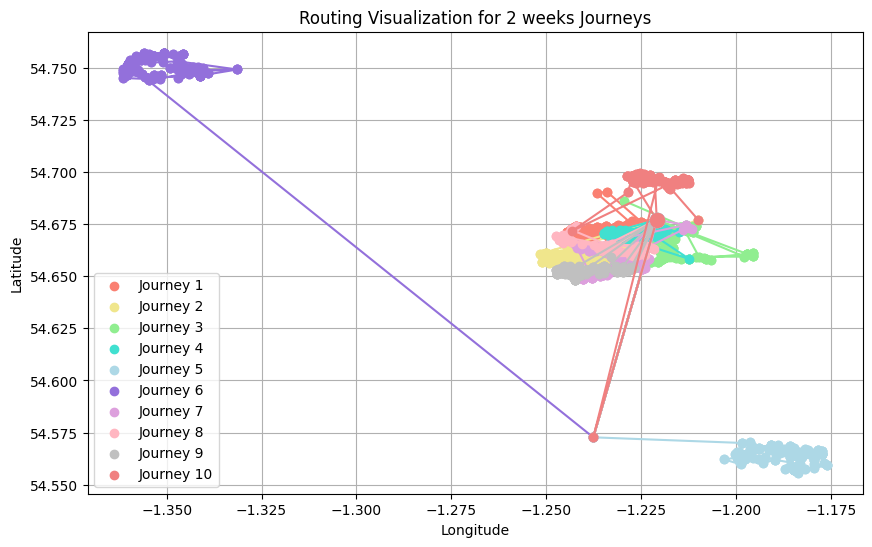

In [ ]:
plt.figure(figsize=(10,6))

# A list of colors
colors = ['salmon', 'khaki', 'lightgreen', 'turquoise', 'lightblue', 'mediumpurple', 'plum', 'lightpink', 'silver', 'lightcoral']

for i, df in enumerate(journeys):
    longitudes = df['D_Longitude']
    latitudes = df['D_Latitude']

    # plot points
    plt.scatter(longitudes, latitudes, c=colors[i], label=f'Journey {i+1}')

    # Connect the points with lines to indicate order
    plt.plot(longitudes, latitudes, '-o', c=colors[i], markerfacecolor=colors[i])

    # Highlight the first point and make it bigger
    plt.scatter(df['D_Longitude'].iloc[0], df['D_Latitude'].iloc[0], c=colors[i], s=100, zorder=5)

plt.title('Routing Visualization for 2 weeks Journeys')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(loc='best')
plt.grid(True)
plt.savefig("Routing Visualization for 2 weeks Journeys.png")
plt.show()

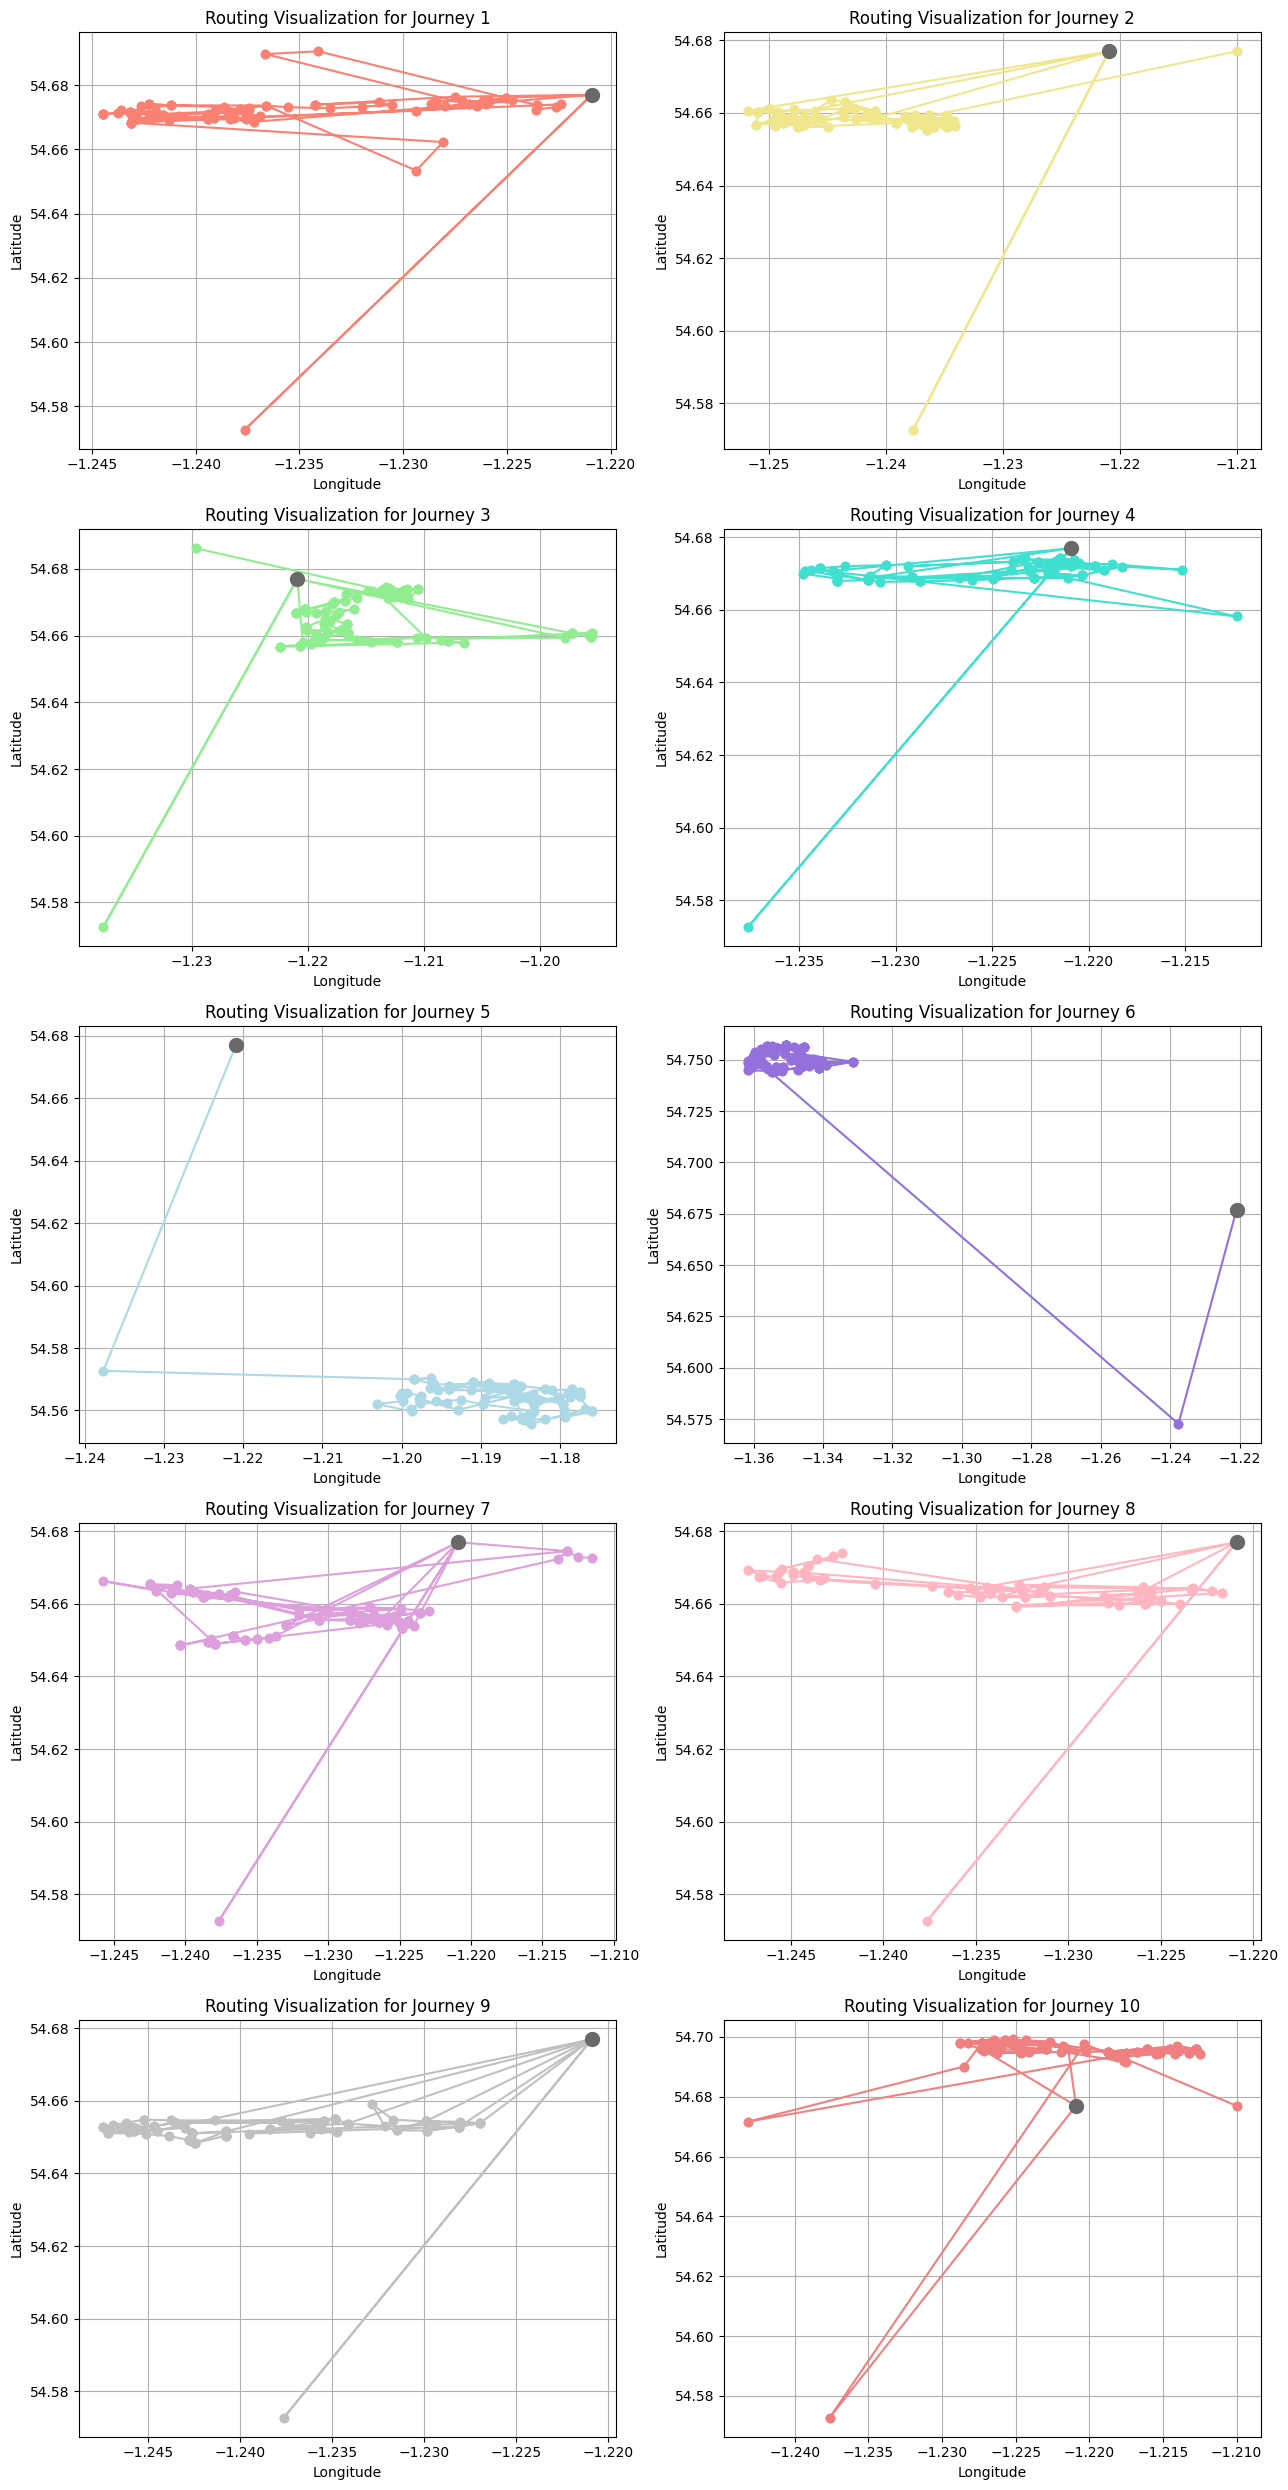

In [ ]:
# A list of colors
colors = ['salmon', 'khaki', 'lightgreen', 'turquoise', 'lightblue', 'mediumpurple', 'plum', 'lightpink', 'silver', 'lightcoral']

plt.figure(figsize=(13, 25))

for i, df in enumerate(journeys):

    plt.subplot(5, 2, i+1)  # 2 rows, 5 columns, current plot number

    longitudes = df['D_Longitude']
    latitudes = df['D_Latitude']

    # plot points
    plt.scatter(longitudes, latitudes, c=colors[i])  # use color from the list

    # Connect the points with lines to indicate order
    plt.plot(longitudes, latitudes, '-o', c=colors[i], markerfacecolor=colors[i])

    # Highlight the first point and make it bigger
    plt.scatter(df['D_Longitude'].iloc[0], df['D_Latitude'].iloc[0], c='dimgrey', s=100, zorder=5)

    plt.title(f'Routing Visualization for Journey {i+1}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.savefig("Routing Visualization for Journeys {i+1}.png")
    plt.grid(True)

plt.tight_layout()  # This ensures that the subplots do not overlap
plt.show()

In [ ]:
# # A list of colors
# colors = ['salmon', 'khaki', 'lightgreen', 'turquoise', 'lightblue', 'mediumpurple', 'plum', 'lightpink', 'silver', 'lightcoral']

# for i, df in enumerate(journeys):

#     plt.figure(figsize=(12, 8))  # Adjusted size for single plot

#     longitudes = df['D_Longitude']
#     latitudes = df['D_Latitude']

#     # plot points
#     plt.scatter(longitudes, latitudes, c=colors[i])  # use color from the list

#     # Connect the points with lines to indicate order
#     plt.plot(longitudes, latitudes, '-o', c=colors[i], markerfacecolor=colors[i])

#     # Highlight the first point and make it bigger
#     plt.scatter(df['D_Longitude'].iloc[0], df['D_Latitude'].iloc[0], c='dimgrey', s=100, zorder=5)

#     plt.title(f'Routing Visualization for Journey {i+1}')
#     plt.xlabel('Longitude')
#     plt.ylabel('Latitude')
#     plt.grid(True)
#     plt.tight_layout()
#     plt.savefig(f"Routing Visualization for Journey {i+1}.png")
#     plt.close()  # Close the figure to free up memory


In [ ]:
import pandas as pd

# Define which columns to sum up
cols_to_sum = ['Waiting time', 'Travel time']

# Create an empty list to store the results
results = []

# Loop through each dataframe in the journeys list
for index, df in enumerate(journeys):
    # Sum up the columns
    sums = df[cols_to_sum].sum()

    # Get the last value for the 'Cumulative travel time' column
    # last_cumulative = df['Cumulative travel time'].iloc[-1]

    # Compute the 'cum time'
    cum_time = sums['Waiting time'] + sums['Travel time']

    # Append the result to the results list
    results.append({
        'Waiting time': sums['Waiting time'],
        'Travel time': sums['Travel time'],
        # 'Last Cumulative travel time': last_cumulative,
        'cum time': cum_time
    })

# Create a dataframe from the results list for easier inspection
result_df = pd.DataFrame(results)
print(result_df)


     Waiting time     Travel time        cum time
0 0 days 08:42:00 0 days 02:57:00 0 days 11:39:00
1 0 days 08:29:00 0 days 02:43:00 0 days 11:12:00
2 0 days 08:06:00 0 days 03:08:00 0 days 11:14:00
3 0 days 08:20:00 0 days 02:43:00 0 days 11:03:00
4 0 days 08:07:00 0 days 02:56:00 0 days 11:03:00
5 0 days 07:31:00 0 days 03:46:00 0 days 11:17:00
6 0 days 07:21:00 0 days 03:43:00 0 days 11:04:00
7 0 days 08:19:00 0 days 02:42:00 0 days 11:01:00
8 0 days 10:16:00 0 days 02:57:00 0 days 13:13:00
9 0 days 07:04:00 0 days 03:36:00 0 days 10:40:00


# Vehicle routing optimization & Routing visualization

In [ ]:
pip install ortools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 54.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.4/311.4 kB 31.0 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.21.12
    Uninstalling protobuf-4.21.12:
      Successfully uninstalled protobuf-4.21.12
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.14.0 requires protobuf<4.21,>=3.20.3, but you have protobuf 4.24.2 which is incompatible.
traveltimepy 3.4.0 requires protobuf==4.21.12, but you have protobuf 4.24.2 which is incompatible.


In [ ]:
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

## Journey model

Journey 1

In [ ]:
waiting_times_1 = waiting_times_dict['waiting_times_df_1'].set_index('Departure_postcode')['Waiting time'].to_dict()


In [ ]:
def solve_routing_problem(df, start_postcode, next_postcode, end_postcode, waiting_times):

    # Get indices
    start_index = df.columns.get_loc(start_postcode)
    next_index = df.columns.get_loc(next_postcode)
    end_index = df.columns.get_loc(end_postcode)

    # Extract time matrix from dataframe
    time_matrix = df.values.tolist()

    def create_data_model():
        data = {}
        data["time_matrix"] = time_matrix
        data["num_vehicles"] = 1
        data["depot"] = start_index
        return data

    data = create_data_model()
    manager = pywrapcp.RoutingIndexManager(len(data["time_matrix"]), data["num_vehicles"], data["depot"])
    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(from_index, to_index):
        node = manager.IndexToNode(from_index)
        postcode = df.columns[node]
        waiting_time = waiting_times.get(postcode, 0)
        return data["time_matrix"][node][manager.IndexToNode(to_index)] + waiting_time

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)
    routing.NextVar(routing.Start(0)).RemoveValues([i for i in range(len(data["time_matrix"])) if i != next_index])

    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC

    solution = routing.SolveWithParameters(search_parameters)
    if not solution:
        return "No solution found!"

    route = []
    travel_time = 0
    index = routing.Start(0)
    previous_index = index
    while not routing.IsEnd(index):
        route.append(df.columns[manager.IndexToNode(index)])
        travel_time += routing.GetArcCostForVehicle(previous_index, index, 0)
        previous_index = index
        index = solution.Value(routing.NextVar(index))
    route.append(df.columns[manager.IndexToNode(index)])
    travel_time += routing.GetArcCostForVehicle(previous_index, index, 0)

    result = {
        "title": f"Routing Result",
        "route": route,
    }

    return result

# Example usage:

# Specify postcodes
start_postcode = 'TS255QW'
next_postcode = 'TS13RA'
end_postcode = 'TS255QW'

result1 = solve_routing_problem(df_1, start_postcode, next_postcode, end_postcode, waiting_times_1)
print(result1["title"])
print("Route:", ', '.join(result1["route"]))


Routing Result
Route: TS255QW, TS13RA, TS260HH, TS260HG, TS255RJ, TS255QH, TS255QF, TS255QE, TS255QA, TS255PY, TS255PU, TS255PT, TS255PS, TS255PL, TS255PJ, TS255PD, TS255PB, TS255PA, TS255NZ, TS255NX, TS255NU, TS255NS, TS255NR, TS255NQ, TS255ND, TS255LX, TS255LT, TS255EF, TS254PR, TS254PF, TS254PD, TS254NY, TS254NX, TS254NU, TS254NT, TS254NR, TS254NP, TS254NN, TS254NL, TS254NJ, TS254NE, TS254NA, TS254LQ, TS254LN, TS254LJ, TS254LH, TS254LG, TS254LF, TS254LE, TS254JU, TS254JT, TS254JN, TS254JH, TS254JG, TS254JE, TS254JD, TS254JA, TS254HU, TS254HS, TS254HR, TS254HD, TS254GZ, TS252QF, TS255QW


In [ ]:
df_1

TS252QF    TS254GZ    TS254HD    TS254HR    TS254HS    TS254HU  \
TS252QF   0.000000   9.083333   7.916667   7.450000   7.316667   7.566667   
TS254GZ   9.016667   0.000000   1.933333   2.633333   2.800000   2.583333   
TS254HD   7.916667   1.966667   0.000000   2.316667   2.316667   2.433333   
TS254HR   7.466667   2.633333   2.283333   0.000000   1.166667   0.783333   
TS254HS   7.333333   2.800000   2.283333   1.166667   0.000000   1.283333   
...            ...        ...        ...        ...        ...        ...   
TS255QW   8.833333   4.533333   3.000000   4.533333   4.533333   4.650000   
TS255RJ   7.816667   4.000000   2.833333   3.850000   3.850000   3.966667   
TS260HG  12.400000   6.450000   4.983333   6.800000   6.800000   6.916667   
TS260HH  12.700000   6.750000   5.283333   7.100000   7.100000   7.216667   
TS13RA   24.333333  30.900000  29.733333  29.266667  29.133333  29.383333   

           TS254JA    TS254JD    TS254JE    TS254JG  ...    TS255PY  \
TS252QF   8.183333   7.716667   7.550000   7.666667  ...   9.383333   
TS254GZ   2.166667   2.733333   2.700000   2.850000  ...   3.400000   
TS254HD   2.300000   2.583333   2.416667   2.533333  ...   1.900000   
TS254HR   1.400000   0.933333   0.766667   0.866667  ...   3.750000   
TS254HS   1.683333   1.433333   1.266667   1.383333  ...   3.750000   
...            ...        ...        ...        ...  ...        ...   
TS255QW   4.666667   4.800000   4.633333   4.750000  ...   3.133333   
TS255RJ   3.983333   4.116667   3.950000   4.066667  ...   3.000000   
TS260HG   6.783333   7.066667   6.900000   7.016667  ...   6.400000   
TS260HH   7.083333   7.366667   7.200000   7.316667  ...   6.700000   
TS13RA   30.000000  29.533333  29.366667  29.483333  ...  31.200000   

           TS255QA    TS255QE    TS255QF    TS255QH    TS255QW    TS255RJ  \
TS252QF   7.900000   7.866667   8.850000   8.466667   8.466667   7.400000   
TS254GZ   3.550000   3.483333   4.000000   3.650000   4.450000   3.900000   
TS254HD   2.450000   2.383333   2.900000   2.200000   3.000000   2.800000   
TS254HR   3.450000   3.383333   3.900000   3.550000   4.350000   3.800000   
TS254HS   3.450000   3.383333   3.900000   3.550000   4.350000   3.800000   
...            ...        ...        ...        ...        ...        ...   
TS255QW   2.216667   2.066667   3.183333   1.450000   0.000000   1.616667   
TS255RJ   1.183333   1.166667   2.250000   1.666667   1.666667   0.000000   
TS260HG   6.933333   6.866667   7.383333   6.333333   6.150000   6.500000   
TS260HH   7.233333   7.166667   7.683333   6.633333   6.450000   6.800000   
TS13RA   29.466667  29.433333  30.416667  30.033333  30.033333  28.966667   

           TS260HG    TS260HH     TS13RA  
TS252QF  12.400000  12.650000  25.100000  
TS254GZ   6.416667   6.666667  31.350000  
TS254HD   4.983333   5.233333  30.300000  
TS254HR   6.766667   7.016667  29.850000  
TS254HS   6.766667   7.016667  29.716667  
...            ...        ...        ...  
TS255QW   6.200000   6.450000  30.650000  
TS255RJ   6.550000   6.800000  29.633333  
TS260HG   0.000000   1.566667  28.416667  
TS260HH   1.566667   0.000000  29.250000  
TS13RA   30.816667  31.633333   0.000000  

[63 rows x 63 columns]

In [ ]:
import numpy as np

time_matrix = df_1.values
route_indices1 = [df_1.columns.get_loc(code) for code in result1['route']]

# Extract travel times from the time matrix for the determined route
travel_times = time_matrix[route_indices1[:-1], route_indices1[1:]]

# Extract waiting times for each postcode in the determined route (except the last one)
waiting_times_route = [waiting_times_1.get(result1['route'][i], 0) for i in range(len(result1['route']) - 1)]

# print("Individual Travel Times:", travel_times)
# print("Individual Waiting Times:", waiting_times_route)

# Combine travel times and waiting times
total_times = travel_times + np.array(waiting_times_route)

total_time1 = np.sum(total_times)
print("Total Waiting Time:", sum(np.array(waiting_times_route)), "minutes")
print("Total Driving Time:", sum(travel_times), "minutes")
print("Total Travel Time:", total_time1, "minutes")

Total Waiting Time: 406 minutes
Total Driving Time: 175.34999999599998 minutes
Total Travel Time: 581.349999996 minutes


In [ ]:
import datetime

def convert_minutes_to_time(minutes):
    # Convert minutes into hours, minutes, and seconds
    hours, remainder = divmod(minutes, 60)
    minutes, seconds = divmod(remainder*60, 60)
    return datetime.time(int(hours), int(minutes), int(seconds))

# Assuming the computations remain the same

waiting_time_1_dt = convert_minutes_to_time(sum(np.array(waiting_times_route)))
driving_time_1_dt = convert_minutes_to_time(sum(travel_times))
total_time_1_dt = convert_minutes_to_time(total_time1)

print("Total Waiting Time:", waiting_time_1_dt)
print("Total Driving Time:", driving_time_1_dt)
print("Total Travel Time:", total_time_1_dt)


Total Waiting Time: 06:46:00
Total Driving Time: 02:55:20
Total Travel Time: 09:41:20


Journey 1: Data Visualization

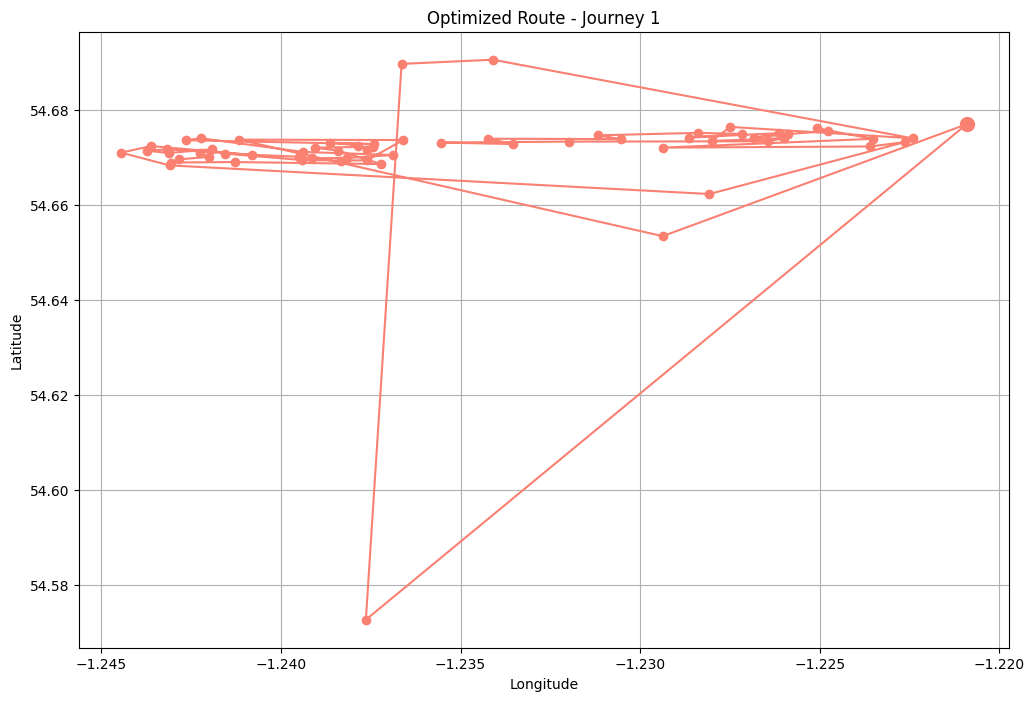

In [ ]:
mon_17_location_depot_unique['Departure_postcode'] = mon_17_location_depot_unique['Departure_postcode'].str.strip()

route_x = [mon_17_location_depot_unique[mon_17_location_depot_unique['Departure_postcode'] == postcode]['D_Longitude'].values[0] for postcode in result1['route']]
route_y = [mon_17_location_depot_unique[mon_17_location_depot_unique['Departure_postcode'] == postcode]['D_Latitude'].values[0] for postcode in result1['route']]

# Plot
plt.figure(figsize=(12,8))
plt.plot(route_x, route_y, marker='o', c='salmon', markerfacecolor='salmon')

# Get the latitude and longitude for the postcode 'TS255QW'
dep_lat = mon_17_location_depot_unique[mon_17_location_depot_unique['Departure_postcode'] == 'TS255QW']['D_Latitude'].values[0]
dep_lon = mon_17_location_depot_unique[mon_17_location_depot_unique['Departure_postcode'] == 'TS255QW']['D_Longitude'].values[0]

# Highlight the point corresponding to the postcode 'TS255QW' in green and make it bigger
plt.scatter(dep_lon, dep_lat, c='salmon', s=100, label='Start Point', zorder=5)

plt.title('Optimized Route - Journey 1')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.savefig("Optimized Route - Journey 1.png")
plt.show()

Journey 2

In [ ]:
waiting_times_2 = waiting_times_dict['waiting_times_df_2'].set_index('Departure_postcode')['Waiting time'].to_dict()


In [ ]:
result2 = solve_routing_problem(df_2, start_postcode, next_postcode, end_postcode, waiting_times_2)
print(result2["title"])
print("Route:", ', '.join(result2["route"]))

Routing Result
Route: TS255QW, TS13RA, TS254EY, TS254DB, TS254DA, TS254BE, TS253RX, TS253RT, TS253RS, TS253RR, TS253RN, TS253RJ, TS253RB, TS253QY, TS253QX, TS253QU, TS253QT, TS253QR, TS253QH, TS253QE, TS253PW, TS253PL, TS253PJ, TS253PE, TS253PD, TS253NW, TS253NR, TS253NL, TS253NE, TS253ND, TS253LZ, TS253LP, TS253LG, TS253LA, TS253JH, TS253JF, TS253JD, TS253JB, TS253JA, TS253HZ, TS253HW, TS253HU, TS253HS, TS253HR, TS253HQ, TS253HP, TS253HJ, TS253HH, TS253HG, TS253HF, TS253HA, TS253EX, TS253EU, TS253ET, TS253EQ, TS253EP, TS253EN, TS253EH, TS253EG, TS253DH, TS251UP, TS255QW


In [ ]:
import numpy as np

time_matrix2 = df_2.values
route_indices2 = [df_2.columns.get_loc(code) for code in result2['route']]

# Extract travel times from the time matrix for the determined route
travel_times2 = time_matrix2[route_indices2[:-1], route_indices2[1:]]

# Extract waiting times for each postcode in the determined route (except the last one)
waiting_times_route2 = [waiting_times_2.get(result2['route'][i], 0) for i in range(len(result2['route']) - 1)]

# print("Individual Travel Times:", travel_times2)
# print("Individual Waiting Times:", waiting_times_route2)

# Combine travel times and waiting times
total_times2 = travel_times2 + np.array(waiting_times_route2)

total_time2 = np.sum(total_times2)
print("Total Waiting Time:", sum(np.array(waiting_times_route2)), "minutes")
print("Total Driving Time:", sum(travel_times2), "minutes")
print("Total Travel Time:", total_time2, "minutes")

Total Waiting Time: 393 minutes
Total Driving Time: 145.93333333200005 minutes
Total Travel Time: 538.933333332 minutes


In [ ]:
waiting_time_2_dt = convert_minutes_to_time(sum(np.array(waiting_times_route2)))
driving_time_2_dt = convert_minutes_to_time(sum(travel_times2))
total_time_2_dt = convert_minutes_to_time(total_time2)

print("Total Waiting Time:", waiting_time_2_dt)
print("Total Driving Time:", driving_time_2_dt)
print("Total Travel Time:", total_time_2_dt)

Total Waiting Time: 06:33:00
Total Driving Time: 02:25:55
Total Travel Time: 08:58:55


Journey 2: Data Visualization

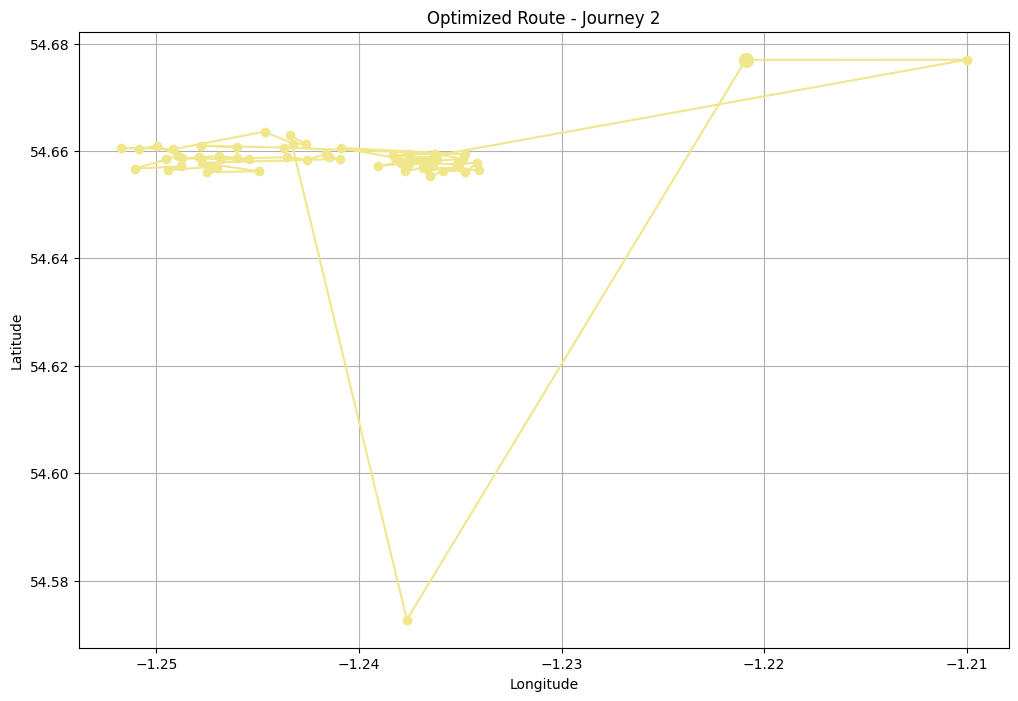

In [ ]:
tue_18_location_depot_unique['Departure_postcode'] = tue_18_location_depot_unique['Departure_postcode'].str.strip()

route_x = [tue_18_location_depot_unique[tue_18_location_depot_unique['Departure_postcode'] == postcode]['D_Longitude'].values[0] for postcode in result2["route"]]
route_y = [tue_18_location_depot_unique[tue_18_location_depot_unique['Departure_postcode'] == postcode]['D_Latitude'].values[0] for postcode in result2["route"]]

# Plot
plt.figure(figsize=(12,8))
plt.plot(route_x, route_y, marker='o', c='khaki', markerfacecolor='khaki')

# Get the latitude and longitude for the postcode 'TS255QW'
dep_lat = tue_18_location_depot_unique[tue_18_location_depot_unique['Departure_postcode'] == 'TS255QW']['D_Latitude'].values[0]
dep_lon = tue_18_location_depot_unique[tue_18_location_depot_unique['Departure_postcode'] == 'TS255QW']['D_Longitude'].values[0]

# Highlight the point corresponding to the postcode 'TS255QW' in green and make it bigger
plt.scatter(dep_lon, dep_lat, c='khaki', s=100, label='Start Point', zorder=5)

plt.title('Optimized Route - Journey 2')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.savefig("Optimized Route - Journey 2.png")
plt.show()

Journey 3

In [ ]:
waiting_times_3 = waiting_times_dict['waiting_times_df_3'].set_index('Departure_postcode')['Waiting time'].to_dict()

In [ ]:
result3 = solve_routing_problem(df_3, start_postcode, next_postcode, end_postcode,waiting_times_3)
print(result3["title"])
print("Route:", ', '.join(result3["route"]))

Routing Result
Route: TS255QW, TS13RA, TS268JL, TS255TD, TS255HR, TS255FA, TS255DQ, TS255DJ, TS255DF, TS255DE, TS255DD, TS255BX, TS255BE, TS255BB, TS255AZ, TS255AY, TS252PQ, TS251UY, TS251UW, TS251TP, TS251RZ, TS251RS, TS251RR, TS251RQ, TS251RN, TS251RJ, TS251RG, TS251RD, TS251RA, TS251QZ, TS251QT, TS251QQ, TS251QL, TS251QJ, TS251QH, TS251QB, TS251QA, TS251PZ, TS251PY, TS251NQ, TS251NG, TS251NF, TS251LY, TS251LU, TS251LT, TS251LS, TS251LR, TS251LP, TS251LD, TS251JN, TS251JL, TS251JJ, TS251JH, TS251HS, TS251HR, TS251HQ, TS251HF, TS251HD, TS251HB, TS251GH, TS251FB, TS251DX, TS251DW, TS251DT, TS251DS, TS251DR, TS255QW


In [ ]:
time_matrix3 = df_3.values
route_indices3 = [df_3.columns.get_loc(code) for code in result3['route']]

# Extract travel times from the time matrix for the determined route
travel_times3 = time_matrix3[route_indices3[:-1], route_indices3[1:]]

# Extract waiting times for each postcode in the determined route (except the last one)
waiting_times_route3 = [waiting_times_3.get(result3['route'][i], 0) for i in range(len(result3['route']) - 1)]

# Combine travel times and waiting times
total_times3 = travel_times3 + np.array(waiting_times_route3)

total_time3 = np.sum(total_times3)
print("Total Waiting Time:", sum(np.array(waiting_times_route3)), "minutes")
print("Total Driving Time:", sum(travel_times3), "minutes")
print("Total Travel Time:", total_time3, "minutes")

Total Waiting Time: 326 minutes
Total Driving Time: 217.59999999899995 minutes
Total Travel Time: 543.5999999989999 minutes


In [ ]:
waiting_time_3_dt = convert_minutes_to_time(sum(np.array(waiting_times_route3)))
driving_time_3_dt = convert_minutes_to_time(sum(travel_times3))
total_time_3_dt = convert_minutes_to_time(total_time3)

print("Total Waiting Time:", waiting_time_3_dt)
print("Total Driving Time:", driving_time_3_dt)
print("Total Travel Time:", total_time_3_dt)

Total Waiting Time: 05:26:00
Total Driving Time: 03:37:35
Total Travel Time: 09:03:35


Journey 3: Data Visualization

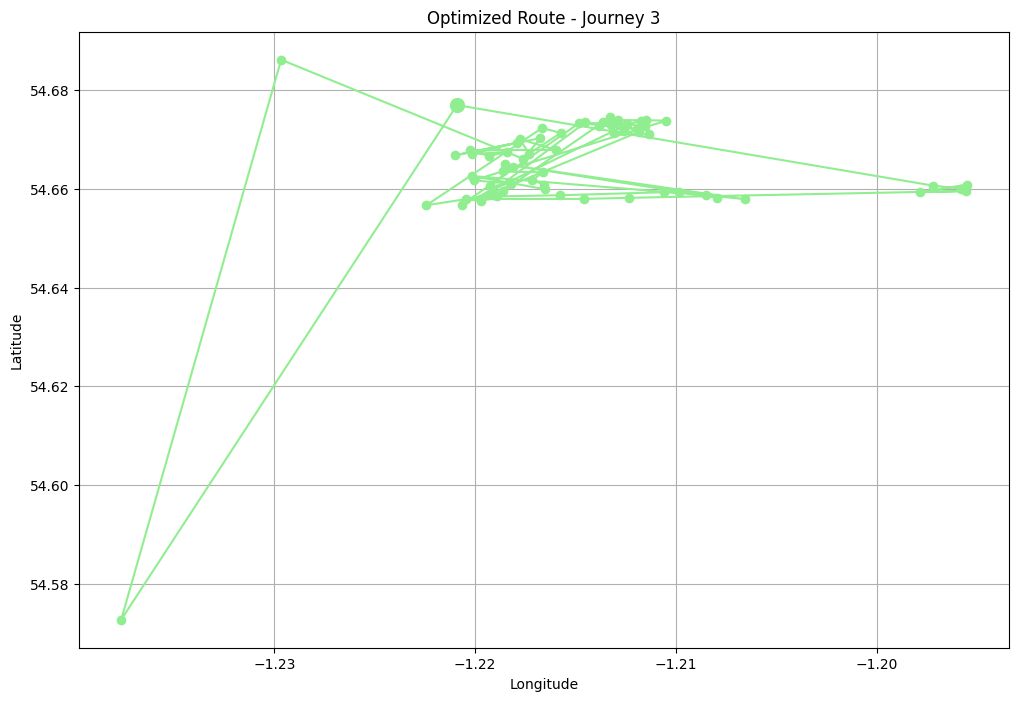

In [ ]:
wed_19_location_depot_unique['Departure_postcode'] = wed_19_location_depot_unique['Departure_postcode'].str.strip()

route_x = [wed_19_location_depot_unique[wed_19_location_depot_unique['Departure_postcode'] == postcode]['D_Longitude'].values[0] for postcode in result3["route"]]
route_y = [wed_19_location_depot_unique[wed_19_location_depot_unique['Departure_postcode'] == postcode]['D_Latitude'].values[0] for postcode in result3["route"]]

# Plot
plt.figure(figsize=(12,8))
plt.plot(route_x, route_y, marker='o', c='lightgreen', markerfacecolor='lightgreen')

# Get the latitude and longitude for the postcode 'TS255QW'
dep_lat = wed_19_location_depot_unique[wed_19_location_depot_unique['Departure_postcode'] == 'TS255QW']['D_Latitude'].values[0]
dep_lon = wed_19_location_depot_unique[wed_19_location_depot_unique['Departure_postcode'] == 'TS255QW']['D_Longitude'].values[0]

# Highlight the point corresponding to the postcode 'TS255QW' in green and make it bigger
plt.scatter(dep_lon, dep_lat, c='lightgreen', s=100, label='Start Point', zorder=5)

plt.title('Optimized Route - Journey 3')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.savefig("Optimized Route - Journey 3.png")
plt.show()

Journey 4

In [ ]:
waiting_times_4 = waiting_times_dict['waiting_times_df_4'].set_index('Departure_postcode')['Waiting time'].to_dict()

In [ ]:
result4 = solve_routing_problem(df_4, start_postcode, next_postcode, end_postcode, waiting_times_4)
print(result4["title"])
print("Route:", ', '.join(result4["route"]))

Routing Result
Route: TS255QW, TS13RA, TS255RP, TS255NQ, TS255NJ, TS255NH, TS255ND, TS255NA, TS255LZ, TS255LY, TS255LW, TS255LU, TS255LT, TS255LS, TS255LR, TS255LQ, TS255LP, TS255LN, TS255LL, TS255LH, TS255LG, TS255LE, TS255LD, TS255LB, TS255JX, TS255JW, TS255JU, TS255JS, TS255JR, TS255JQ, TS255JP, TS255JN, TS255JL, TS255JH, TS255JG, TS255JF, TS255JE, TS255JD, TS255JB, TS255JA, TS255HZ, TS255HY, TS255HX, TS255HU, TS255HT, TS255HS, TS255BP, TS255AS, TS255AR, TS254HQ, TS251FB, TS255QW


In [ ]:
time_matrix4 = df_4.values
route_indices4 = [df_4.columns.get_loc(code) for code in result4['route']]

# Extract travel times from the time matrix for the determined route
travel_times4 = time_matrix4[route_indices4[:-1], route_indices4[1:]]

# Extract waiting times for each postcode in the determined route (except the last one)
waiting_times_route4 = [waiting_times_4.get(result4['route'][i], 0) for i in range(len(result4['route']) - 1)]

# Combine travel times and waiting times
total_times4 = travel_times4 + np.array(waiting_times_route4)

total_time4 = np.sum(total_times4)
print("Total Waiting Time:", sum(np.array(waiting_times_route4)), "minutes")
print("Total Driving Time:", sum(travel_times4), "minutes")
print("Total Travel Time:", total_time4, "minutes")

Total Waiting Time: 261 minutes
Total Driving Time: 166.099999996 minutes
Total Travel Time: 427.09999999599995 minutes


In [ ]:
waiting_time_4_dt = convert_minutes_to_time(sum(np.array(waiting_times_route4)))
driving_time_4_dt = convert_minutes_to_time(sum(travel_times4))
total_time_4_dt = convert_minutes_to_time(total_time4)

print("Total Waiting Time:", waiting_time_4_dt)
print("Total Driving Time:", driving_time_4_dt)
print("Total Travel Time:", total_time_4_dt)

Total Waiting Time: 04:21:00
Total Driving Time: 02:46:05
Total Travel Time: 07:07:05


Journey 4: Data Visualization

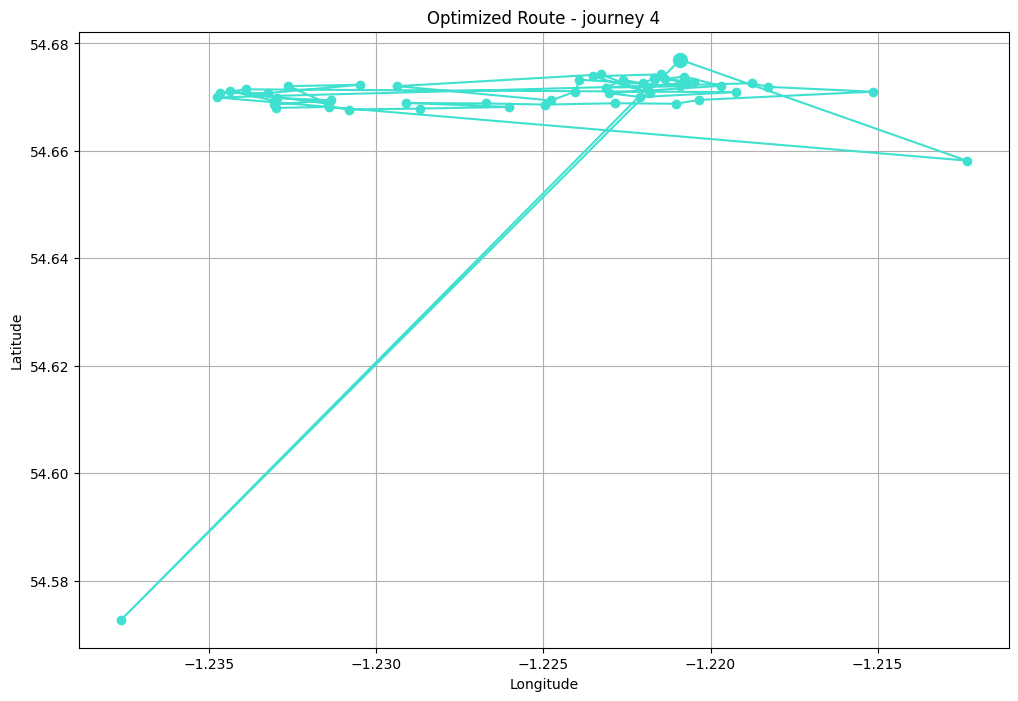

In [ ]:
thu_20_location_depot_unique['Departure_postcode'] = thu_20_location_depot_unique['Departure_postcode'].str.strip()

route_x = [thu_20_location_depot_unique[thu_20_location_depot_unique['Departure_postcode'] == postcode]['D_Longitude'].values[0] for postcode in result4["route"]]
route_y = [thu_20_location_depot_unique[thu_20_location_depot_unique['Departure_postcode'] == postcode]['D_Latitude'].values[0] for postcode in result4["route"]]

# Plot
plt.figure(figsize=(12,8))
plt.plot(route_x, route_y, marker='o', c='turquoise', markerfacecolor='turquoise')

# Highlight the point corresponding to the postcode 'TS255QW' in green and make it bigger
plt.scatter(dep_lon, dep_lat, c='turquoise', s=100, label='Start Point', zorder=5)

plt.title('Optimized Route - journey 4')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.savefig("Optimized Route - Journey 4.png")
plt.show()

**Journey 5**

In [ ]:
waiting_times_5 = waiting_times_dict['waiting_times_df_5'].set_index('Departure_postcode')['Waiting time'].to_dict()

In [ ]:
df_5_sp=df_5
df_5_sp.columns = df_5.columns.str.replace(" ", "")
df_5_sp.index = df_5.index.str.replace(" ", "")
fri_21_location_depot_unique['Departure_postcode']=fri_21_location_depot_unique['Departure_postcode'].str.replace(" ", "")
fri_21_location_depot_unique

Departure_postcode  D_Latitude  D_Longitude
0             TS255QW   54.676974    -1.220906
1              TS13RA   54.572710    -1.237636
2              TS38EA   54.570009    -1.198461
3              TS38ED   54.570416    -1.196257
4              TS39AB   54.568386    -1.195935
..                ...         ...          ...
61             TS39PB   54.557316    -1.181871
62             TS39PG   54.556946    -1.184352
63             TS39LR   54.557298    -1.187190
64             TS39DW   54.568055    -1.185909
65             TS39AW   54.567066    -1.196462

[66 rows x 3 columns]

In [ ]:
result5 = solve_routing_problem(df_5_sp, start_postcode, next_postcode, end_postcode, waiting_times_5)
print(result5["title"])
print("Route:", ', '.join(result5["route"]))

Routing Result
Route: TS255QW, TS13RA, TS39AW, TS39QA, TS39PW, TS39PL, TS39PG, TS39PF, TS39PB, TS39NW, TS39NJ, TS39NG, TS39NB, TS39LX, TS39LW, TS39LU, TS39LR, TS39LP, TS39LL, TS39LH, TS39JW, TS39JA, TS39HZ, TS39HY, TS39HW, TS39HR, TS39HP, TS39HH, TS39HF, TS39HE, TS39HD, TS39HB, TS39GZ, TS39GY, TS39GX, TS39EY, TS39EU, TS39ER, TS39EG, TS39DY, TS39DW, TS39DP, TS39DE, TS39BX, TS39BQ, TS39BA, TS39AU, TS39AS, TS39AB, TS38QQ, TS38QJ, TS38PZ, TS38PH, TS38PA, TS38NY, TS38LY, TS38LW, TS38LU, TS38LJ, TS38LA, TS38JY, TS38JT, TS38JS, TS38ED, TS38EA, TS30PY, TS255QW


In [ ]:
time_matrix5 = df_5_sp.values
route_indices5 = [df_5_sp.columns.get_loc(code) for code in result5['route']]

# Extract travel times from the time matrix for the determined route
travel_times5 = time_matrix5[route_indices5[:-1], route_indices5[1:]]

# Extract waiting times for each postcode in the determined route (except the last one)
waiting_times_route5 = [waiting_times_5.get(result5['route'][i], 0) for i in range(len(result5['route']) - 1)]

# Combine travel times and waiting times
total_times5 = travel_times5 + np.array(waiting_times_route5)

total_time5 = np.sum(total_times5)
print("Total Waiting Time:", sum(np.array(waiting_times_route5)), "minutes")
print("Total Driving Time:", sum(travel_times5), "minutes")
print("Total Travel Time:", total_time5, "minutes")

Total Waiting Time: 368 minutes
Total Driving Time: 202.36666666999997 minutes
Total Travel Time: 570.3666666700001 minutes


In [ ]:
waiting_time_5_dt = convert_minutes_to_time(sum(np.array(waiting_times_route5)))
driving_time_5_dt = convert_minutes_to_time(sum(travel_times5))
total_time_5_dt = convert_minutes_to_time(total_time5)

print("Total Waiting Time:", waiting_time_5_dt)
print("Total Driving Time:", driving_time_5_dt)
print("Total Travel Time:", total_time_5_dt)

Total Waiting Time: 06:08:00
Total Driving Time: 03:22:22
Total Travel Time: 09:30:22


Journey 5: Data Visualization

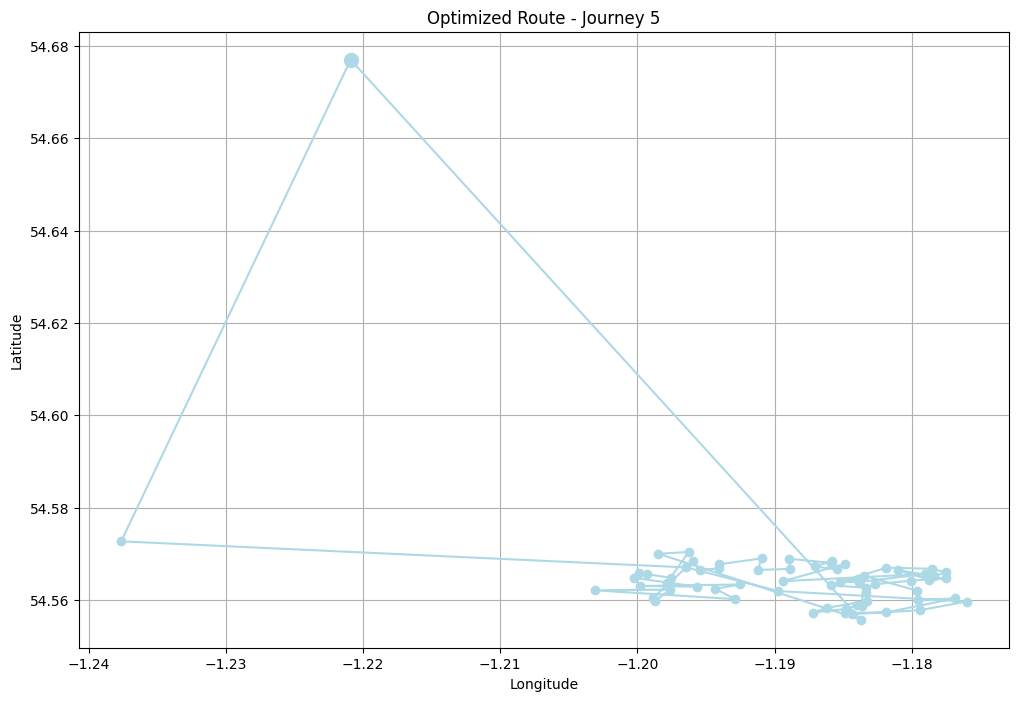

In [ ]:
fri_21_location_depot_unique['Departure_postcode'] = fri_21_location_depot_unique['Departure_postcode'].str.strip()

route_x = [fri_21_location_depot_unique[fri_21_location_depot_unique['Departure_postcode'] == postcode]['D_Longitude'].values[0] for postcode in result5["route"]]
route_y = [fri_21_location_depot_unique[fri_21_location_depot_unique['Departure_postcode'] == postcode]['D_Latitude'].values[0] for postcode in result5["route"]]

# Plot
plt.figure(figsize=(12,8))
plt.plot(route_x, route_y, marker='o', c='lightblue', markerfacecolor='lightblue')

# Highlight the point corresponding to the postcode 'TS255QW' in green and make it bigger
plt.scatter(dep_lon, dep_lat, c='lightblue', s=100, label='Start Point', zorder=5)

plt.title('Optimized Route - Journey 5')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.savefig("Optimized Route - Journey 5.png")
plt.show()

Journey 6

In [ ]:
waiting_times_6 = waiting_times_dict['waiting_times_df_6'].set_index('Departure_postcode')['Waiting time'].to_dict()


In [ ]:
df_6_sp=df_6
df_6_sp.columns = df_6.columns.str.replace(" ", "")
df_6_sp.index = df_6.index.str.replace(" ", "")
mon_24_location_depot_unique['Departure_postcode']=mon_24_location_depot_unique['Departure_postcode'].str.replace(" ", "")


In [ ]:
result6 = solve_routing_problem(df_6_sp, start_postcode, next_postcode, end_postcode,waiting_times_5)
print(result6["title"])
print("Route:", ', '.join(result6["route"]))

Routing Result
Route: TS255QW, TS13RA, SR82NZ, SR82NY, SR82NX, SR82NU, SR82NT, SR82NR, SR82NL, SR82NJ, SR82NH, SR82NG, SR82ND, SR82NB, SR82LQ, SR82LE, SR82LB, SR82JY, SR82JX, SR82JW, SR81QW, SR81QP, SR81QL, SR81QH, SR81QB, SR81QA, SR81PY, SR81PT, SR81PS, SR81PR, SR81PN, SR81PJ, SR81PH, SR81NW, SR81NQ, SR81NN, SR81NL, SR81NF, SR81NE, SR81NB, SR81NA, SR81LY, SR81LW, SR81LT, SR81LS, SR81LR, SR81LF, SR81LB, SR81JX, SR81JR, SR81JQ, SR81JJ, SR81JH, SR81HU, SR81HP, SR81HB, SR81EQ, SR81BZ, TS255QW


In [ ]:
time_matrix6 = df_6.values
route_indices6 = [df_6.columns.get_loc(code) for code in result6['route']]

# Extract travel times from the time matrix for the determined route
travel_times6 = time_matrix6[route_indices6[:-1], route_indices6[1:]]

# Extract waiting times for each postcode in the determined route (except the last one)
waiting_times_route6 = [waiting_times_6.get(result6['route'][i], 0) for i in range(len(result6['route']) - 1)]

# Combine travel times and waiting times
total_times6 = travel_times6 + np.array(waiting_times_route6)

total_time6 = np.sum(total_times6)
print("Total Waiting Time:", sum(np.array(waiting_times_route6)), "minutes")
print("Total Driving Time:", sum(travel_times6), "minutes")
print("Total Travel Time:", total_time6, "minutes")

Total Waiting Time: 280 minutes
Total Driving Time: 244.1833333333333 minutes
Total Travel Time: 524.1833333333334 minutes


In [ ]:
waiting_time_6_dt = convert_minutes_to_time(sum(np.array(waiting_times_route6)))
driving_time_6_dt = convert_minutes_to_time(sum(travel_times6))
total_time_6_dt = convert_minutes_to_time(total_time6)

print("Total Waiting Time:", waiting_time_6_dt)
print("Total Driving Time:", driving_time_6_dt)
print("Total Travel Time:", total_time_6_dt)

Total Waiting Time: 04:40:00
Total Driving Time: 04:04:10
Total Travel Time: 08:44:11


Journey 6: Data Visualization

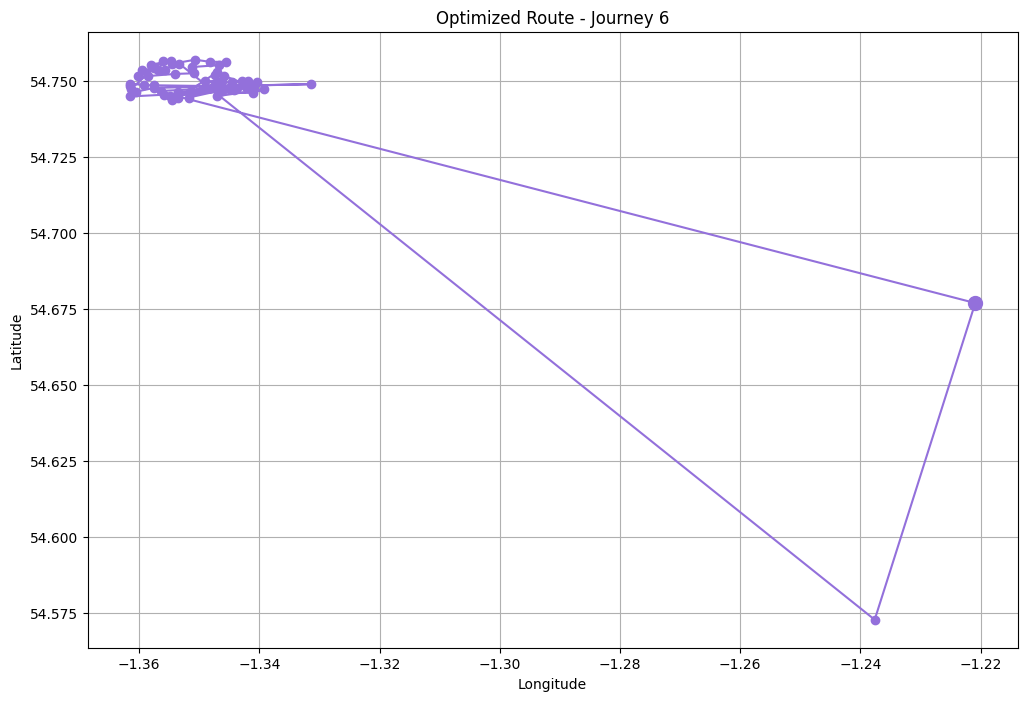

In [ ]:
mon_24_location_depot_unique['Departure_postcode'] = mon_24_location_depot_unique['Departure_postcode'].str.strip()

route_x = [mon_24_location_depot_unique[mon_24_location_depot_unique['Departure_postcode'] == postcode]['D_Longitude'].values[0] for postcode in result6["route"]]
route_y = [mon_24_location_depot_unique[mon_24_location_depot_unique['Departure_postcode'] == postcode]['D_Latitude'].values[0] for postcode in result6["route"]]

# Plot
plt.figure(figsize=(12,8))
plt.plot(route_x, route_y, marker='o', c='mediumpurple', markerfacecolor='mediumpurple')

# Highlight the point corresponding to the postcode 'TS255QW' in green and make it bigger
plt.scatter(dep_lon, dep_lat, c='mediumpurple', s=100, label='Start Point', zorder=5)

plt.title('Optimized Route - Journey 6')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.savefig("Optimized Route - Journey 6.png")
plt.show()

**Journey 7**

In [ ]:
waiting_times_7 = waiting_times_dict['waiting_times_df_7'].set_index('Departure_postcode')['Waiting time'].to_dict()


In [ ]:
result7 = solve_routing_problem(df_7, start_postcode, next_postcode, end_postcode,waiting_times_7)
print(result7["title"])
print("Route:", ', '.join(result7["route"]))

Routing Result
Route: TS255QW, TS13RA, TS254FB, TS254EU, TS254ES, TS254EQ, TS254EH, TS254EG, TS254EF, TS254EE, TS254DX, TS254DU, TS254DR, TS254DQ, TS254DH, TS253DW, TS253DR, TS253DP, TS253AW, TS253AU, TS253AT, TS253AL, TS253AD, TS253AB, TS253AA, TS252RW, TS252RN, TS252RL, TS252RJ, TS252RF, TS252RE, TS252RD, TS252RB, TS252RA, TS252QN, TS252QL, TS252PZ, TS252PY, TS252PX, TS252PW, TS252PU, TS252PT, TS252PS, TS252PR, TS252PP, TS252PN, TS252PL, TS252LT, TS251TP, TS251RQ, TS251RD, TS251QE, TS255QW


In [ ]:
time_matrix7 = df_7.values
route_indices7 = [df_7.columns.get_loc(code) for code in result7['route']]

# Extract travel times from the time matrix for the determined route
travel_times7 = time_matrix6[route_indices7[:-1], route_indices7[1:]]

# Extract waiting times for each postcode in the determined route (except the last one)
waiting_times_route7 = [waiting_times_7.get(result7['route'][i], 0) for i in range(len(result7['route']) - 1)]

# Combine travel times and waiting times
total_times7 = travel_times7 + np.array(waiting_times_route7)

total_time7 = np.sum(total_times7)
print("Total Waiting Time:", sum(np.array(waiting_times_route7)), "minutes")
print("Total Driving Time:", sum(travel_times7), "minutes")
print("Total Travel Time:", total_time7, "minutes")

Total Waiting Time: 207 minutes
Total Driving Time: 140.11666666666662 minutes
Total Travel Time: 347.1166666666666 minutes


In [ ]:
waiting_time_7_dt = convert_minutes_to_time(sum(np.array(waiting_times_route7)))
driving_time_7_dt = convert_minutes_to_time(sum(travel_times7))
total_time_7_dt = convert_minutes_to_time(total_time7)

print("Total Waiting Time:", waiting_time_7_dt)
print("Total Driving Time:", driving_time_7_dt)
print("Total Travel Time:", total_time_7_dt)

Total Waiting Time: 03:27:00
Total Driving Time: 02:20:06
Total Travel Time: 05:47:06


Journey 7: Data Visualization

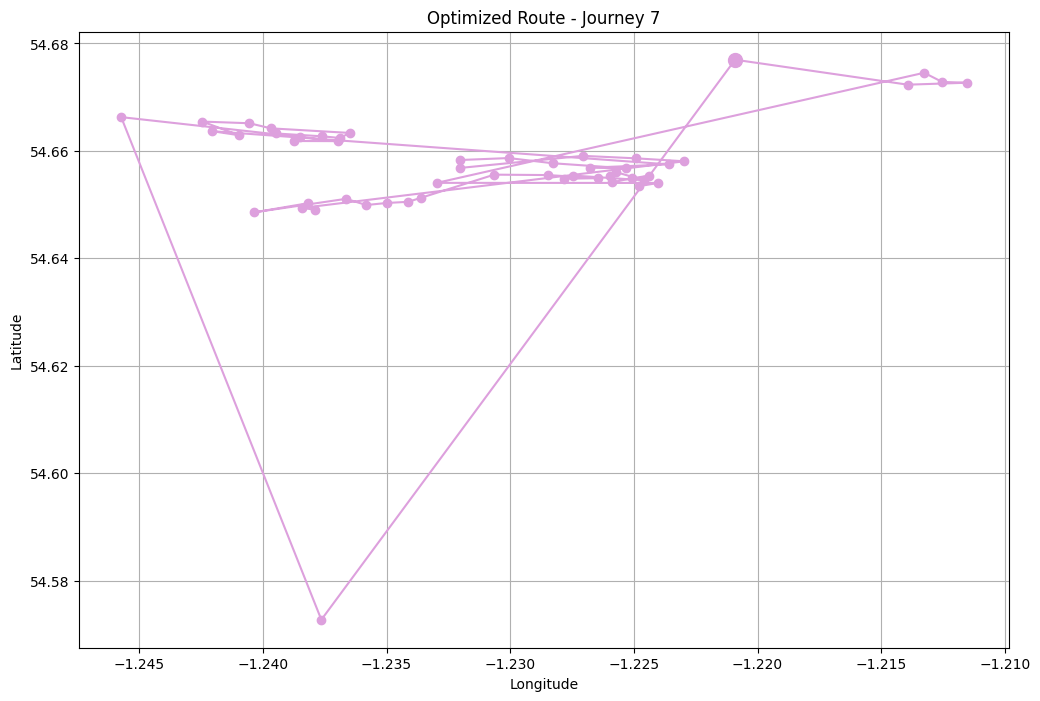

In [ ]:
tue_25_location_depot_unique['Departure_postcode'] = tue_25_location_depot_unique['Departure_postcode'].str.strip()

route_x = [tue_25_location_depot_unique[tue_25_location_depot_unique['Departure_postcode'] == postcode]['D_Longitude'].values[0] for postcode in result7["route"]]
route_y = [tue_25_location_depot_unique[tue_25_location_depot_unique['Departure_postcode'] == postcode]['D_Latitude'].values[0] for postcode in result7["route"]]

# Plot
plt.figure(figsize=(12,8))
plt.plot(route_x, route_y, marker='o', c='plum', markerfacecolor='plum')

# Highlight the point corresponding to the postcode 'TS255QW' in green and make it bigger
plt.scatter(dep_lon, dep_lat, c='plum', s=100, label='Start Point', zorder=5)

plt.title('Optimized Route - Journey 7')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.savefig("Optimized Route - Journey 7.png")
plt.show()

Journey 8

In [ ]:
waiting_times_8 = waiting_times_dict['waiting_times_df_8'].set_index('Departure_postcode')['Waiting time'].to_dict()


In [ ]:
result8 = solve_routing_problem(df_8, start_postcode, next_postcode, end_postcode,waiting_times_8)
print(result8["title"])
print("Route:", ', '.join(result8["route"]))

Routing Result
Route: TS255QW, TS13RA, TS255TZ, TS255TY, TS255TX, TS255TU, TS255HN, TS255HJ, TS255HF, TS255HD, TS255EQ, TS255EP, TS255EJ, TS255EF, TS255ED, TS255EA, TS255DZ, TS255DY, TS255DX, TS255DS, TS255DR, TS255DN, TS254RF, TS254RE, TS254RA, TS254QB, TS254QA, TS254PW, TS254PU, TS254PT, TS254PQ, TS254PJ, TS254PD, TS254JT, TS254JR, TS254EE, TS254BB, TS254AS, TS254AP, TS254AN, TS254AJ, TS254AH, TS254AG, TS254AD, TS254AA, TS253DN, TS253DJ, TS253DF, TS253DE, TS253DB, TS253BQ, TS253BD, TS253BB, TS255QW


In [ ]:
time_matrix8 = df_8.values
route_indices8 = [df_8.columns.get_loc(code) for code in result8['route']]

# Extract travel times from the time matrix for the determined route
travel_times8 = time_matrix8[route_indices8[:-1], route_indices8[1:]]

# Extract waiting times for each postcode in the determined route (except the last one)
waiting_times_route8 = [waiting_times_8.get(result8['route'][i], 0) for i in range(len(result8['route']) - 1)]

# Combine travel times and waiting times
total_times8 = travel_times8 + np.array(waiting_times_route8)

total_time8 = np.sum(total_times8)
print("Total Waiting Time:", sum(np.array(waiting_times_route8)), "minutes")
print("Total Driving Time:", sum(travel_times8), "minutes")
print("Total Travel Time:", total_time8, "minutes")

Total Waiting Time: 354 minutes
Total Driving Time: 153.36666666399998 minutes
Total Travel Time: 507.36666666400004 minutes


In [ ]:
waiting_time_8_dt = convert_minutes_to_time(sum(np.array(waiting_times_route8)))
driving_time_8_dt = convert_minutes_to_time(sum(travel_times8))
total_time_8_dt = convert_minutes_to_time(total_time8)

print("Total Waiting Time:", waiting_time_8_dt)
print("Total Driving Time:", driving_time_8_dt)
print("Total Travel Time:", total_time_8_dt)

Total Waiting Time: 05:54:00
Total Driving Time: 02:33:21
Total Travel Time: 08:27:21


Journey 8: Data Visualization

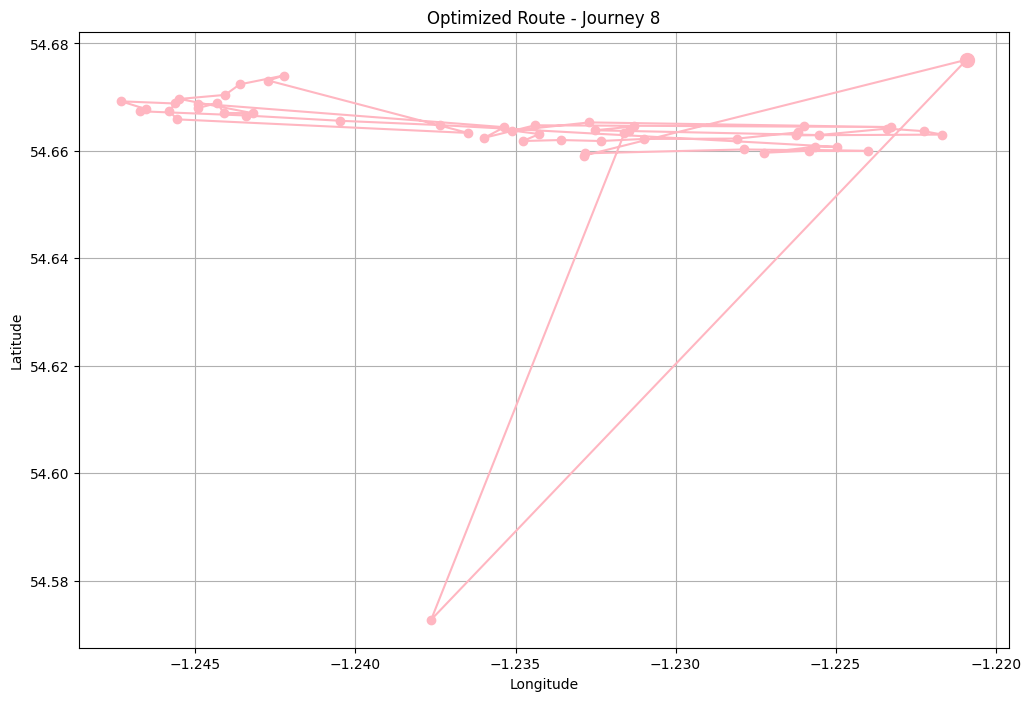

In [ ]:
wed_26_location_depot_unique['Departure_postcode'] = wed_26_location_depot_unique['Departure_postcode'].str.strip()

route_x = [wed_26_location_depot_unique[wed_26_location_depot_unique['Departure_postcode'] == postcode]['D_Longitude'].values[0] for postcode in result8["route"]]
route_y = [wed_26_location_depot_unique[wed_26_location_depot_unique['Departure_postcode'] == postcode]['D_Latitude'].values[0] for postcode in result8["route"]]

# Plot
plt.figure(figsize=(12,8))
plt.plot(route_x, route_y, marker='o', c='lightpink', markerfacecolor='lightpink')

# Highlight the point corresponding to the postcode 'TS255QW' in green and make it bigger
plt.scatter(dep_lon, dep_lat, c='lightpink', s=100, label='Start Point', zorder=5)

plt.title('Optimized Route - Journey 8')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.savefig("Optimized Route - Journey 8.png")
plt.show()

**Journey** 9

In [ ]:
waiting_times_9 = waiting_times_dict['waiting_times_df_9'].set_index('Departure_postcode')['Waiting time'].to_dict()


In [ ]:
result9 = solve_routing_problem(df_9, start_postcode, next_postcode, end_postcode,waiting_times_9)
print(result9["title"])
print("Route:", ', '.join(result9["route"]))

Routing Result
Route: TS255QW, TS13RA, TS253BB, TS252QW, TS252QT, TS252QS, TS252QR, TS252QQ, TS252QF, TS252QE, TS252QB, TS252NW, TS252NS, TS252NR, TS252NQ, TS252NP, TS252NN, TS252NL, TS252NJ, TS252NE, TS252LZ, TS252LY, TS252LX, TS252LW, TS252LP, TS252LN, TS252LJ, TS252LH, TS252LG, TS252LF, TS252LE, TS252LD, TS252LB, TS252LA, TS252JZ, TS252JY, TS252JX, TS252JW, TS252JU, TS252JT, TS252JS, TS252JP, TS252JJ, TS252JH, TS252JF, TS252JE, TS252JB, TS252JA, TS252GG, TS255QW


In [ ]:
time_matrix9 = df_9.values
route_indices9 = [df_9.columns.get_loc(code) for code in result9['route']]

# Extract travel times from the time matrix for the determined route
travel_times9 = time_matrix9[route_indices9[:-1], route_indices9[1:]]

# Extract waiting times for each postcode in the determined route (except the last one)
waiting_times_route9 = [waiting_times_9.get(result9['route'][i], 0) for i in range(len(result9['route']) - 1)]

# Combine travel times and waiting times
total_times9 = travel_times9 + np.array(waiting_times_route9)

total_time9 = np.sum(total_times9)
print("Total Waiting Time:", sum(np.array(waiting_times_route9)), "minutes")
print("Total Driving Time:", sum(travel_times9), "minutes")
print("Total Travel Time:", total_time9, "minutes")

Total Waiting Time: 292 minutes
Total Driving Time: 148.79999999299997 minutes
Total Travel Time: 440.79999999300003 minutes


In [ ]:
waiting_time_9_dt = convert_minutes_to_time(sum(np.array(waiting_times_route9)))
driving_time_9_dt = convert_minutes_to_time(sum(travel_times9))
total_time_9_dt = convert_minutes_to_time(total_time9)

print("Total Waiting Time:", waiting_time_9_dt)
print("Total Driving Time:", driving_time_9_dt)
print("Total Travel Time:", total_time_9_dt)

Total Waiting Time: 04:52:00
Total Driving Time: 02:28:47
Total Travel Time: 07:20:47


Journey 9: Data Visualization

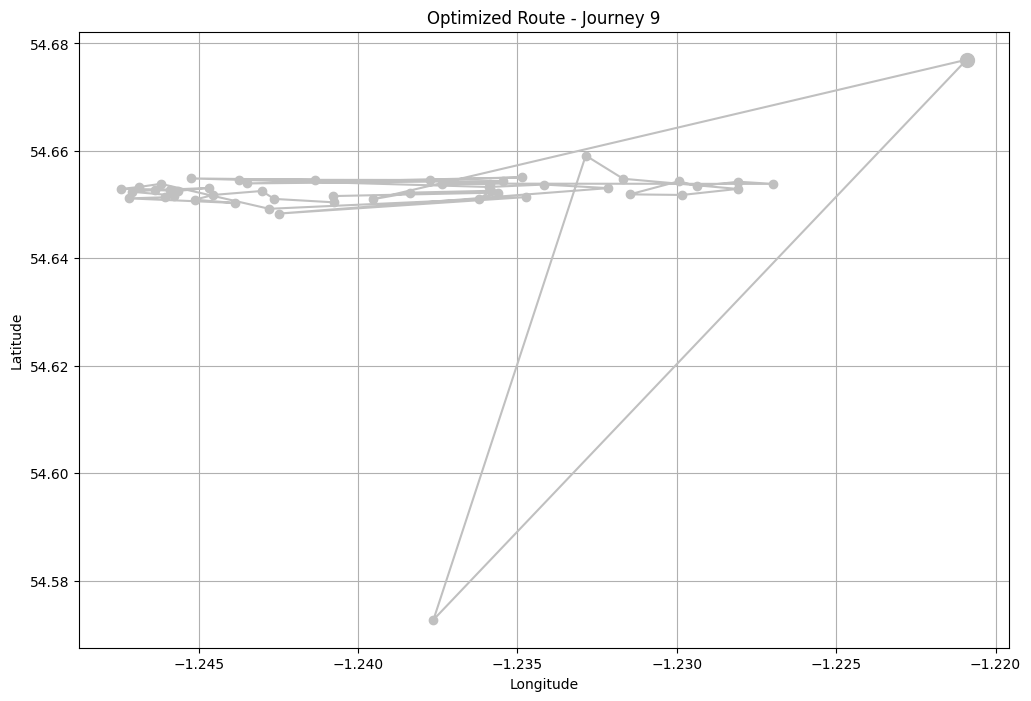

In [ ]:
thu_27_location_depot_unique['Departure_postcode'] = thu_27_location_depot_unique['Departure_postcode'].str.strip()

route_x = [thu_27_location_depot_unique[thu_27_location_depot_unique['Departure_postcode'] == postcode]['D_Longitude'].values[0] for postcode in result9["route"]]
route_y = [thu_27_location_depot_unique[thu_27_location_depot_unique['Departure_postcode'] == postcode]['D_Latitude'].values[0] for postcode in result9["route"]]

# Plot
plt.figure(figsize=(12,8))
plt.plot(route_x, route_y, marker='o', c='silver', markerfacecolor='silver')

# Highlight the point corresponding to the postcode 'TS255QW' in green and make it bigger
plt.scatter(dep_lon, dep_lat, c='silver', s=100, label='Start Point', zorder=5)

plt.title('Optimized Route - Journey 9')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.savefig("Optimized Route - Journey 9.png")
plt.show()

Journey 10

In [ ]:
waiting_times_10 = waiting_times_dict['waiting_times_df_10'].set_index('Departure_postcode')['Waiting time'].to_dict()


In [ ]:
df_10_d = df_10.T.drop_duplicates().T
df_10_d = df_10_d.drop_duplicates()


In [ ]:
result10 = solve_routing_problem(df_10_d, start_postcode, next_postcode, end_postcode,waiting_times_10)
print(result10["title"])
print("Route:", ', '.join(result10["route"]))

Routing Result
Route: TS255QW, TS13RA, TS268NW, TS254NX, TS251UP, TS248RG, TS248QU, TS248QQ, TS248QH, TS248PQ, TS248PJ, TS248PH, TS248PB, TS248PA, TS248NX, TS248NW, TS248NU, TS248NN, TS248NL, TS248NJ, TS248NH, TS248NF, TS248NE, TS248LT, TS248LR, TS248LP, TS248LH, TS248LG, TS248LA, TS248JQ, TS248JP, TS248JN, TS248JL, TS248JJ, TS248JG, TS248JF, TS248JE, TS248JD, TS248JA, TS248HZ, TS248HS, TS248HR, TS248HN, TS248HL, TS248HH, TS248HG, TS248GZ, TS248GY, TS248GX, TS248EX, TS248EQ, TS248ED, TS248DR, TS255QW


In [ ]:
time_matrix10 = df_10_d.values
route_indices10 = [df_10_d.columns.get_loc(code) for code in result10['route']]

# Extract travel times from the time matrix for the determined route
travel_times10 = time_matrix10[route_indices10[:-1], route_indices10[1:]]

# Extract waiting times for each postcode in the determined route (except the last one)
waiting_times_route10 = [waiting_times_10.get(result10['route'][i], 0) for i in range(len(result10['route']) - 1)]

# Combine travel times and waiting times
total_times10 = travel_times10 + np.array(waiting_times_route10)

total_time10 = np.sum(total_times10)
print("Total Waiting Time:", sum(np.array(waiting_times_route10)), "minutes")
print("Total Driving Time:", sum(travel_times10), "minutes")
print("Total Travel Time:", total_time10, "minutes")
print("Total Travel Time:", total_time10/60, "hours")

Total Waiting Time: 302 minutes
Total Driving Time: 183.083333332 minutes
Total Travel Time: 485.08333333199994 minutes
Total Travel Time: 8.084722222199998 hours


In [ ]:
waiting_time_10_dt = convert_minutes_to_time(sum(np.array(waiting_times_route10)))
driving_time_10_dt = convert_minutes_to_time(sum(travel_times10))
total_time_10_dt = convert_minutes_to_time(total_time10)

print("Total Waiting Time:", waiting_time_10_dt)
print("Total Driving Time:", driving_time_10_dt)
print("Total Travel Time:", total_time_10_dt)


Total Waiting Time: 05:02:00
Total Driving Time: 03:03:04
Total Travel Time: 08:05:04


Journey 10: Data Visualization

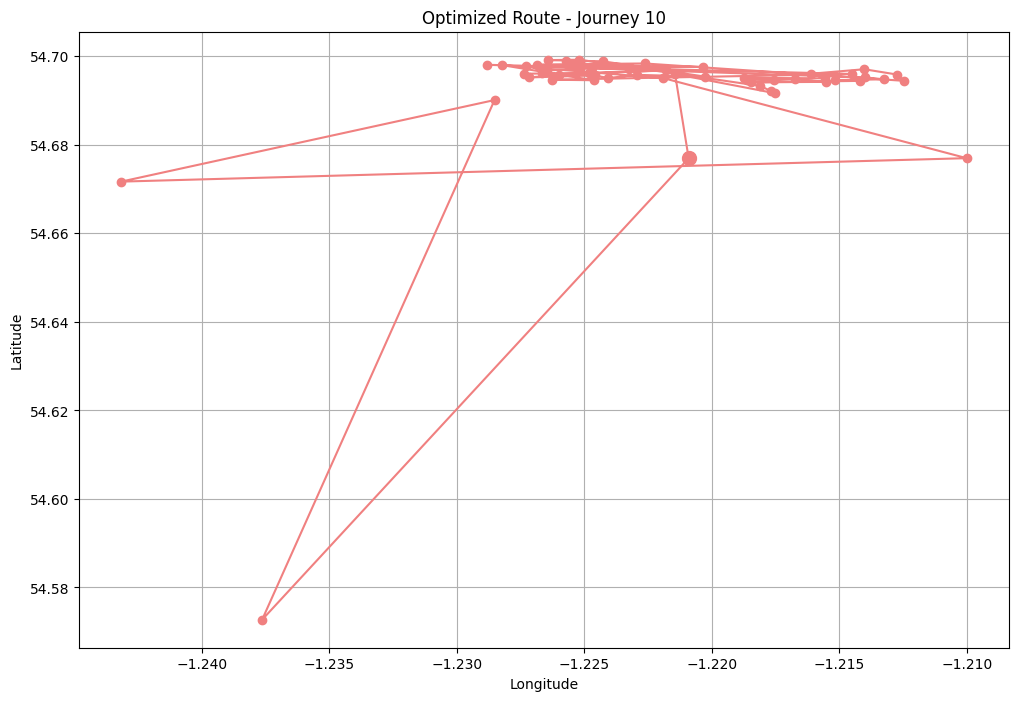

In [ ]:
fri_28_location_depot_unique['Departure_postcode'] = fri_28_location_depot_unique['Departure_postcode'].str.strip()

route_x = [fri_28_location_depot_unique[fri_28_location_depot_unique['Departure_postcode'] == postcode]['D_Longitude'].values[0] for postcode in result10["route"]]
route_y = [fri_28_location_depot_unique[fri_28_location_depot_unique['Departure_postcode'] == postcode]['D_Latitude'].values[0] for postcode in result10["route"]]

# Plot
plt.figure(figsize=(12,8))
plt.plot(route_x, route_y, marker='o', c='lightcoral', markerfacecolor='lightcoral')

# Highlight the point corresponding to the postcode 'TS255QW' in green and make it bigger
plt.scatter(dep_lon, dep_lat, c='lightcoral', s=100, label='Start Point', zorder=5)


plt.title('Optimized Route - Journey 10')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)

# Save the plot as a PNG file
plt.savefig("Optimized Route - Journey 10.png")

plt.show()

# Optimization with driver working hour

In [ ]:
from ortools.constraint_solver import routing_enums_pb2, pywrapcp
import numpy as np

def solve_routing_problem(df, start_postcode, next_postcode, end_postcode, waiting_times):

    # Get indices
    start_index = df.columns.get_loc(start_postcode)
    next_index = df.columns.get_loc(next_postcode)
    end_index = df.columns.get_loc(end_postcode)

    # Extract time matrix from dataframe
    time_matrix = df.values.tolist()

    def create_data_model():
        data = {}
        data["time_matrix"] = time_matrix
        data["num_vehicles"] = 1
        data["depot"] = start_index
        return data

    data = create_data_model()
    manager = pywrapcp.RoutingIndexManager(len(data["time_matrix"]), data["num_vehicles"], data["depot"])
    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(from_index, to_index):
        node = manager.IndexToNode(from_index)
        postcode = df.columns[node]
        waiting_time = waiting_times.get(postcode, 0)
        return data["time_matrix"][node][manager.IndexToNode(to_index)] + waiting_time

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)
    routing.NextVar(routing.Start(0)).RemoveValues([i for i in range(len(data["time_matrix"])) if i != next_index])

    # Create and register a transit callback for time dimension
    time_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define the capacity for each vehicle, which in this case is 540 minutes
    vehicle_time_horizon = 540  # 9 hours * 60 minutes/hour

    # Add dimension for time
    routing.AddDimension(
        time_callback_index,
        vehicle_time_horizon,  # allow waiting time
        vehicle_time_horizon,  # maximum time per vehicle
        True,  # Force start cumul to zero.
        'Time'
    )

    time_dimension = routing.GetDimensionOrDie('Time')
    penalty = 100000  # large penalty to heavily penalize exceeding the working hours
    time_dimension.SetCumulVarSoftUpperBound(routing.Start(0), vehicle_time_horizon, penalty)
    time_dimension.SetCumulVarSoftUpperBound(routing.End(0), vehicle_time_horizon, penalty)

    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC

    solution = routing.SolveWithParameters(search_parameters)
    if not solution:
        return "No solution found!"

    route = []
    travel_time = 0
    index = routing.Start(0)
    previous_index = index
    while not routing.IsEnd(index):
        route.append(df.columns[manager.IndexToNode(index)])
        travel_time += routing.GetArcCostForVehicle(previous_index, index, 0)
        previous_index = index
        index = solution.Value(routing.NextVar(index))
    route.append(df.columns[manager.IndexToNode(index)])
    travel_time += routing.GetArcCostForVehicle(previous_index, index, 0)

    # Post-processing step to trim the route if total time exceeds 9 hours
    route_indices = [df.columns.get_loc(code) for code in route]
    travel_times = [time_matrix[route_indices[i]][route_indices[i+1]] for i in range(len(route_indices)-1)]
    waiting_times_route = [waiting_times.get(route[i], 0) for i in range(len(route) - 1)]
    total_times = travel_times + np.array(waiting_times_route)
    total_time1 = np.sum(total_times)

    if total_time1 > 9 * 60:  # 9 hours converted to minutes
        trimmed_route = route[:-2]  # Exclude the last depot which is the end depot
        while total_time1 > 9 * 60 and len(trimmed_route) > 1:  # Ensure at least start and end depots remain
            trimmed_route = trimmed_route[:-1]

            # Recompute the total travel time for the trimmed route
            route_indices = [df.columns.get_loc(code) for code in trimmed_route + [end_postcode]]
            travel_times_trimmed = [time_matrix[route_indices[i]][route_indices[i+1]] for i in range(len(route_indices)-1)]
            waiting_times_route_trimmed = [waiting_times.get(trimmed_route[i], 0) for i in range(len(trimmed_route))]
            total_times_trimmed = travel_times_trimmed + np.array(waiting_times_route_trimmed)
            total_time1 = np.sum(total_times_trimmed)

        route = trimmed_route + [end_postcode]

    result = {
        "title": f"Routing Result",
        "route": route,
    }

    return result

In [ ]:
def convert_minutes_to_time(minutes):
    hours, remainder_minutes = divmod(minutes, 60)
    return f"{int(hours)}:{int(remainder_minutes):02} hours"


In [ ]:
def report_routing(number, df, start_postcode, next_postcode, end_postcode, waiting_times):
    result_var_name = f"result{number}"
    time_matrix_var_name = f"time_matrix{number}"
    route_indices_var_name = f"route_indices{number}"
    travel_times_var_name = f"travel_times{number}"
    waiting_times_route_var_name = f"waiting_times_route{number}"
    total_times_var_name = f"total_times{number}"
    total_time_var_name = f"total_time{number}"
    all_depot_var_name = f"all_depot{number}"
    depot_arrived_var_name = f"depot_arrived{number}"
    missed_depots_var_name = f"missed_depots{number}"

    result = solve_routing_problem(df, start_postcode, next_postcode, end_postcode, waiting_times)
    print(result["title"])
    print("Route:", ', '.join(result["route"]))

    time_matrix = df.values
    route_indices = [df.columns.get_loc(code) for code in result['route']]

    # Extract travel times from the time matrix for the determined route
    travel_times = time_matrix[route_indices[:-1], route_indices[1:]]

    # Extract waiting times for each postcode in the determined route (except the last one)
    waiting_times_route = [waiting_times.get(result['route'][i], 0) for i in range(len(result['route']) - 1)]

    # Combine travel times and waiting times
    total_times = travel_times + np.array(waiting_times_route)
    total_time = np.sum(total_times)

    # Convert times to hh:mm format
    Dwaiting_time_dt = convert_minutes_to_time(sum(np.array(waiting_times_route)))
    Ddriving_time_dt = convert_minutes_to_time(sum(travel_times))
    Dtotal_time_dt = convert_minutes_to_time(total_time)

    print("Total Waiting Time:", Dwaiting_time_dt)
    print("Total Driving Time:", Ddriving_time_dt)
    print("Total Travel Time:", Dtotal_time_dt)

    all_depot = len(df)
    print(f"Number of all locations: {all_depot}")
    depot_arrived = len(result["route"]) - (1 if result["route"][0] == result["route"][-1] else 0)
    print(f"Number of Arrival location: {depot_arrived}")
    missed_depots = len(df.columns) - (len(result["route"]) - 1)
    print(f"Number of location missed: {missed_depots}")

    return {
        result_var_name: result,
        time_matrix_var_name: time_matrix,
        route_indices_var_name: route_indices,
        travel_times_var_name: travel_times,
        waiting_times_route_var_name: waiting_times_route,
        total_times_var_name: total_times,
        total_time_var_name: total_time,
        all_depot_var_name: all_depot,
        depot_arrived_var_name: depot_arrived,
        missed_depots_var_name: missed_depots
    }

**Routing optimization with working hour regulation**

In [ ]:
def print_and_report(num, df, start_postcode, next_postcode, end_postcode, waiting_times):
    print(f"Report for journey {num}:")
    print("-----------------------------------------------------------------------------------")
    results = report_routing(num, df, start_postcode, next_postcode, end_postcode, waiting_times)
    print("-----------------------------------------------------------------------------------")
    return results

results1 = print_and_report(1, df_1, start_postcode, next_postcode, end_postcode, waiting_times_1)
results2 = print_and_report(2, df_2, start_postcode, next_postcode, end_postcode, waiting_times_2)
results3 = print_and_report(3, df_3, start_postcode, next_postcode, end_postcode, waiting_times_3)
results4 = print_and_report(4, df_4, start_postcode, next_postcode, end_postcode, waiting_times_4)
results5 = print_and_report(5, df_5_sp, start_postcode, next_postcode, end_postcode, waiting_times_5)
results6 = print_and_report(6, df_6, start_postcode, next_postcode, end_postcode, waiting_times_6)
results7 = print_and_report(7, df_7, start_postcode, next_postcode, end_postcode, waiting_times_7)
results8 = print_and_report(8, df_8, start_postcode, next_postcode, end_postcode, waiting_times_8)
results9 = print_and_report(9, df_9, start_postcode, next_postcode, end_postcode, waiting_times_9)
results10 = print_and_report(10, df_10_d, start_postcode, next_postcode, end_postcode, waiting_times_10)


Report for journey 1:
-----------------------------------------------------------------------------------
Routing Result
Route: TS255QW, TS13RA, TS260HH, TS260HG, TS255RJ, TS255QH, TS255QF, TS255QE, TS255QA, TS255PY, TS255PU, TS255PT, TS255PS, TS255PL, TS255PJ, TS255PD, TS255PB, TS255PA, TS255NZ, TS255NX, TS255NU, TS255NS, TS255NR, TS255NQ, TS255ND, TS255LX, TS255LT, TS255EF, TS254PR, TS254PF, TS254PD, TS254NY, TS254NX, TS254NU, TS254NT, TS254NR, TS254NP, TS254NN, TS254NL, TS254NJ, TS254NE, TS254NA, TS254LQ, TS254LN, TS254LJ, TS254LH, TS254LG, TS254LF, TS254LE, TS254JU, TS254JT, TS254JN, TS254JH, TS254JG, TS254JE, TS255QW
Total Waiting Time: 6:21 hours
Total Driving Time: 2:32 hours
Total Travel Time: 8:53 hours
Number of all locations: 63
Number of Arrival location: 55
Number of location missed: 8
-----------------------------------------------------------------------------------
Report for journey 2:
-----------------------------------------------------------------------------------


# Traffic congestion information

In [ ]:
pip install pyexcel-ods3


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 973.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 kB 4.4 MB/s eta 0:00:00


In [ ]:
pip install ezodf


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.9/125.9 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ezodf: filename=ezodf-0.3.2-py2.py3-none-any.whl size=49002 sha256=9589d94efba546445f12ce786037eb1866ac9b00e5940dc615aecee669fde953
  Stored in directory: /root/.cache/pip/wheels/50/09/62/ea2c44e6ffdd067d6c8d3f557af0734a195bd252d6901f23ca
Successfully built ezodf


In [ ]:
import ezodf

In [ ]:
def read_ods(filename, sheet_no=0, sheet_name=None):
    # Load the ODS file
    doc = ezodf.opendoc(filename)

    # If a sheet name is provided, use that sheet
    if sheet_name:
        sheet = doc.sheets[sheet_name]
    # Otherwise, use the sheet number
    else:
        sheet = doc.sheets[sheet_no]

    # Convert the sheet content to a Pandas DataFrame
    df_dict = {}
    for i, row in enumerate(sheet.rows()):
        # row is a list of cells
        # - cell.value could be 'string', 'float', 'date', 'time', 'percentage', 'currency' or 'boolean'
        df_dict[i] = [cell.value for cell in row]
    df = pd.DataFrame(df_dict).T

    return df

# Example usage:
filename = 'tra0308.ods'
sheetname = 'TRA0308'
df = read_ods(filename, sheet_name=sheetname)


In [ ]:
traffic = df

In [ ]:
# Change row 4 to be the column names
traffic.columns = traffic.iloc[4]

In [ ]:
# Drop columns "Notes", "Units", "Saturday", "Sunday"
columns_to_drop = ["Notes", "Units", "Saturday", "Sunday", "Vehicle"]
traffic.drop(columns=columns_to_drop + [traffic.columns[-1]], axis=1, inplace=True)

# Drop rows with NaN values
traffic.dropna(inplace=True)

# Drop row 4
traffic.drop(index=4, inplace=True)

# Change the "Year" column to integer type
traffic['Year'] = traffic['Year'].astype(int)

In [ ]:
traffic.columns

Index(['Year', 'Time of Day', 'Monday', 'Tuesday', 'Wednesday', 'Thursday',
       'Friday'],
      dtype='object', name=4)

In [ ]:
# Group by year and time of the day, summing other columns except "Vehicle"
grouped = traffic.groupby(['Year', 'Time of Day']).sum().reset_index()

# Display the resulting DataFrame
grouped

4    Year     Time of Day Monday Tuesday Wednesday Thursday Friday
0    2008  00:00 to 01:00   16.0    12.0      12.0     14.0   15.0
1    2008  01:00 to 02:00    9.0     7.0       7.0      7.0    8.0
2    2008  02:00 to 03:00    6.0     5.0       5.0      5.0    6.0
3    2008  03:00 to 04:00    7.0     6.0       5.0      6.0    7.0
4    2008  04:00 to 05:00   14.0    10.0       9.0     10.0   11.0
..    ...             ...    ...     ...       ...      ...    ...
355  2022  19:00 to 20:00  262.1   281.0     291.7    304.6  298.2
356  2022  20:00 to 21:00  187.6   198.5     207.5    219.2  213.3
357  2022  21:00 to 22:00  140.2   149.7     155.9    164.9  160.9
358  2022  22:00 to 23:00  102.0   113.1     118.1    123.4  127.5
359  2022  23:00 to 00:00   71.3    77.5      81.6     86.5   96.1

[360 rows x 7 columns]

In [ ]:
grouped = grouped.drop('Year', axis=1)


In [ ]:
grouped

4       Time of Day Monday Tuesday Wednesday Thursday Friday
0    00:00 to 01:00   16.0    12.0      12.0     14.0   15.0
1    01:00 to 02:00    9.0     7.0       7.0      7.0    8.0
2    02:00 to 03:00    6.0     5.0       5.0      5.0    6.0
3    03:00 to 04:00    7.0     6.0       5.0      6.0    7.0
4    04:00 to 05:00   14.0    10.0       9.0     10.0   11.0
..              ...    ...     ...       ...      ...    ...
355  19:00 to 20:00  262.1   281.0     291.7    304.6  298.2
356  20:00 to 21:00  187.6   198.5     207.5    219.2  213.3
357  21:00 to 22:00  140.2   149.7     155.9    164.9  160.9
358  22:00 to 23:00  102.0   113.1     118.1    123.4  127.5
359  23:00 to 00:00   71.3    77.5      81.6     86.5   96.1

[360 rows x 6 columns]

In [ ]:
# Convert numeric columns to appropriate data types
numeric_columns = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
grouped[numeric_columns] = grouped[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Group by 'Time of Day' and calculate the mean for each weekday
grouped2 = grouped.groupby('Time of Day')[numeric_columns].mean().reset_index()

# Display the resulting DataFrame
grouped2


4      Time of Day      Monday     Tuesday   Wednesday    Thursday      Friday
0   00:00 to 01:00   27.746667   30.960000   32.686667   34.013333   36.580000
1   01:00 to 02:00   20.086667   24.700000   25.706667   26.693333   28.393333
2   02:00 to 03:00   18.626667   23.660000   24.493333   25.280000   26.406667
3   03:00 to 04:00   23.980000   28.240000   28.746667   29.706667   30.240000
4   04:00 to 05:00   44.420000   45.246667   45.246667   45.973333   45.513333
5   05:00 to 06:00  102.640000   99.346667   98.746667   98.560000   93.926667
6   06:00 to 07:00  219.193333  221.726667  220.246667  218.366667  202.246667
7   07:00 to 08:00  355.373333  369.240000  368.886667  365.853333  339.046667
8   08:00 to 09:00  378.106667  394.400000  395.193333  393.606667  367.366667
9   09:00 to 10:00  316.906667  327.360000  329.120000  329.540000  317.826667
10  10:00 to 11:00  305.213333  302.486667  305.180000  309.053333  320.066667
11  11:00 to 12:00  312.000000  304.360000  308.540000  314.026667  336.993333
12  12:00 to 13:00  312.186667  307.066667  312.326667  318.706667  349.380000
13  13:00 to 14:00  312.673333  311.400000  317.460000  324.006667  356.600000
14  14:00 to 15:00  324.700000  328.266667  335.220000  341.573333  371.153333
15  15:00 to 16:00  349.506667  359.313333  366.373333  371.973333  390.926667
16  16:00 to 17:00  373.953333  388.773333  393.420000  396.180000  386.826667
17  17:00 to 18:00  357.673333  373.106667  377.760000  379.360000  357.260000
18  18:00 to 19:00  265.406667  282.373333  289.500000  296.453333  286.813333
19  19:00 to 20:00  178.260000  189.073333  197.326667  208.253333  214.773333
20  20:00 to 21:00  124.973333  130.346667  136.946667  147.440000  152.620000
21  21:00 to 22:00   92.786667   97.853333  102.093333  109.413333  110.833333
22  22:00 to 23:00   66.733333   73.633333   76.686667   80.593333   85.113333
23  23:00 to 00:00   45.500000   49.485714   52.221429   55.635714   64.200000

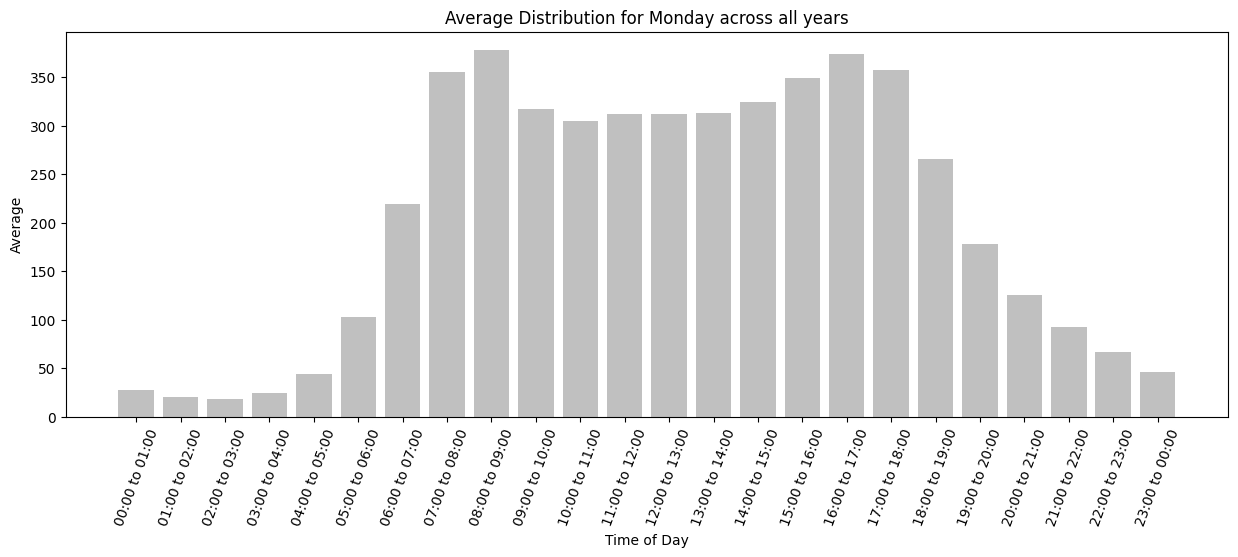

Plot saved as histogram_Monday.png


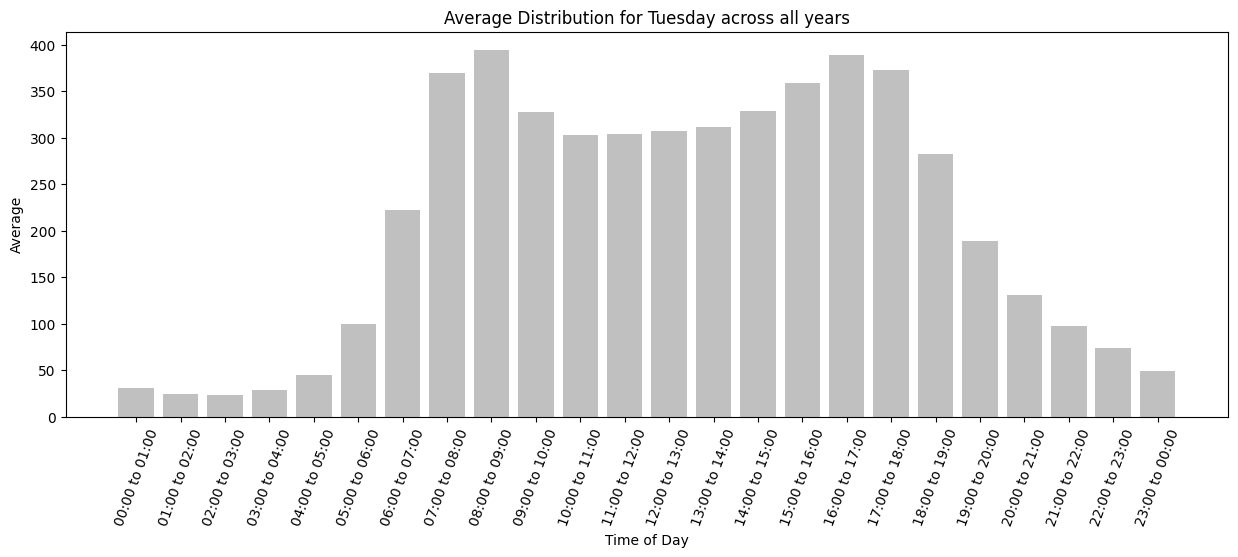

Plot saved as histogram_Tuesday.png


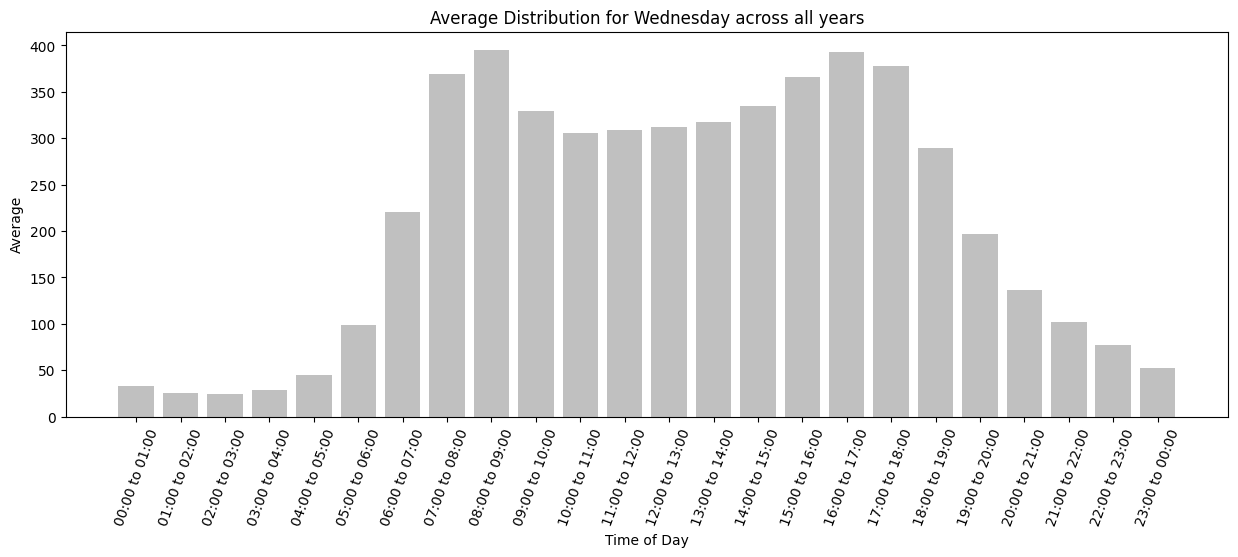

Plot saved as histogram_Wednesday.png


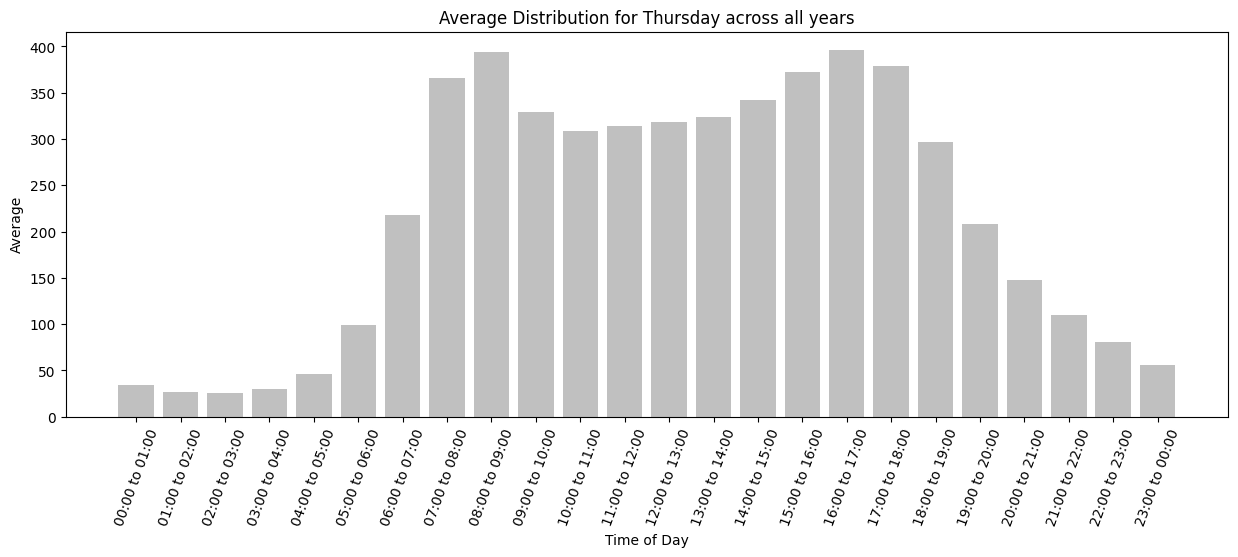

Plot saved as histogram_Thursday.png


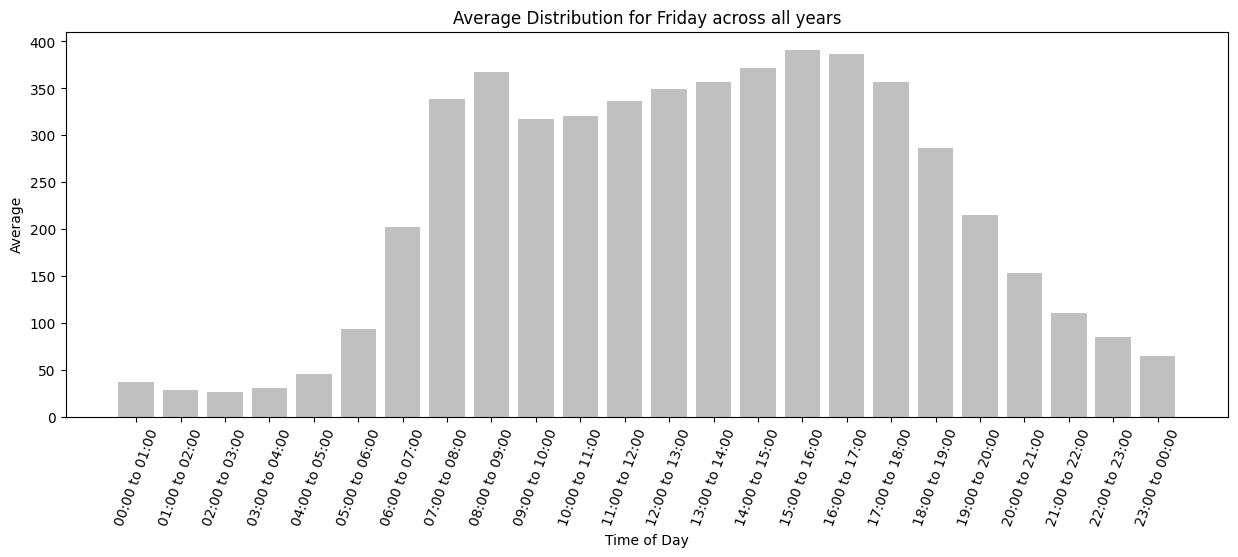

Plot saved as histogram_Friday.png


In [ ]:
import matplotlib.pyplot as plt

# Group by Time of Day and average the weekday columns
sum = grouped2.groupby('Time of Day').sum().reset_index()
colors = {
    'Monday': 'silver',
    'Tuesday': 'silver',
    'Wednesday': 'silver',
    'Thursday': 'silver',
    'Friday': 'silver'
}

# Create histograms for each weekday and save as PNG files
for weekday in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']:
    plt.figure(figsize=(15, 5))
    plt.bar(grouped2['Time of Day'], grouped2[weekday], color=colors[weekday])
    plt.title(f'Average Distribution for {weekday} across all years')
    plt.xlabel('Time of Day')
    plt.ylabel('Average')
    plt.xticks(rotation=70)

    # Save the plot as a PNG file
    filename = f'histogram_{weekday}.png'
    plt.savefig(filename)

    # Display the plot
    plt.show()

    print(f'Plot saved as {filename}')


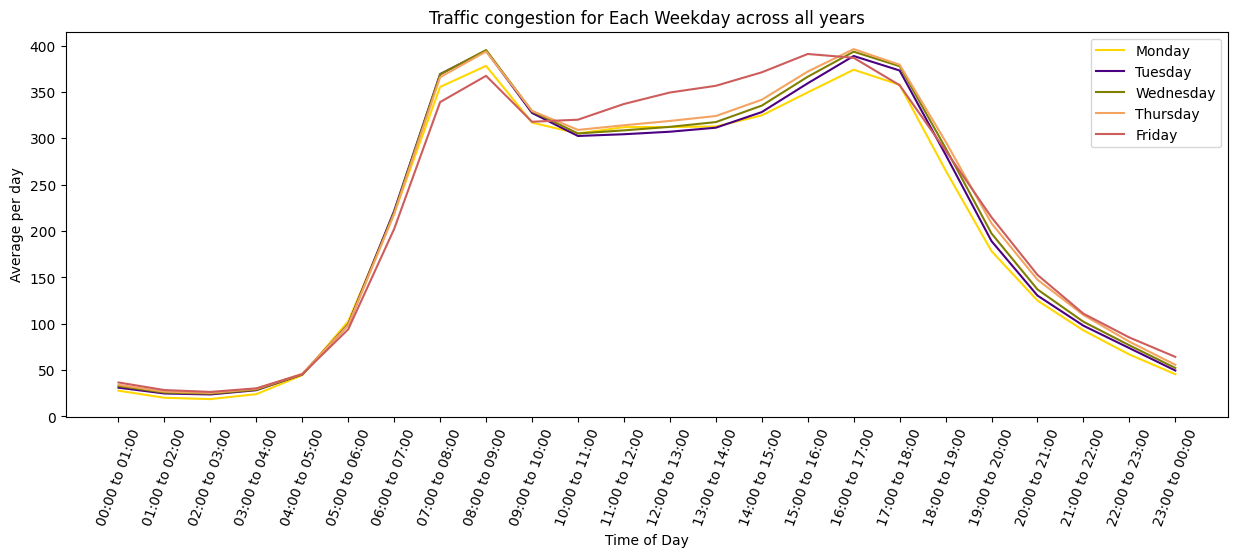

Plot saved as average_weekday_distribution.png


In [ ]:
import matplotlib.pyplot as plt

# Group by Time of Day and average the weekday columns
sum = grouped2.groupby('Time of Day').sum().reset_index()
colors = {
    'Monday': 'gold',
    'Tuesday': 'indigo',
    'Wednesday': 'olive',
    'Thursday': 'sandybrown',
    'Friday': 'indianred'
}

plt.figure(figsize=(15, 5))

# Create line plots for each weekday
for weekday in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']:
    plt.plot(grouped2['Time of Day'], grouped2[weekday], label=weekday, color=colors[weekday])

plt.title('Traffic congestion for Each Weekday across all years')
plt.xlabel('Time of Day')
plt.ylabel('Average per day')
plt.xticks(rotation=70)
plt.legend()

# Save the plot as a PNG file
filename = 'average_weekday_distribution.png'
plt.savefig(filename)

# Display the plot
plt.show()

print(f'Plot saved as {filename}')


In [ ]:

# List of weekdays
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

# Convert non-numeric values in the data to NaN
grouped2[weekdays] = grouped2[weekdays].apply(pd.to_numeric, errors='coerce')

# Replace NaN values with some placeholder or drop them;
grouped2 = grouped2.fillna(0)

In [ ]:
grouped2

4      Time of Day      Monday     Tuesday   Wednesday    Thursday      Friday
0   00:00 to 01:00   27.746667   30.960000   32.686667   34.013333   36.580000
1   01:00 to 02:00   20.086667   24.700000   25.706667   26.693333   28.393333
2   02:00 to 03:00   18.626667   23.660000   24.493333   25.280000   26.406667
3   03:00 to 04:00   23.980000   28.240000   28.746667   29.706667   30.240000
4   04:00 to 05:00   44.420000   45.246667   45.246667   45.973333   45.513333
5   05:00 to 06:00  102.640000   99.346667   98.746667   98.560000   93.926667
6   06:00 to 07:00  219.193333  221.726667  220.246667  218.366667  202.246667
7   07:00 to 08:00  355.373333  369.240000  368.886667  365.853333  339.046667
8   08:00 to 09:00  378.106667  394.400000  395.193333  393.606667  367.366667
9   09:00 to 10:00  316.906667  327.360000  329.120000  329.540000  317.826667
10  10:00 to 11:00  305.213333  302.486667  305.180000  309.053333  320.066667
11  11:00 to 12:00  312.000000  304.360000  308.540000  314.026667  336.993333
12  12:00 to 13:00  312.186667  307.066667  312.326667  318.706667  349.380000
13  13:00 to 14:00  312.673333  311.400000  317.460000  324.006667  356.600000
14  14:00 to 15:00  324.700000  328.266667  335.220000  341.573333  371.153333
15  15:00 to 16:00  349.506667  359.313333  366.373333  371.973333  390.926667
16  16:00 to 17:00  373.953333  388.773333  393.420000  396.180000  386.826667
17  17:00 to 18:00  357.673333  373.106667  377.760000  379.360000  357.260000
18  18:00 to 19:00  265.406667  282.373333  289.500000  296.453333  286.813333
19  19:00 to 20:00  178.260000  189.073333  197.326667  208.253333  214.773333
20  20:00 to 21:00  124.973333  130.346667  136.946667  147.440000  152.620000
21  21:00 to 22:00   92.786667   97.853333  102.093333  109.413333  110.833333
22  22:00 to 23:00   66.733333   73.633333   76.686667   80.593333   85.113333
23  23:00 to 00:00   45.500000   49.485714   52.221429   55.635714   64.200000

In [ ]:
# Create an empty dataframe to store results
stats_df = pd.DataFrame(columns=['Day', 'Mean', 'Median', 'Mode', 'Standard Deviation', 'Skewness', 'Kurtosis'])

for weekday in weekdays:
    data = grouped2[weekday]

    # Calculating metrics
    mean = data.mean()
    median = data.median()
    mode = data.mode().get(0, "N/A")  # Gets the first mode or "N/A" if there are no modes
    std_dev = data.std()
    skewness = data.skew()
    kurtosis = data.kurtosis()

    # Append to results dataframe
    stats_df = stats_df.append({'Day': weekday,
                                'Mean': mean,
                                'Median': median,
                                'Mode': mode,
                                'Standard Deviation': std_dev,
                                'Skewness': skewness,
                                'Kurtosis': kurtosis},
                               ignore_index=True)


In [ ]:
stats_df

Day        Mean      Median       Mode  Standard Deviation  Skewness  \
0     Monday  205.360278  242.300000  18.626667          137.403696 -0.193583   
1    Tuesday  210.934127  252.050000  23.660000          139.526204 -0.162836   
2  Wednesday  214.172004  254.873333  24.493333          140.564646 -0.175721   
3   Thursday  217.510933  257.410000  25.280000          140.798117 -0.202720   
4     Friday  219.629444  250.793333  26.406667          140.991112 -0.217199   

   Kurtosis  
0 -1.769165  
1 -1.734154  
2 -1.733948  
3 -1.728461  
4 -1.773321

In [ ]:
grouped_aj = grouped2
grouped_aj['Time of Day'] = grouped_aj['Time of Day'].str[:5]
grouped_aj = grouped_aj.iloc[6:18].copy()
grouped_aj

4  Time of Day      Monday     Tuesday   Wednesday    Thursday      Friday
6        06:00  219.193333  221.726667  220.246667  218.366667  202.246667
7        07:00  355.373333  369.240000  368.886667  365.853333  339.046667
8        08:00  378.106667  394.400000  395.193333  393.606667  367.366667
9        09:00  316.906667  327.360000  329.120000  329.540000  317.826667
10       10:00  305.213333  302.486667  305.180000  309.053333  320.066667
11       11:00  312.000000  304.360000  308.540000  314.026667  336.993333
12       12:00  312.186667  307.066667  312.326667  318.706667  349.380000
13       13:00  312.673333  311.400000  317.460000  324.006667  356.600000
14       14:00  324.700000  328.266667  335.220000  341.573333  371.153333
15       15:00  349.506667  359.313333  366.373333  371.973333  390.926667
16       16:00  373.953333  388.773333  393.420000  396.180000  386.826667
17       17:00  357.673333  373.106667  377.760000  379.360000  357.260000

In [ ]:
# Scale values for each weekday
scaled_values = {}

for weekday in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']:
    average_value_for_day = grouped_aj[weekday].mean()

    # Scale each "Time of Day" value for this weekday
    scaled_values[weekday] = grouped_aj[weekday] / average_value_for_day

# Convert to DataFrame for better visualization
scaled_data = pd.DataFrame({
    'Time of Day': grouped_aj['Time of Day'],
    **scaled_values
})

scaled_data


Time of Day    Monday   Tuesday  Wednesday  Thursday    Friday
6        06:00  0.671430  0.667265   0.655866  0.645062  0.592564
7        07:00  1.088575  1.111192   1.098496  1.080742  0.993375
8        08:00  1.158212  1.186909   1.176834  1.162726  1.076350
9        09:00  0.970745  0.985159   0.980076  0.973471  0.931203
10       10:00  0.934926  0.910305   0.908786  0.912953  0.937766
11       11:00  0.955715  0.915942   0.918792  0.927644  0.987359
12       12:00  0.956287  0.924088   0.930068  0.941469  1.023651
13       13:00  0.957777  0.937129   0.945354  0.957126  1.044805
14       14:00  0.994617  0.987887   0.998241  1.009018  1.087445
15       15:00  1.070605  1.081319   1.091012  1.098821  1.145379
16       16:00  1.145490  1.169976   1.171553  1.170328  1.133366
17       17:00  1.095621  1.122829   1.124920  1.120641  1.046739

In [ ]:
# Calculate the average of each row (excluding the 'Time of Day' column)
average_per_row = scaled_data.drop('Time of Day', axis=1).mean(axis=1)
scaled_combinedata = scaled_data
# Add the calculated average to the DataFrame
scaled_combinedata['Weekday'] = average_per_row

In [ ]:
scaled_combinedata.drop(columns=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'], inplace=True)
scaled_combinedata

Time of Day   Weekday
6        06:00  0.646437
7        07:00  1.074476
8        08:00  1.152206
9        09:00  0.968131
10       10:00  0.920947
11       11:00  0.941090
12       12:00  0.955112
13       13:00  0.968438
14       14:00  1.015442
15       15:00  1.097427
16       16:00  1.158143
17       17:00  1.102150

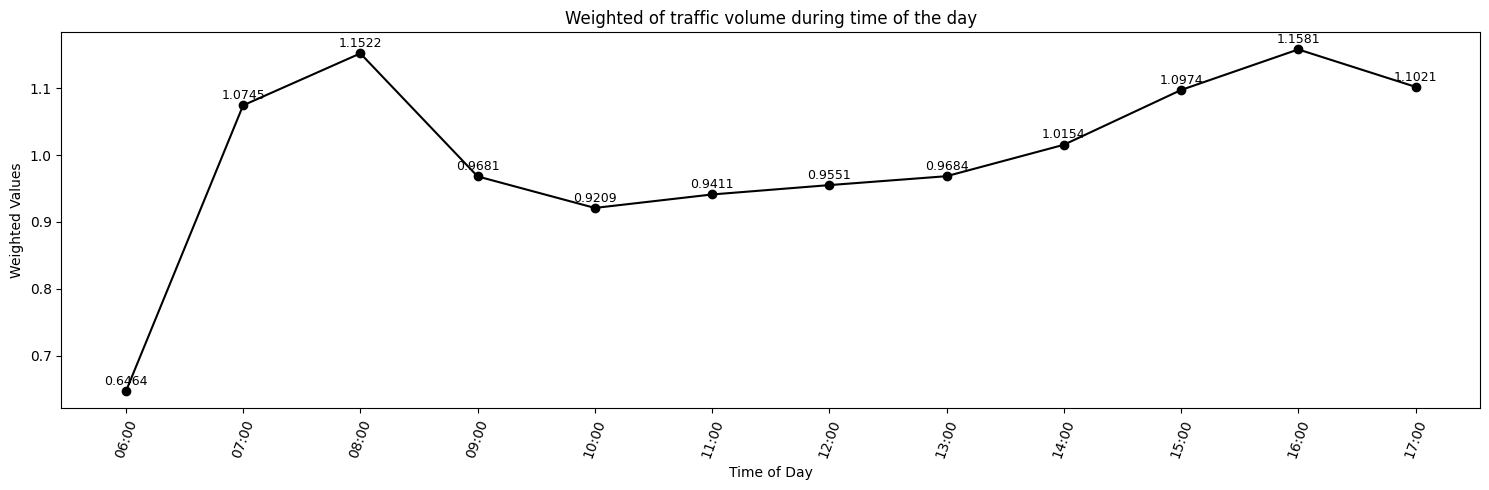

Line graph saved as scaled_combinedata_linegraph.png


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Create the line graph
plt.figure(figsize=(15, 5))
plt.plot(scaled_combinedata['Time of Day'], scaled_combinedata['Weekday'], marker='o', color='black', linestyle='-')

# Add data labels
for i, v in enumerate(scaled_combinedata['Weekday']):
    plt.text(scaled_combinedata['Time of Day'].iloc[i], v + 0.005, "{:.4f}".format(v), ha='center', va='bottom', fontsize=9)

plt.title('Weighted of traffic volume during time of the day')
plt.xlabel('Time of Day')
plt.ylabel('Weighted Values')
plt.xticks(rotation=70)

# Save the line graph as a PNG file
filename = 'scaled_combinedata_linegraph.png'
plt.tight_layout()  # This ensures the labels don't get cut off
plt.savefig(filename)

# Display the line graph
plt.show()

print(f'Line graph saved as {filename}')

# Prep travel time adjusted traffic congestion

In [ ]:
df_1

TS252QF    TS254GZ    TS254HD    TS254HR    TS254HS    TS254HU  \
TS252QF   0.000000   9.083333   7.916667   7.450000   7.316667   7.566667   
TS254GZ   9.016667   0.000000   1.933333   2.633333   2.800000   2.583333   
TS254HD   7.916667   1.966667   0.000000   2.316667   2.316667   2.433333   
TS254HR   7.466667   2.633333   2.283333   0.000000   1.166667   0.783333   
TS254HS   7.333333   2.800000   2.283333   1.166667   0.000000   1.283333   
...            ...        ...        ...        ...        ...        ...   
TS255QW   8.833333   4.533333   3.000000   4.533333   4.533333   4.650000   
TS255RJ   7.816667   4.000000   2.833333   3.850000   3.850000   3.966667   
TS260HG  12.400000   6.450000   4.983333   6.800000   6.800000   6.916667   
TS260HH  12.700000   6.750000   5.283333   7.100000   7.100000   7.216667   
TS13RA   24.333333  30.900000  29.733333  29.266667  29.133333  29.383333   

           TS254JA    TS254JD    TS254JE    TS254JG  ...    TS255PY  \
TS252QF   8.183333   7.716667   7.550000   7.666667  ...   9.383333   
TS254GZ   2.166667   2.733333   2.700000   2.850000  ...   3.400000   
TS254HD   2.300000   2.583333   2.416667   2.533333  ...   1.900000   
TS254HR   1.400000   0.933333   0.766667   0.866667  ...   3.750000   
TS254HS   1.683333   1.433333   1.266667   1.383333  ...   3.750000   
...            ...        ...        ...        ...  ...        ...   
TS255QW   4.666667   4.800000   4.633333   4.750000  ...   3.133333   
TS255RJ   3.983333   4.116667   3.950000   4.066667  ...   3.000000   
TS260HG   6.783333   7.066667   6.900000   7.016667  ...   6.400000   
TS260HH   7.083333   7.366667   7.200000   7.316667  ...   6.700000   
TS13RA   30.000000  29.533333  29.366667  29.483333  ...  31.200000   

           TS255QA    TS255QE    TS255QF    TS255QH    TS255QW    TS255RJ  \
TS252QF   7.900000   7.866667   8.850000   8.466667   8.466667   7.400000   
TS254GZ   3.550000   3.483333   4.000000   3.650000   4.450000   3.900000   
TS254HD   2.450000   2.383333   2.900000   2.200000   3.000000   2.800000   
TS254HR   3.450000   3.383333   3.900000   3.550000   4.350000   3.800000   
TS254HS   3.450000   3.383333   3.900000   3.550000   4.350000   3.800000   
...            ...        ...        ...        ...        ...        ...   
TS255QW   2.216667   2.066667   3.183333   1.450000   0.000000   1.616667   
TS255RJ   1.183333   1.166667   2.250000   1.666667   1.666667   0.000000   
TS260HG   6.933333   6.866667   7.383333   6.333333   6.150000   6.500000   
TS260HH   7.233333   7.166667   7.683333   6.633333   6.450000   6.800000   
TS13RA   29.466667  29.433333  30.416667  30.033333  30.033333  28.966667   

           TS260HG    TS260HH     TS13RA  
TS252QF  12.400000  12.650000  25.100000  
TS254GZ   6.416667   6.666667  31.350000  
TS254HD   4.983333   5.233333  30.300000  
TS254HR   6.766667   7.016667  29.850000  
TS254HS   6.766667   7.016667  29.716667  
...            ...        ...        ...  
TS255QW   6.200000   6.450000  30.650000  
TS255RJ   6.550000   6.800000  29.633333  
TS260HG   0.000000   1.566667  28.416667  
TS260HH   1.566667   0.000000  29.250000  
TS13RA   30.816667  31.633333   0.000000  

[63 rows x 63 columns]

Location 1

In [ ]:
import pandas as pd
import numpy as np

# Create an empty dictionary to store the new DataFrames
new_mdf1 = {}

# Loop through the indices and generate new DataFrames
for idx in range(6, 18):  # Loop from index 6 to 17
    factor = scaled_combinedata['Weekday'][idx]
    new_matrix1 = df_1 * factor
    new_df1 = pd.DataFrame(new_matrix1, index=df_1.index, columns=df_1.columns)
    new_mdf1[idx] = new_df1

# Access the new DataFrames using keys like new_df1[6], new_df1[7], ...
for idx, new_df in new_mdf1.items():
    print(f"New DataFrame for index {idx}:\n{new_df}\n")


New DataFrame for index 6:
           TS252QF    TS254GZ    TS254HD    TS254HR    TS254HS    TS254HU  \
TS252QF   0.000000   5.871807   5.117630   4.815959   4.729767   4.891377   
TS254GZ   5.828711   0.000000   1.249779   1.702285   1.810025   1.669963   
TS254HD   5.117630   1.271327   0.000000   1.497580   1.497580   1.572998   
TS254HR   4.826733   1.702285   1.476032   0.000000   0.754177   0.506376   
TS254HS   4.740541   1.810025   1.476032   0.754177   0.000000   0.829595   
...            ...        ...        ...        ...        ...        ...   
TS255QW   5.710197   2.930516   1.939312   2.930516   2.930516   3.005934   
TS255RJ   5.052986   2.585750   1.831573   2.488784   2.488784   2.564202   
TS260HG   8.015824   4.169521   3.221413   4.395775   4.395775   4.471192   
TS260HH   8.209755   4.363453   3.415344   4.589706   4.589706   4.665123   
TS13RA   15.729978  19.974917  19.220740  18.919069  18.832877  18.994487   

           TS254JA    TS254JD    TS254JE    TS25

In [ ]:
new_df1_6 = new_mdf1[6]
new_df1_7 = new_mdf1[7]
new_df1_8 = new_mdf1[8]
new_df1_9 = new_mdf1[9]
new_df1_10 = new_mdf1[10]
new_df1_11 = new_mdf1[11]
new_df1_12 = new_mdf1[12]
new_df1_13 = new_mdf1[13]
new_df1_14 = new_mdf1[14]
new_df1_15 = new_mdf1[15]
new_df1_16 = new_mdf1[16]
new_df1_17 = new_mdf1[17]

Location 2

In [ ]:
# Create an empty dictionary to store the new DataFrames
new_mdf2 = {}

# Loop through the indices and generate new DataFrames
for idx in range(6, 18):  # Loop from index 6 to 17
    factor = scaled_combinedata['Weekday'][idx]
    new_matrix2 = df_2 * factor
    new_df2 = pd.DataFrame(new_matrix2, index=df_2.index, columns=df_2.columns)
    new_mdf2[idx] = new_df2

# Access the new DataFrames using keys like new_df1[6], new_df1[7], ...
for idx, new_df in new_mdf2.items():
    print(f"New DataFrame for index {idx}:\n{new_df}\n")

New DataFrame for index 6:
           TS251UP    TS253DH    TS253EG    TS253EH    TS253EN    TS253EP  \
TS251UP   0.000000   6.421279   6.388957   6.302765   6.604436   6.809141   
TS253DH   6.507470   0.000000   1.023526   0.937334   0.937334   1.195909   
TS253EG   6.442826   1.023526   0.000000   0.646437   0.969656   1.152813   
TS253EH   6.356635   0.937334   0.646437   0.000000   0.700307   0.894238   
TS253EN   6.658306   0.937334   0.969656   0.700307   0.000000   0.937334   
...            ...        ...        ...        ...        ...        ...   
TS254DA   6.162704   1.745381   2.251757   2.165565   2.165565   2.424140   
TS254DB   6.291991   1.960860   2.467236   2.381045   2.381045   2.639620   
TS254EY   6.475148   2.047052   2.553428   2.467236   2.467236   2.725811   
TS255QW   2.973612   5.139178   5.106856   5.020664   5.322335   5.527040   
TS13RA   20.276588  17.518455  17.486133  17.399941  17.701612  17.906317   

           TS253EQ    TS253ET    TS253EU    TS25

In [ ]:
# Create a list of indices
indices = list(range(6, 18))

# Loop through the indices and generate variable assignments
for idx in indices:
    var_name = f"new_df2_{idx}"
    globals()[var_name] = new_mdf2[idx]

# Name: new_df2_6, new_df2_7, ..., new_df2_17

Location 3

In [ ]:
# Create an empty dictionary to store the new DataFrames
new_mdf3 = {}

# Loop through the indices and generate new DataFrames
for idx in range(6, 18):  # Loop from index 6 to 17
    factor = scaled_combinedata['Weekday'][idx]
    new_matrix3 = df_3 * factor
    new_df3 = pd.DataFrame(new_matrix3, index=df_3.index, columns=df_3.columns)
    new_mdf3[idx] = new_df3

# Access the new DataFrames using keys like new_df1[6], new_df1[7], ...
for idx, new_df in new_mdf3.items():
    print(f"New DataFrame for index {idx}:\n{new_df}\n")

New DataFrame for index 6:
           TS251DR    TS251DS    TS251DT    TS251DW    TS251DX    TS251FB  \
TS251DR   0.000000   1.820799   2.187113   2.176339   2.305627   4.191069   
TS251DS   1.756155   0.000000   0.711081   0.732629   1.271327   2.747359   
TS251DT   2.122470   0.711081   0.000000   1.098944   1.637642   3.113674   
TS251DW   2.111696   0.732629   1.066622   0.000000   1.443710   2.381045   
TS251DX   2.273305   1.271327   1.637642   1.443710   0.000000   3.458440   
...            ...        ...        ...        ...        ...        ...   
TS255HR   6.658306   5.279239   5.613232   4.912925   5.990320   3.684693   
TS255QW   6.906107   6.119608   6.453600   5.753293   6.830689   5.106856   
TS255TD   6.485922   5.106856   5.440848   4.740541   5.817937   3.275283   
TS268JL   8.910063   8.123564   8.457556   7.757249   8.834645   7.229325   
TS13RA   19.834855  18.455789  18.789781  18.089474  19.166870  16.624216   

           TS251GH    TS251HB    TS251HD    TS25

In [ ]:
# Create a list of indices
indices = list(range(6, 18))

# Loop through the indices and generate variable assignments
for idx in indices:
    var_name = f"new_df3_{idx}"
    globals()[var_name] = new_mdf3[idx]

# Name: new_df3_6, new_df3_7, ..., new_df3_17


Location 4

In [ ]:
# Create an empty dictionary to store the new DataFrames
new_mdf4 = {}

# Loop through the indices and generate new DataFrames
for idx in range(6, 18):  # Loop from index 6 to 17
    factor = scaled_combinedata['Weekday'][idx]
    new_matrix4 = df_4 * factor
    new_df4 = pd.DataFrame(new_matrix4, index=df_4.index, columns=df_4.columns)
    new_mdf4[idx] = new_df4

# Access the new DataFrames using keys like new_df1[6], new_df1[7], ...
for idx, new_df in new_mdf4.items():
    print(f"New DataFrame for index {idx}:\n{new_df}\n")

New DataFrame for index 6:
           TS251FB    TS254HQ    TS255AR    TS255AS    TS255BP    TS255HS  \
TS251FB   0.000000   5.193047   3.889399   3.997138   4.191069   4.212617   
TS254HQ   5.290013   0.000000   2.682715   2.995160   4.061782   3.232187   
TS255AR   3.997138   2.618072   0.000000   0.700307   1.853121   1.572998   
TS255AS   4.104878   2.962838   0.700307   0.000000   2.014730   1.680737   
TS255BP   4.115652   3.038256   1.185135   1.346745   0.000000   2.047052   
TS255HS   4.352679   3.275283   1.572998   1.680737   3.070578   0.000000   
TS255HT   3.663145   2.036278   1.282101   1.389840   2.434914   1.605320   
TS255HU   4.492740   2.639620   1.831573   1.939312   3.275283   2.208661   
TS255HX   3.975590   1.788477   1.540676   1.669963   2.747359   1.917764   
TS255HY   4.309583   1.648415   1.885443   2.014730   3.081352   2.251757   
TS255HZ   4.859055   2.197887   2.434914   2.564202   3.630824   2.801229   
TS255JA   4.341905   1.982408   1.917764   2.0470

In [ ]:
# Create a list of indices
indices = list(range(6, 18))

# Loop through the indices and generate variable assignments
for idx in indices:
    var_name = f"new_df4_{idx}"
    globals()[var_name] = new_mdf4[idx]

# Name: new_df4_6, new_df4_7, ..., new_df4_17

Location 5

In [ ]:
# Create an empty dictionary to store the new DataFrames
new_mdf5 = {}

# Loop through the indices and generate new DataFrames
for idx in range(6, 18):  # Loop from index 6 to 17
    factor = scaled_combinedata['Weekday'][idx]
    new_matrix5 = df_5_sp * factor
    new_df5 = pd.DataFrame(new_matrix5, index=df_5_sp.index, columns=df_5_sp.columns)
    new_mdf5[idx] = new_df5

# Access the new DataFrames using keys like new_df1[6], new_df1[7], ...
for idx, new_df in new_mdf5.items():
    print(f"New DataFrame for index {idx}:\n{new_df}\n")

New DataFrame for index 6:
           TS255QW     TS30PY     TS38EA     TS38ED     TS38JS     TS38JT  \
TS255QW   0.000000  25.232608  20.890703  21.192374  22.194352  22.054291   
TS30PY   25.340347   0.000000   4.869829   5.537814   4.255713   4.040234   
TS38EA   20.923025   4.815959   0.000000   1.120492   2.348723   1.863895   
TS38ED   21.224696   5.451622   1.109718   0.000000   2.984386   2.499558   
TS38JS   22.399057   4.212617   2.381045   3.049030   0.000000   0.969656   
...            ...        ...        ...        ...        ...        ...   
TS39PL   25.103320   1.357519   4.632802   5.300787   4.018686   3.803207   
TS39PW   25.049451   1.939312   4.578932   5.246917   4.395775   4.104878   
TS39QA   23.325617   2.865873   2.855099   3.523084   2.424140   2.208661   
TS13RA   19.414671   9.761205   5.656328   5.957998   6.475148   6.335087   
TS39AW   22.032743   4.104878   1.562224   2.230209   1.734607   1.249779   

            TS38JY     TS38LA     TS38LJ     TS3

In [ ]:
# Create a list of indices
indices = list(range(6, 18))

# Loop through the indices and generate variable assignments
for idx in indices:
    var_name = f"new_df5_{idx}"
    globals()[var_name] = new_mdf5[idx]

# Name: new_df5_6, new_df5_7, ..., new_df5_17

Location 6

In [ ]:
# Create an empty dictionary to store the new DataFrames
new_mdf6 = {}

# Loop through the indices and generate new DataFrames
for idx in range(6, 18):  # Loop from index 6 to 17
    factor = scaled_combinedata['Weekday'][idx]
    new_matrix6 = df_6 * factor
    new_df6 = pd.DataFrame(new_matrix6, index=df_6.index, columns=df_6.columns)
    new_mdf6[idx] = new_df6

# Access the new DataFrames using keys like new_df1[6], new_df1[7], ...
for idx, new_df in new_mdf6.items():
    print(f"New DataFrame for index {idx}:\n{new_df}\n")

New DataFrame for index 6:
            SR81BZ     SR81EQ     SR81HB     SR81HP     SR81HU     SR81JH  \
SR81BZ    0.000000   2.574976   3.436892   4.126426   4.104878   0.667985   
SR81EQ    2.574976   0.000000   1.950086   2.639620   2.790455   2.801229   
SR81HB    3.436892   1.917764   0.000000   0.969656   1.120492   3.663145   
SR81HP    3.964816   2.445688   0.808047   0.000000   1.206683   4.191069   
SR81HU    4.115652   2.768907   1.131266   1.368293   0.000000   4.341905   
SR81JH    0.667985   2.801229   3.663145   4.352679   4.331131   0.000000   
SR81JJ    0.689533   2.822777   3.684693   4.374227   4.352679   0.452506   
SR81JQ    0.549472   2.682715   3.544632   4.234165   4.212617   0.527924   
SR81JR    3.199865   1.680737   0.711081   1.400614   1.551450   3.426118   
SR81JX    3.178317   1.659189   1.088170   1.777703   1.928538   3.404570   
SR81LB    3.038256   1.519128   0.948108   1.637642   1.788477   3.264509   
SR81LF    2.758133   1.239005   1.465258   2.1547

In [ ]:
# Create a list of indices
indices = list(range(6, 18))

# Loop through the indices and generate variable assignments
for idx in indices:
    var_name = f"new_df6_{idx}"
    globals()[var_name] = new_mdf6[idx]

# Name: new_df6_6, new_df6_7, ..., new_df6_17

Location 7

In [ ]:
# Create an empty dictionary to store the new DataFrames
new_mdf7 = {}

# Loop through the indices and generate new DataFrames
for idx in range(6, 18):  # Loop from index 6 to 17
    factor = scaled_combinedata['Weekday'][idx]
    new_matrix7 = df_7 * factor
    new_df7 = pd.DataFrame(new_matrix7, index=df_7.index, columns=df_7.columns)
    new_mdf7[idx] = new_df7

# Access the new DataFrames using keys like new_df7[6], new_df7[7], ...
for idx, new_df in new_mdf6.items():
    print(f"New DataFrame for index {idx}:\n{new_df}\n")

New DataFrame for index 6:
            SR81BZ     SR81EQ     SR81HB     SR81HP     SR81HU     SR81JH  \
SR81BZ    0.000000   2.574976   3.436892   4.126426   4.104878   0.667985   
SR81EQ    2.574976   0.000000   1.950086   2.639620   2.790455   2.801229   
SR81HB    3.436892   1.917764   0.000000   0.969656   1.120492   3.663145   
SR81HP    3.964816   2.445688   0.808047   0.000000   1.206683   4.191069   
SR81HU    4.115652   2.768907   1.131266   1.368293   0.000000   4.341905   
SR81JH    0.667985   2.801229   3.663145   4.352679   4.331131   0.000000   
SR81JJ    0.689533   2.822777   3.684693   4.374227   4.352679   0.452506   
SR81JQ    0.549472   2.682715   3.544632   4.234165   4.212617   0.527924   
SR81JR    3.199865   1.680737   0.711081   1.400614   1.551450   3.426118   
SR81JX    3.178317   1.659189   1.088170   1.777703   1.928538   3.404570   
SR81LB    3.038256   1.519128   0.948108   1.637642   1.788477   3.264509   
SR81LF    2.758133   1.239005   1.465258   2.1547

In [ ]:
# Create a list of indices
indices = list(range(6, 18))

# Loop through the indices and generate variable assignments
for idx in indices:
    var_name = f"new_df7_{idx}"
    globals()[var_name] = new_mdf7[idx]

# Name: new_df7_6, new_df7_7, ..., new_df7_17

Location 8

In [ ]:
# Create an empty dictionary to store the new DataFrames
new_mdf8 = {}

# Loop through the indices and generate new DataFrames
for idx in range(6, 18):  # Loop from index 6 to 17
    factor = scaled_combinedata['Weekday'][idx]
    new_matrix8 = df_8 * factor
    new_df8 = pd.DataFrame(new_matrix8, index=df_8.index, columns=df_8.columns)
    new_mdf8[idx] = new_df8

# Access the new DataFrames using keys like new_df8[6], new_df8[7], ...
for idx, new_df in new_mdf8.items():
    print(f"New DataFrame for index {idx}:\n{new_df}\n")

New DataFrame for index 6:
           TS253BB    TS253BD    TS253BQ    TS253DB    TS253DE    TS253DF  \
TS253BB   0.000000   0.000000   1.163587   1.282101   1.325197   0.926560   
TS253BD   0.000000   0.000000   1.454484   1.572998   1.616094   1.217457   
TS253BQ   1.163587   1.454484   0.000000   1.131266   1.174361   0.775725   
TS253DB   1.282101   1.572998   1.131266   0.000000   0.840369   0.635663   
TS253DE   1.325197   1.616094   1.174361   0.840369   0.000000   0.678759   
TS253DF   0.926560   1.217457   0.775725   0.635663   0.678759   0.000000   
TS253DJ   1.422162   1.713059   1.012752   1.152813   1.432936   1.034300   
TS253DN   1.432936   1.723833   1.023526   0.948108   1.379067   1.045074   
TS254AA   2.208661   2.499558   2.434914   2.812003   2.855099   2.456462   
TS254AD   2.542654   2.833551   2.768907   3.145996   3.189091   2.790455   
TS254AG   2.725811   3.016708   2.952064   3.329153   3.372249   2.973612   
TS254AH   3.016708   3.307605   3.242961   3.6200

In [ ]:
# Create a list of indices
indices = list(range(6, 18))

# Loop through the indices and generate variable assignments
for idx in indices:
    var_name = f"new_df8_{idx}"
    globals()[var_name] = new_mdf8[idx]

# Name: new_df8_6, new_df8_7, ..., new_df8_17

Location 9

In [ ]:
# Create an empty dictionary to store the new DataFrames
new_mdf9 = {}

# Loop through the indices and generate new DataFrames
for idx in range(6, 18):  # Loop from index 6 to 17
    factor = scaled_combinedata['Weekday'][idx]
    new_matrix9 = df_9 * factor
    new_df9 = pd.DataFrame(new_matrix9, index=df_9.index, columns=df_9.columns)
    new_mdf9[idx] = new_df9

# Access the new DataFrames using keys like new_df1[6], new_df1[7], ...
for idx, new_df in new_mdf9.items():
    print(f"New DataFrame for index {idx}:\n{new_df}\n")

New DataFrame for index 6:
           TS252GG    TS252JA    TS252JB    TS252JE    TS252JF    TS252JH  \
TS252GG   0.000000   3.092126   2.941290   2.855099   2.844325   3.199865   
TS252JA   3.092126   0.000000   1.357519   1.120492   1.098944   0.926560   
TS252JB   2.973612   1.357519   0.000000   1.120492   1.109718   1.465258   
TS252JE   2.855099   1.120492   1.120492   0.000000   0.657211   1.023526   
TS252JF   2.844325   1.098944   1.109718   0.657211   0.000000   0.991204   
TS252JH   3.199865   0.926560   1.465258   1.023526   0.991204   0.000000   
TS252JJ   3.490762   1.217457   1.756155   1.314423   1.282101   0.743403   
TS252JP   3.469214   1.195909   1.734607   1.292875   1.260553   0.721855   
TS252JS   3.350701   1.389840   1.723833   1.486806   1.454484   0.905012   
TS252JT   3.361475   1.400614   1.734607   1.497580   1.465258   0.915786   
TS252JU   4.007912   1.788477   2.327175   1.885443   1.853121   1.314423   
TS252JW   4.126426   1.853121   2.391819   1.9500

In [ ]:
# Create a list of indices
indices = list(range(6, 18))

# Loop through the indices and generate variable assignments
for idx in indices:
    var_name = f"new_df9_{idx}"
    globals()[var_name] = new_mdf9[idx]

# Name: new_df9_6, new_df9_7, ..., new_df9_17

Location 10

In [ ]:
# Create an empty dictionary to store the new DataFrames
new_mdf10 = {}

# Loop through the indices and generate new DataFrames
for idx in range(6, 18):  # Loop from index 6 to 17
    factor = scaled_combinedata['Weekday'][idx]
    new_matrix10 = df_10_d * factor
    new_df10 = pd.DataFrame(new_matrix10, index=df_10_d.index, columns=df_10_d.columns)
    new_mdf10[idx] = new_df10

# Access the new DataFrames using keys like new_df1[6], new_df1[7], ...
for idx, new_df in new_mdf10.items():
    print(f"New DataFrame for index {idx}:\n{new_df}\n")

New DataFrame for index 6:
           TS248DR    TS248ED    TS248EQ    TS248EX    TS248GX    TS248GY  \
TS248DR   0.000000   1.799251   1.519128   1.605320   1.389840   1.476032   
TS248ED   1.777703   0.000000   0.538698   0.851143   2.553428   2.639620   
TS248EQ   1.497580   0.538698   0.000000   0.560246   2.273305   2.359497   
TS248EX   1.583772   0.851143   0.560246   0.000000   2.359497   2.445688   
TS248GX   1.465258   2.618072   2.337949   2.424140   0.000000   0.495602   
TS248GY   1.583772   2.736585   2.456462   2.542654   0.527924   0.000000   
TS248GZ   1.422162   2.574976   2.294853   2.381045   0.527924   0.614116   
TS248HG   0.991204   1.669963   1.389840   1.476032   1.766929   1.853121   
TS248HH   1.206683   2.057826   1.777703   1.863895   1.713059   1.799251   
TS248HL   1.282101   1.971634   1.691511   1.777703   1.788477   1.874669   
TS248HN   1.271327   2.122470   1.842347   1.928538   1.777703   1.863895   
TS248HR   1.497580   2.262531   1.982408   2.0686

In [ ]:
# Create a list of indices
indices = list(range(6, 18))

# Loop through the indices and generate variable assignments
for idx in indices:
    var_name = f"new_df10_{idx}"
    globals()[var_name] = new_mdf10[idx]

# Name: new_df10_6, new_df10_7, ..., new_df10_17

# Optimization with traffic congestion factor

## Journey model

Journey 1

In [ ]:
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
import pandas as pd
import numpy as np

def solve_routing_problem(time_matrices, start_postcode, next_postcode, end_postcode, waiting_times_dict):

    total_time = 0
    start_index = time_matrices[0].columns.get_loc(start_postcode)
    next_index = time_matrices[0].columns.get_loc(next_postcode)
    end_index = time_matrices[0].columns.get_loc(end_postcode)
    for time_matrix_index, time_matrix in enumerate(time_matrices):
        data = {}
        time_matrix_values = time_matrix.values.tolist()

        def create_data_model():
            data = {}
            data["time_matrix"] = time_matrix_values
            data["num_vehicles"] = 1
            data["depot"] = start_index
            return data

        data = create_data_model()
        manager = pywrapcp.RoutingIndexManager(len(data["time_matrix"]), data["num_vehicles"], data["depot"])
        routing = pywrapcp.RoutingModel(manager)

        def distance_callback(from_index, to_index):
            node = manager.IndexToNode(from_index)
            postcode = time_matrices[time_matrix_index].columns[node]
            waiting_time = waiting_times_dict.get(postcode, 0)
            return data["time_matrix"][node][manager.IndexToNode(to_index)] + waiting_time

        transit_callback_index = routing.RegisterTransitCallback(distance_callback)
        routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

        # Exclude next_index from the list of nodes to be visited if not the last matrix
        if time_matrix_index != len(time_matrices) - 1:
            routing.NextVar(routing.Start(0)).RemoveValues([i for i in range(len(data["time_matrix"])) if i != next_index])

        search_parameters = pywrapcp.DefaultRoutingSearchParameters()
        search_parameters.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC

        solution = routing.SolveWithParameters(search_parameters)
        if not solution:
            return "No solution found!"

        travel_time = 0
        index = routing.Start(0)
        previous_index = index
        route_indices = [index]
        while not routing.IsEnd(index):
            travel_time += routing.GetArcCostForVehicle(previous_index, index, 0)
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_indices.append(index)
        travel_time += routing.GetArcCostForVehicle(previous_index, index, 0)

        route = [time_matrices[time_matrix_index].columns[manager.IndexToNode(index)] for index in route_indices]
        total_time += travel_time

        if total_time > 60:
            break

    result = {
        "title": f"Routing Result",
        "route": route,
        "total_travel_time": total_time,
        "total_time": total_time
    }

    return result

# Example usage:

# Specify postcodes
start_postcode = 'TS255QW'
next_postcode = 'TS13RA'
end_postcode = 'TS255QW'

# Define the travel time matrices (new_df1_6, new_df1_7, ..., new_df1_16, new_df1_17)
time_matrices = [new_df1_6, new_df1_7, new_df1_8, new_df1_9, new_df1_10, new_df1_11,
                 new_df1_12, new_df1_13, new_df1_14, new_df1_15, new_df1_16, new_df1_17]

resultn1 = solve_routing_problem(time_matrices, start_postcode, next_postcode, end_postcode, waiting_times_1)
print(resultn1["title"])
print("Route:", ', '.join(resultn1["route"]))


Routing Result
Route: TS255QW, TS13RA, TS260HH, TS260HG, TS255RJ, TS255QH, TS255QF, TS255QE, TS255QA, TS255PY, TS255PU, TS255PT, TS255PS, TS255PL, TS255PJ, TS255PD, TS255PB, TS255PA, TS255NZ, TS255NX, TS255NU, TS255NS, TS255NR, TS255NQ, TS255ND, TS255LX, TS255LT, TS255EF, TS254PR, TS254PF, TS254PD, TS254NY, TS254NX, TS254NU, TS254NT, TS254NR, TS254NP, TS254NN, TS254NL, TS254NJ, TS254NE, TS254NA, TS254LQ, TS254LN, TS254LJ, TS254LH, TS254LG, TS254LF, TS254LE, TS254JU, TS254JT, TS254JN, TS254JH, TS254JG, TS254JE, TS254JD, TS254JA, TS254HU, TS254HS, TS254HR, TS254HD, TS254GZ, TS252QF, TS255QW


In [ ]:
# Define the travel time matrices (new_df1_6, new_df1_7, ..., new_df1_16, new_df1_17)
time_matrices_list = [new_df1_6, new_df1_7, new_df1_8, new_df1_9, new_df1_10, new_df1_11,
                      new_df1_12, new_df1_13, new_df1_14, new_df1_15, new_df1_16, new_df1_17]

route_postcodes = resultn1["route"]

total_time = 0
all_time1 = 0
sumwait1 = 0
sumtravel1 = 0
current_hour = 6  # Starting from 6 AM

for i in range(len(route_postcodes) - 1):
    from_postcode = route_postcodes[i]
    to_postcode = route_postcodes[i + 1]

    # Determine the current time matrix index based on the current hour
    current_time_matrix_index = current_hour - 6
    if current_time_matrix_index >= len(time_matrices_list):
        break

    from_index = time_matrices_list[current_time_matrix_index].columns.get_loc(from_postcode)
    to_index = time_matrices_list[current_time_matrix_index].columns.get_loc(to_postcode)

    travel_time = time_matrices_list[current_time_matrix_index].iloc[from_index, to_index]
    waiting_time = waiting_times_1.get(from_postcode, 0)

    # Check if adding the travel time and waiting time exceeds an hour
    if total_time + travel_time + waiting_time >= 60:
        current_hour += 1
        total_time = 0

    total_time += travel_time + waiting_time
    sumtravel1 += travel_time
    sumwait1 += waiting_time
    all_time1 += travel_time + waiting_time

In [ ]:
# Add two datetime.time objects
def add_time(time1, time2):
    total_seconds = time1.hour * 3600 + time1.minute * 60 + time1.second + time2.hour * 3600 + time2.minute * 60 + time2.second
    total_minutes, seconds = divmod(total_seconds, 60)
    hours, minutes = divmod(total_minutes, 60)
    return datetime.time(hours, minutes, seconds)

In [ ]:
# Calculate total time
total_hours = int(all_time1 // 60)
total_minutes = int(all_time1 % 60)

total_time1 = datetime.time(total_hours, total_minutes)

# Calculate total time for waiting time

sumwait1_hours = int(sumwait1 // 60)
sumwait1_minutes = int(sumwait1 % 60)

total_time_sumwait1 = datetime.time(sumwait1_hours, sumwait1_minutes)

# Calculate total time for driving time

sumtravel1_hours = int(sumtravel1 // 60)
sumtravel1_minutes = int(sumtravel1 % 60)

total_time_sumtravel1 = datetime.time(sumtravel1_hours, sumtravel1_minutes)

print("Total Driving Time of journey 1:", total_time_sumtravel1)
print("Total Waiting Time of journey 1:", total_time_sumwait1)
print("Total Time of journey 1:", total_time1)

Total Driving Time of journey 1: 02:36:00
Total Waiting Time of journey 1: 06:46:00
Total Time of journey 1: 09:22:00


Journey 2

In [ ]:
# Define the travel time matrices (new_df2_6, new_df2_7, ..., new_df2_16, new_df2_17)
time_matrices2 = [new_df2_6, new_df2_7, new_df2_8, new_df2_9, new_df2_10, new_df2_11,
                 new_df2_12, new_df2_13, new_df2_14, new_df2_15, new_df2_16, new_df2_17]


resultn2 = solve_routing_problem(time_matrices2, start_postcode, next_postcode, end_postcode, waiting_times_2)
print(resultn2["title"])
print("Route:", ', '.join(resultn2["route"]))

Routing Result
Route: TS255QW, TS13RA, TS254EY, TS254DB, TS254DA, TS254BE, TS253RX, TS253RT, TS253RS, TS253RR, TS253RN, TS253RJ, TS253RB, TS253QY, TS253QX, TS253QU, TS253QT, TS253QR, TS253QH, TS253QE, TS253PW, TS253PL, TS253PJ, TS253PE, TS253PD, TS253NW, TS253NR, TS253NL, TS253NE, TS253ND, TS253LZ, TS253LP, TS253LG, TS253LA, TS253JH, TS253JF, TS253JD, TS253JB, TS253JA, TS253HZ, TS253HW, TS253HU, TS253HS, TS253HR, TS253HQ, TS253HP, TS253HJ, TS253HH, TS253HG, TS253HF, TS253HA, TS253EX, TS253EU, TS253ET, TS253EQ, TS253EP, TS253EN, TS253EH, TS253EG, TS253DH, TS251UP, TS255QW


In [ ]:
route_postcodes2 = resultn2["route"]

total_time2 = 0
all_time2 = 0
sumwait2 = 0
sumtravel2 = 0
current_hour = 6  # Starting from 6 AM

for i in range(len(route_postcodes2) - 1):
    from_postcode = route_postcodes2[i]
    to_postcode = route_postcodes2[i + 1]

    # Determine the current time matrix index based on the current hour
    current_time_matrix_index = current_hour - 6
    if current_time_matrix_index >= len(time_matrices2):
        break

    from_index = time_matrices2[current_time_matrix_index].columns.get_loc(from_postcode)
    to_index = time_matrices2[current_time_matrix_index].columns.get_loc(to_postcode)

    travel_time2 = time_matrices2[current_time_matrix_index].iloc[from_index, to_index]
    waiting_time2 = waiting_times_2.get(from_postcode, 0)

    # Check if adding the travel time and waiting time exceeds an hour
    if total_time2 + travel_time2 + waiting_time2 >= 60:
        current_hour += 1
        total_time2 = 0

    total_time2 += travel_time2 + waiting_time2
    sumtravel2 += travel_time2
    sumwait2 += waiting_time2
    all_time2 += travel_time + waiting_time2


In [ ]:
# Calculate total time for waiting time

sumwait2_hours = int(sumwait2 // 60)
sumwait2_minutes = int(sumwait2 % 60)

total_time_sumwait2 = datetime.time(sumwait2_hours, sumwait2_minutes)

# Calculate total time for driving time

sumtravel2_hours = int(sumtravel2 // 60)
sumtravel2_minutes = int(sumtravel2 % 60)

total_time_sumtravel2= datetime.time(sumtravel2_hours, sumtravel2_minutes)

total_time2 = add_time(total_time_sumtravel2, total_time_sumwait2)

print("Total Driving Time of journey 2:", total_time_sumtravel2)
print("Total Waiting Time of journey 2:", total_time_sumwait2)
print("Total Time of journey 2:", total_time2)

Total Driving Time of journey 2: 02:04:00
Total Waiting Time of journey 2: 06:33:00
Total Time of journey 2: 08:37:00


Journey 3

In [ ]:
# Define the travel time matrices (new_df3_6, new_df3_7, ..., new_df3_16, new_df3_17)
time_matrices3 = [new_df3_6, new_df3_7, new_df3_8, new_df3_9, new_df3_10, new_df3_11,
                  new_df3_12, new_df3_13, new_df3_14, new_df3_15, new_df3_16, new_df3_17]

resultn3 = solve_routing_problem(time_matrices3, start_postcode, next_postcode, end_postcode, waiting_times_3)
print(resultn3["title"])
print("Route:", ', '.join(resultn3["route"]))


Routing Result
Route: TS255QW, TS13RA, TS268JL, TS255TD, TS255HR, TS255FA, TS255DQ, TS255DJ, TS255DF, TS255DE, TS255DD, TS255BX, TS255BE, TS255BB, TS255AZ, TS255AY, TS252PQ, TS251UY, TS251UW, TS251TP, TS251RZ, TS251RS, TS251RR, TS251RQ, TS251RN, TS251RJ, TS251RG, TS251RD, TS251RA, TS251QZ, TS251QT, TS251QQ, TS251QL, TS251QJ, TS251QH, TS251QB, TS251QA, TS251PZ, TS251PY, TS251NQ, TS251NG, TS251NF, TS251LY, TS251LU, TS251LT, TS251LS, TS251LR, TS251LP, TS251LD, TS251JN, TS251JL, TS251JJ, TS251JH, TS251HS, TS251HR, TS251HQ, TS251HF, TS251HD, TS251HB, TS251GH, TS251FB, TS251DX, TS251DW, TS251DT, TS251DS, TS251DR, TS255QW


In [ ]:
route_postcodes3 = resultn3["route"]

total_time3 = 0
all_time3 = 0
sumwait3 = 0
sumtravel3 = 0
current_hour = 6  # Starting from 6 AM

for i in range(len(route_postcodes3) - 1):
    from_postcode = route_postcodes3[i]
    to_postcode = route_postcodes3[i + 1]

    # Determine the current time matrix index based on the current hour
    current_time_matrix_index = current_hour - 6
    if current_time_matrix_index >= len(time_matrices3):
        break

    from_index = time_matrices3[current_time_matrix_index].columns.get_loc(from_postcode)
    to_index = time_matrices3[current_time_matrix_index].columns.get_loc(to_postcode)

    travel_time3 = time_matrices3[current_time_matrix_index].iloc[from_index, to_index]
    waiting_time3 = waiting_times_3.get(from_postcode, 0)

    # Check if adding the travel time and waiting time exceeds an hour
    if total_time3 + travel_time3 + waiting_time3 >= 60:
        current_hour += 1
        total_time3 = 0

    total_time3 += travel_time3 + waiting_time3
    sumtravel3 += travel_time3
    sumwait3 += waiting_time3
    all_time3 += travel_time3 + waiting_time3

In [ ]:
# Calculate total time for waiting time

sumwait3_hours = int(sumwait3 // 60)
sumwait3_minutes = int(sumwait3 % 60)

total_time_sumwait3 = datetime.time(sumwait3_hours, sumwait3_minutes)

# Calculate total time for driving time

sumtravel3_hours = int(sumtravel3 // 60)
sumtravel3_minutes = int(sumtravel3 % 60)

total_time_sumtravel3 = datetime.time(sumtravel3_hours, sumtravel3_minutes)

total_time3 = add_time(total_time_sumtravel3, total_time_sumwait3)

print("Total Driving Time of journey 3:", total_time_sumtravel3)
print("Total Waiting Time of journey 3:", total_time_sumwait3)
print("Total Time of journey 3:", total_time3)


Total Driving Time of journey 3: 03:14:00
Total Waiting Time of journey 3: 05:26:00
Total Time of journey 3: 08:40:00


Journey 4

In [ ]:
# Define the travel time matrices (new_df4_6, new_df4_7, ..., new_df4_16, new_df4_17)
time_matrices4 = [new_df4_6, new_df4_7, new_df4_8, new_df4_9, new_df4_10, new_df4_11,
                  new_df4_12, new_df4_13, new_df4_14, new_df4_15, new_df4_16, new_df4_17]

resultn4 = solve_routing_problem(time_matrices4, start_postcode, next_postcode, end_postcode, waiting_times_4)
print(resultn4["title"])
print("Route:", ', '.join(resultn4["route"]))


Routing Result
Route: TS255QW, TS13RA, TS255RP, TS255NQ, TS255NJ, TS255NH, TS255ND, TS255NA, TS255LZ, TS255LY, TS255LW, TS255LU, TS255LT, TS255LS, TS255LR, TS255LQ, TS255LP, TS255LN, TS255LL, TS255LH, TS255LG, TS255LE, TS255LD, TS255LB, TS255JX, TS255JW, TS255JU, TS255JS, TS255JR, TS255JQ, TS255JP, TS255JN, TS255JL, TS255JH, TS255JG, TS255JF, TS255JE, TS255JD, TS255JB, TS255JA, TS255HZ, TS255HY, TS255HX, TS255HU, TS255HT, TS255HS, TS255BP, TS255AS, TS255AR, TS254HQ, TS251FB, TS255QW


In [ ]:
route_postcodes4 = resultn4["route"]

total_time4 = 0
all_time4 = 0
sumwait4 = 0
sumtravel4 = 0
current_hour = 6  # Starting from 6 AM

for i in range(len(route_postcodes4) - 1):
    from_postcode = route_postcodes4[i]
    to_postcode = route_postcodes4[i + 1]

    # Determine the current time matrix index based on the current hour
    current_time_matrix_index = current_hour - 6
    if current_time_matrix_index >= len(time_matrices4):
        break

    from_index = time_matrices4[current_time_matrix_index].columns.get_loc(from_postcode)
    to_index = time_matrices4[current_time_matrix_index].columns.get_loc(to_postcode)

    travel_time4 = time_matrices4[current_time_matrix_index].iloc[from_index, to_index]
    waiting_time4 = waiting_times_4.get(from_postcode, 0)

    # Check if adding the travel time and waiting time exceeds an hour
    if total_time4 + travel_time4 + waiting_time4 >= 60:
        current_hour += 1
        total_time4 = 0

    total_time4 += travel_time4 + waiting_time4
    sumtravel4 += travel_time4
    sumwait4 += waiting_time4
    all_time4 += travel_time4 + waiting_time4

In [ ]:
# Calculate total time for waiting time

sumwait4_hours = int(sumwait4 // 60)
sumwait4_minutes = int(sumwait4 % 60)

total_time_sumwait4 = datetime.time(sumwait4_hours, sumwait4_minutes)

# Calculate total time for driving time

sumtravel4_hours = int(sumtravel4 // 60)
sumtravel4_minutes = int(sumtravel4 % 60)

total_time_sumtravel4 = datetime.time(sumtravel4_hours, sumtravel4_minutes)

total_time4 = add_time(total_time_sumtravel4, total_time_sumwait4)

print("Total Driving Time of journey 4:", total_time_sumtravel4)
print("Total Waiting Time of journey 4:", total_time_sumwait4)
print("Total Time of journey 4:", total_time4)


Total Driving Time of journey 4: 02:23:00
Total Waiting Time of journey 4: 04:21:00
Total Time of journey 4: 06:44:00


Journey 5

In [ ]:
# Define the travel time matrices (new_df5_6, new_df5_7, ..., new_df5_16, new_df5_17)
time_matrices5 = [new_df5_6, new_df5_7, new_df5_8, new_df5_9, new_df5_10, new_df5_11,
                  new_df5_12, new_df5_13, new_df5_14, new_df5_15, new_df5_16, new_df5_17]

resultn5 = solve_routing_problem(time_matrices5, start_postcode, next_postcode, end_postcode, waiting_times_5)
print(resultn5["title"])
print("Route:", ', '.join(resultn5["route"]))

Routing Result
Route: TS255QW, TS39AW, TS13RA, TS39QA, TS39PW, TS39PL, TS39PG, TS39PF, TS39PB, TS39NW, TS39NJ, TS39NG, TS39NB, TS39LX, TS39LW, TS39LU, TS39LR, TS39LP, TS39LL, TS39LH, TS39JW, TS39JA, TS39HZ, TS39HY, TS39HW, TS39HR, TS39HP, TS39HH, TS39HF, TS39HE, TS39HD, TS39HB, TS39GZ, TS39GY, TS39GX, TS39EY, TS39EU, TS39ER, TS39EG, TS39DY, TS39DW, TS39DP, TS39DE, TS39BX, TS39BQ, TS39BA, TS39AU, TS39AS, TS39AB, TS38QQ, TS38QJ, TS38PZ, TS38PH, TS38PA, TS38NY, TS38LY, TS38LW, TS38LU, TS38LJ, TS38LA, TS38JY, TS38JT, TS38JS, TS38ED, TS38EA, TS30PY, TS255QW


In [ ]:
route_postcodes5 = resultn5["route"]

total_time5 = 0
all_time5 = 0
sumwait5 = 0
sumtravel5 = 0
current_hour = 6  # Starting from 6 AM

for i in range(len(route_postcodes5) - 1):
    from_postcode = route_postcodes5[i]
    to_postcode = route_postcodes5[i + 1]

    # Determine the current time matrix index based on the current hour
    current_time_matrix_index = current_hour - 6
    if current_time_matrix_index >= len(time_matrices5):
        break

    from_index = time_matrices5[current_time_matrix_index].columns.get_loc(from_postcode)
    to_index = time_matrices5[current_time_matrix_index].columns.get_loc(to_postcode)

    travel_time5 = time_matrices5[current_time_matrix_index].iloc[from_index, to_index]
    waiting_time5 = waiting_times_5.get(from_postcode, 0)

    # Check if adding the travel time and waiting time exceeds an hour
    if total_time5 + travel_time5 + waiting_time5 >= 60:
        current_hour += 1
        total_time5 = 0

    total_time5 += travel_time5 + waiting_time5
    sumtravel5 += travel_time5
    sumwait5 += waiting_time5
    all_time5 += travel_time5 + waiting_time5

In [ ]:
# Calculate total time for waiting time

sumwait5_hours = int(sumwait5 // 60)
sumwait5_minutes = int(sumwait5 % 60)

total_time_sumwait5 = datetime.time(sumwait5_hours, sumwait5_minutes)

# Calculate total time for driving time

sumtravel5_hours = int(sumtravel5 // 60)
sumtravel5_minutes = int(sumtravel5 % 60)

total_time_sumtravel5 = datetime.time(sumtravel5_hours, sumtravel5_minutes)

total_time5 = add_time(total_time_sumtravel5, total_time_sumwait5)

print("Total Driving Time of journey 5:", total_time_sumtravel5)
print("Total Waiting Time of journey 5:", total_time_sumwait5)
print("Total Time of journey 5:", total_time5)

Total Driving Time of journey 5: 03:22:00
Total Waiting Time of journey 5: 06:08:00
Total Time of journey 5: 09:30:00


Journey 6

In [ ]:
# Define the travel time matrices (new_df6_6, new_df6_7, ..., new_df6_16, new_df6_17)
time_matrices6 = [new_df6_6, new_df6_7, new_df6_8, new_df6_9, new_df6_10, new_df6_11,
                  new_df6_12, new_df6_13, new_df6_14, new_df6_15, new_df6_16, new_df6_17]

resultn6 = solve_routing_problem(time_matrices6, start_postcode, next_postcode, end_postcode, waiting_times_6)
print(resultn6["title"])
print("Route:", ', '.join(resultn6["route"]))

Routing Result
Route: TS255QW, TS13RA, SR82NZ, SR82NY, SR82NX, SR82NU, SR82NT, SR82NR, SR82NL, SR82NJ, SR82NH, SR82NG, SR82ND, SR82NB, SR82LQ, SR82LE, SR82LB, SR82JY, SR82JX, SR82JW, SR81QW, SR81QP, SR81QL, SR81QH, SR81QB, SR81QA, SR81PY, SR81PT, SR81PS, SR81PR, SR81PN, SR81PJ, SR81PH, SR81NW, SR81NQ, SR81NN, SR81NL, SR81NF, SR81NE, SR81NB, SR81NA, SR81LY, SR81LW, SR81LT, SR81LS, SR81LR, SR81LF, SR81LB, SR81JX, SR81JR, SR81JQ, SR81JJ, SR81JH, SR81HU, SR81HP, SR81HB, SR81EQ, SR81BZ, TS255QW


In [ ]:
route_postcodes6 = resultn6["route"]

total_time6 = 0
all_time6 = 0
sumwait6 = 0
sumtravel6 = 0
current_hour = 6  # Starting from 6 AM

for i in range(len(route_postcodes6) - 1):
    from_postcode = route_postcodes6[i]
    to_postcode = route_postcodes6[i + 1]

    # Determine the current time matrix index based on the current hour
    current_time_matrix_index = current_hour - 6
    if current_time_matrix_index >= len(time_matrices6):
        break

    from_index = time_matrices6[current_time_matrix_index].columns.get_loc(from_postcode)
    to_index = time_matrices6[current_time_matrix_index].columns.get_loc(to_postcode)

    travel_time6 = time_matrices6[current_time_matrix_index].iloc[from_index, to_index]
    waiting_time6 = waiting_times_6.get(from_postcode, 0)

    # Check if adding the travel time and waiting time exceeds an hour
    if total_time6 + travel_time6 + waiting_time6 >= 60:
        current_hour += 1
        total_time6 = 0

    total_time6 += travel_time6 + waiting_time6
    sumtravel6 += travel_time6
    sumwait6 += waiting_time6
    all_time6 += travel_time6 + waiting_time6


In [ ]:
# Calculate total time for waiting time

sumwait6_hours = int(sumwait6 // 60)
sumwait6_minutes = int(sumwait6 % 60)

total_time_sumwait6 = datetime.time(sumwait6_hours, sumwait6_minutes)

# Calculate total time for driving time

sumtravel6_hours = int(sumtravel6 // 60)
sumtravel6_minutes = int(sumtravel6 % 60)

total_time_sumtravel6 = datetime.time(sumtravel6_hours, sumtravel6_minutes)

total_time6 = add_time(total_time_sumtravel6, total_time_sumwait6)

print("Total Driving Time of journey 6:", total_time_sumtravel6)
print("Total Waiting Time of journey 6:", total_time_sumwait6)
print("Total Time of journey 6:", total_time6)

Total Driving Time of journey 6: 03:34:00
Total Waiting Time of journey 6: 04:40:00
Total Time of journey 6: 08:14:00


Journey 7

In [ ]:
# Define the travel time matrices (new_df7_6, new_df7_7, ..., new_df7_16, new_df7_17)
time_matrices7 = [new_df7_6, new_df7_7, new_df7_8, new_df7_9, new_df7_10, new_df7_11,
                  new_df7_12, new_df7_13, new_df7_14, new_df7_15, new_df7_16, new_df7_17]

resultn7 = solve_routing_problem(time_matrices7, start_postcode, next_postcode, end_postcode, waiting_times_7)
print(resultn7["title"])
print("Route:", ', '.join(resultn7["route"]))

route_postcodes7 = resultn7["route"]

total_time7 = 0
all_time7 = 0
sumwait7 = 0
sumtravel7 = 0
current_hour = 6  # Starting from 6 AM

for i in range(len(route_postcodes7) - 1):
    from_postcode = route_postcodes7[i]
    to_postcode = route_postcodes7[i + 1]

    # Determine the current time matrix index based on the current hour
    current_time_matrix_index = current_hour - 6
    if current_time_matrix_index >= len(time_matrices7):
        break

    from_index = time_matrices7[current_time_matrix_index].columns.get_loc(from_postcode)
    to_index = time_matrices7[current_time_matrix_index].columns.get_loc(to_postcode)

    travel_time7 = time_matrices7[current_time_matrix_index].iloc[from_index, to_index]
    waiting_time7 = waiting_times_7.get(from_postcode, 0)

    # Check if adding the travel time and waiting time exceeds an hour
    if total_time7 + travel_time7 + waiting_time7 >= 60:
        current_hour += 1
        total_time7 = 0

    total_time7 += travel_time7 + waiting_time7
    sumtravel7 += travel_time7
    sumwait7 += waiting_time7
    all_time7 += travel_time7 + waiting_time7



# Calculate total time for waiting time

sumwait7_hours = int(sumwait7 // 60)
sumwait7_minutes = int(sumwait7 % 60)

total_time_sumwait7 = datetime.time(sumwait7_hours, sumwait7_minutes)

# Calculate total time for driving time

sumtravel7_hours = int(sumtravel7 // 60)
sumtravel7_minutes = int(sumtravel7 % 60)

total_time_sumtravel7 = datetime.time(sumtravel7_hours, sumtravel7_minutes)

total_time7 = add_time(total_time_sumtravel7, total_time_sumwait7)

print("Total Driving Time of journey 7:", total_time_sumtravel7)
print("Total Waiting Time of journey 7:", total_time_sumwait7)
print("Total Time of journey 7:", total_time7)

Routing Result
Route: TS255QW, TS13RA, TS254FB, TS254EU, TS254ES, TS254EQ, TS254EH, TS254EG, TS254EF, TS254EE, TS254DX, TS254DU, TS254DR, TS254DQ, TS254DH, TS253DW, TS253DR, TS253DP, TS253AW, TS253AU, TS253AT, TS253AL, TS253AD, TS253AB, TS253AA, TS252RW, TS252RN, TS252RL, TS252RJ, TS252RF, TS252RE, TS252RD, TS252RB, TS252RA, TS252QN, TS252QL, TS252PZ, TS252PY, TS252PX, TS252PW, TS252PU, TS252PT, TS252PS, TS252PR, TS252PP, TS252PN, TS252PL, TS252LT, TS251TP, TS251RQ, TS251RD, TS251QE, TS255QW
Total Driving Time of journey 7: 02:19:00
Total Waiting Time of journey 7: 03:27:00
Total Time of journey 7: 05:46:00


Journey 8

In [ ]:
# Define the travel time matrices (new_df8_6, new_df8_7, ..., new_df8_16, new_df8_17)
time_matrices8 = [new_df8_6, new_df8_7, new_df8_8, new_df8_9, new_df8_10, new_df8_11,
                  new_df8_12, new_df8_13, new_df8_14, new_df8_15, new_df8_16, new_df8_17]

resultn8 = solve_routing_problem(time_matrices8, start_postcode, next_postcode, end_postcode, waiting_times_8)
print(resultn8["title"])
print("Route:", ', '.join(resultn8["route"]))

route_postcodes8 = resultn8["route"]

total_time8 = 0
all_time8 = 0
sumwait8 = 0
sumtravel8 = 0
current_hour = 6  # Starting from 6 AM

for i in range(len(route_postcodes8) - 1):
    from_postcode = route_postcodes8[i]
    to_postcode = route_postcodes8[i + 1]

    # Determine the current time matrix index based on the current hour
    current_time_matrix_index = current_hour - 6
    if current_time_matrix_index >= len(time_matrices8):
        break

    from_index = time_matrices8[current_time_matrix_index].columns.get_loc(from_postcode)
    to_index = time_matrices8[current_time_matrix_index].columns.get_loc(to_postcode)

    travel_time8 = time_matrices8[current_time_matrix_index].iloc[from_index, to_index]
    waiting_time8 = waiting_times_8.get(from_postcode, 0)

    # Check if adding the travel time and waiting time exceeds an hour
    if total_time8 + travel_time8 + waiting_time8 >= 60:
        current_hour += 1
        total_time8 = 0

    total_time8 += travel_time8 + waiting_time8
    sumtravel8 += travel_time8
    sumwait8 += waiting_time8
    all_time8 += travel_time8 + waiting_time8


# Calculate total time for waiting time

sumwait8_hours = int(sumwait8 // 60)
sumwait8_minutes = int(sumwait8 % 60)

total_time_sumwait8 = datetime.time(sumwait8_hours, sumwait8_minutes)

# Calculate total time for driving time

sumtravel8_hours = int(sumtravel8 // 60)
sumtravel8_minutes = int(sumtravel8 % 60)

total_time_sumtravel8 = datetime.time(sumtravel8_hours, sumtravel8_minutes)

total_time8 = add_time(total_time_sumtravel8, total_time_sumwait8)

print("Total Driving Time of journey 8:", total_time_sumtravel8)
print("Total Waiting Time of journey 8:", total_time_sumwait8)
print("Total Time of journey 8:", total_time8)


Routing Result
Route: TS255QW, TS13RA, TS255TZ, TS255TY, TS255TX, TS255TU, TS255HN, TS255HJ, TS255HF, TS255HD, TS255EQ, TS255EP, TS255EJ, TS255EF, TS255ED, TS255EA, TS255DZ, TS255DY, TS255DX, TS255DS, TS255DR, TS255DN, TS254RF, TS254RE, TS254RA, TS254QB, TS254QA, TS254PW, TS254PU, TS254PT, TS254PQ, TS254PJ, TS254PD, TS254JT, TS254JR, TS254EE, TS254BB, TS254AS, TS254AP, TS254AN, TS254AJ, TS254AH, TS254AG, TS254AD, TS254AA, TS253DN, TS253DJ, TS253DF, TS253DE, TS253DB, TS253BQ, TS253BD, TS253BB, TS255QW
Total Driving Time of journey 8: 02:10:00
Total Waiting Time of journey 8: 05:54:00
Total Time of journey 8: 08:04:00


Journey 9

In [ ]:
# Define the travel time matrices (new_df9_6, new_df9_7, ..., new_df9_16, new_df9_17)
time_matrices9 = [new_df9_6, new_df9_7, new_df9_8, new_df9_9, new_df9_10, new_df9_11,
                  new_df9_12, new_df9_13, new_df9_14, new_df9_15, new_df9_16, new_df9_17]

resultn9 = solve_routing_problem(time_matrices9, start_postcode, next_postcode, end_postcode, waiting_times_9)
print(resultn9["title"])
print("Route:", ', '.join(resultn9["route"]))

route_postcodes9 = resultn9["route"]

total_time9 = 0
all_time9 = 0
sumwait9 = 0
sumtravel9 = 0
current_hour = 6  # Starting from 6 AM

for i in range(len(route_postcodes9) - 1):
    from_postcode = route_postcodes9[i]
    to_postcode = route_postcodes9[i + 1]

    # Determine the current time matrix index based on the current hour
    current_time_matrix_index = current_hour - 6
    if current_time_matrix_index >= len(time_matrices9):
        break

    from_index = time_matrices9[current_time_matrix_index].columns.get_loc(from_postcode)
    to_index = time_matrices9[current_time_matrix_index].columns.get_loc(to_postcode)

    travel_time9 = time_matrices9[current_time_matrix_index].iloc[from_index, to_index]
    waiting_time9 = waiting_times_9.get(from_postcode, 0)

    # Check if adding the travel time and waiting time exceeds an hour
    if total_time9 + travel_time9 + waiting_time9 >= 60:
        current_hour += 1
        total_time9 = 0

    total_time9 += travel_time9 + waiting_time9
    sumtravel9 += travel_time9
    sumwait9 += waiting_time9
    all_time9 += travel_time9 + waiting_time9

    # print(f"Travel Time from {from_postcode} to {to_postcode} in {current_hour}-{current_hour+1} AM:", travel_time9, "minutes")
    # print("Waiting Time at", from_postcode, ":", waiting_time9, "minutes")


# Calculate total time for waiting time

sumwait9_hours = int(sumwait9 // 60)
sumwait9_minutes = int(sumwait9 % 60)

total_time_sumwait9 = datetime.time(sumwait9_hours, sumwait9_minutes)

# Calculate total time for driving time

sumtravel9_hours = int(sumtravel9 // 60)
sumtravel9_minutes = int(sumtravel9 % 60)

total_time_sumtravel9 = datetime.time(sumtravel9_hours, sumtravel9_minutes)

total_time9 = add_time(total_time_sumtravel9, total_time_sumwait9)

print("Total Driving Time of journey 9:", total_time_sumtravel9)
print("Total Waiting Time of journey 9:", total_time_sumwait9)
print("Total Time of journey 9:", total_time9)


Routing Result
Route: TS255QW, TS13RA, TS253BB, TS252QW, TS252QT, TS252QS, TS252QR, TS252QQ, TS252QF, TS252QE, TS252QB, TS252NW, TS252NS, TS252NR, TS252NQ, TS252NP, TS252NN, TS252NL, TS252NJ, TS252NE, TS252LZ, TS252LY, TS252LX, TS252LW, TS252LP, TS252LN, TS252LJ, TS252LH, TS252LG, TS252LF, TS252LE, TS252LD, TS252LB, TS252LA, TS252JZ, TS252JY, TS252JX, TS252JW, TS252JU, TS252JT, TS252JS, TS252JP, TS252JJ, TS252JH, TS252JF, TS252JE, TS252JB, TS252JA, TS252GG, TS255QW
Total Driving Time of journey 9: 02:15:00
Total Waiting Time of journey 9: 04:52:00
Total Time of journey 9: 07:07:00


Journey 10

In [ ]:
# Define the travel time matrices (new_df10_6, new_df10_7, ..., new_df10_16, new_df10_17)
time_matrices10 = [new_df10_6, new_df10_7, new_df10_8, new_df10_9, new_df10_10, new_df10_11,
                   new_df10_12, new_df10_13, new_df10_14, new_df10_15, new_df10_16, new_df10_17]

resultn10 = solve_routing_problem(time_matrices10, start_postcode, next_postcode, end_postcode, waiting_times_10)
print(resultn10["title"])
print("Route:", ', '.join(resultn10["route"]))

route_postcodes10 = resultn10["route"]

total_time10 = 0
all_time10 = 0
sumwait10 = 0
sumtravel10 = 0
current_hour = 6  # Starting from 6 AM

for i in range(len(route_postcodes10) - 1):
    from_postcode = route_postcodes10[i]
    to_postcode = route_postcodes10[i + 1]

    # Determine the current time matrix index based on the current hour
    current_time_matrix_index = current_hour - 6
    if current_time_matrix_index >= len(time_matrices10):
        break

    from_index = time_matrices10[current_time_matrix_index].columns.get_loc(from_postcode)
    to_index = time_matrices10[current_time_matrix_index].columns.get_loc(to_postcode)

    travel_time10 = time_matrices10[current_time_matrix_index].iloc[from_index, to_index]
    waiting_time10 = waiting_times_10.get(from_postcode, 0)

    # Check if adding the travel time and waiting time exceeds an hour
    if total_time10 + travel_time10 + waiting_time10 >= 60:
        current_hour += 1
        total_time10 = 0

    total_time10 += travel_time10 + waiting_time10
    sumtravel10 += travel_time10
    sumwait10 += waiting_time10
    all_time10 += travel_time10 + waiting_time10

    # print(f"Travel Time from {from_postcode} to {to_postcode} in {current_hour}-{current_hour+1} AM:", travel_time10, "minutes")
    # print("Waiting Time at", from_postcode, ":", waiting_time10, "minutes")


# Calculate total time for waiting time

sumwait10_hours = int(sumwait10 // 60)
sumwait10_minutes = int(sumwait10 % 60)

total_time_sumwait10 = datetime.time(sumwait10_hours, sumwait10_minutes)

# Calculate total time for driving time

sumtravel10_hours = int(sumtravel10 // 60)
sumtravel10_minutes = int(sumtravel10 % 60)

total_time_sumtravel10 = datetime.time(sumtravel10_hours, sumtravel10_minutes)

total_time10 = add_time(total_time_sumtravel10, total_time_sumwait10)

print("Total Driving Time of journey 10:", total_time_sumtravel10)
print("Total Waiting Time of journey 10:", total_time_sumwait10)
print("Total Time of journey 10:", total_time10)


Routing Result
Route: TS255QW, TS13RA, TS268NW, TS254NX, TS251UP, TS248RG, TS248QU, TS248QQ, TS248QH, TS248PQ, TS248PJ, TS248PH, TS248PB, TS248PA, TS248NX, TS248NW, TS248NU, TS248NN, TS248NL, TS248NJ, TS248NH, TS248NF, TS248NE, TS248LT, TS248LR, TS248LP, TS248LH, TS248LG, TS248LA, TS248JQ, TS248JP, TS248JN, TS248JL, TS248JJ, TS248JG, TS248JF, TS248JE, TS248JD, TS248JA, TS248HZ, TS248HS, TS248HR, TS248HN, TS248HL, TS248HH, TS248HG, TS248GZ, TS248GY, TS248GX, TS248EX, TS248EQ, TS248ED, TS248DR, TS255QW
Total Driving Time of journey 10: 02:42:00
Total Waiting Time of journey 10: 05:02:00
Total Time of journey 10: 07:44:00


## Result summary

In [ ]:
timedata = {
    "Total Driving Time": [total_time_sumtravel1, total_time_sumtravel2, total_time_sumtravel3, total_time_sumtravel4, total_time_sumtravel5,
                           total_time_sumtravel6, total_time_sumtravel7, total_time_sumtravel8, total_time_sumtravel9, total_time_sumtravel10],
    "Total Waiting Time":[total_time_sumwait1, total_time_sumwait2, total_time_sumwait3, total_time_sumwait4, total_time_sumwait5,
                           total_time_sumwait6, total_time_sumwait7, total_time_sumwait8, total_time_sumwait9, total_time_sumwait10],
    "Total Time":  [total_time1, total_time2, total_time3, total_time4, total_time5, total_time6, total_time7, total_time8,
                   total_time9, total_time10]
}

# Create a DataFrame
timetrafficresult = pd.DataFrame(timedata)
timetrafficresult

Total Driving Time Total Waiting Time Total Time
0           02:36:00           06:46:00   09:22:00
1           02:04:00           06:33:00   08:37:00
2           03:14:00           05:26:00   08:40:00
3           02:23:00           04:21:00   06:44:00
4           03:22:00           06:08:00   09:30:00
5           03:34:00           04:40:00   08:14:00
6           02:19:00           03:27:00   05:46:00
7           02:10:00           05:54:00   08:04:00
8           02:15:00           04:52:00   07:07:00
9           02:42:00           05:02:00   07:44:00

# Comparison Table (before & after optimization)

**Before Optimization**

In [ ]:
def format_timedelta(td):
    total_seconds = td.total_seconds()
    hours = int(total_seconds // 3600)
    minutes = int((total_seconds % 3600) // 60)
    seconds = int(total_seconds % 60)
    return f"{hours:02}:{minutes:02}:{seconds:02}"

print("{:<20} {:<20} {:<20} {:<20}".format("Journey name", "Waiting time", "Travel time", "Total time"))
print("-" * 80)  # Just a separator line

for i in range(10):  # loop from 0 to 9
    waiting_time = format_timedelta(result_df['Waiting time'].iloc[i])
    driving_time = format_timedelta(result_df['Travel time'].iloc[i])
    total_time = format_timedelta(result_df['cum time'].iloc[i])

    print("Journey {:<14} {:<19} {:<20} {:<20}".format(i+1, waiting_time, driving_time, total_time))


Journey name         Waiting time         Travel time          Total time          
--------------------------------------------------------------------------------
Journey 1              08:42:00            02:57:00             11:39:00            
Journey 2              08:29:00            02:43:00             11:12:00            
Journey 3              08:06:00            03:08:00             11:14:00            
Journey 4              08:20:00            02:43:00             11:03:00            
Journey 5              08:07:00            02:56:00             11:03:00            
Journey 6              07:31:00            03:46:00             11:17:00            
Journey 7              07:21:00            03:43:00             11:04:00            
Journey 8              08:19:00            02:42:00             11:01:00            
Journey 9              10:16:00            02:57:00             13:13:00            
Journey 10             07:04:00            03:36:00             10:40:

**Routing optimization**

In [ ]:
waiting_time_result =  [waiting_time_1_dt, waiting_time_2_dt, waiting_time_3_dt, waiting_time_4_dt,
                         waiting_time_5_dt, waiting_time_6_dt, waiting_time_7_dt, waiting_time_8_dt,
                         waiting_time_9_dt, waiting_time_10_dt]
driving_time_result = [driving_time_1_dt, driving_time_2_dt, driving_time_3_dt, driving_time_4_dt,
                       driving_time_5_dt, driving_time_6_dt, driving_time_7_dt, driving_time_8_dt,
                       driving_time_9_dt, driving_time_10_dt]
total_time_result = [total_time_1_dt, total_time_2_dt, total_time_3_dt, total_time_4_dt,
                     total_time_5_dt, total_time_6_dt, total_time_7_dt, total_time_8_dt,
                     total_time_9_dt, total_time_10_dt]



In [ ]:
print("{:<20} {:<20} {:<20} {:<20}".format("Journey name", "Waiting time", "Travel time", "Total time"))
print("-" * 80)  # Just a separator line

for i in range(1, 11):  # loop from 1 to 10
    waiting_time = eval(f"waiting_time_{i}_dt").strftime('%H:%M:%S')
    driving_time = eval(f"driving_time_{i}_dt").strftime('%H:%M:%S')
    total_time = eval(f"total_time_{i}_dt").strftime('%H:%M:%S')

    print("Journey {:<14} {:<19} {:<20} {:<20}".format(i, waiting_time, driving_time, total_time))


Journey name         Waiting time         Travel time          Total time          
--------------------------------------------------------------------------------
Journey 1              06:46:00            02:55:20             09:41:20            
Journey 2              06:33:00            02:25:55             08:58:55            
Journey 3              05:26:00            03:37:35             09:03:35            
Journey 4              04:21:00            02:46:05             07:07:05            
Journey 5              06:08:00            03:22:22             09:30:22            
Journey 6              04:40:00            04:04:10             08:44:11            
Journey 7              03:27:00            02:20:06             05:47:06            
Journey 8              05:54:00            02:33:21             08:27:21            
Journey 9              04:52:00            02:28:47             07:20:47            
Journey 10             05:02:00            03:03:04             08:05:

**Routing optimization with traffic congestion**

In [ ]:
print("{:<20} {:<20} {:<20} {:<20}".format("Journey name", "Waiting time", "Travel time", "Total time"))
print("-" * 80)  # Just a separator line

for index, row in timetrafficresult.iterrows():
    journey_name = f"Journey {index + 1}"
    waiting_time = row["Total Waiting Time"].strftime('%H:%M:%S')
    driving_time = row["Total Driving Time"].strftime('%H:%M:%S')
    total_time = row["Total Time"].strftime('%H:%M:%S')

    print("{:<20} {:<20} {:<20} {:<20}".format(journey_name, waiting_time, driving_time, total_time))


Journey name         Waiting time         Travel time          Total time          
--------------------------------------------------------------------------------
Journey 1            06:46:00             02:36:00             09:22:00            
Journey 2            06:33:00             02:04:00             08:37:00            
Journey 3            05:26:00             03:14:00             08:40:00            
Journey 4            04:21:00             02:23:00             06:44:00            
Journey 5            06:08:00             03:22:00             09:30:00            
Journey 6            04:40:00             03:34:00             08:14:00            
Journey 7            03:27:00             02:19:00             05:46:00            
Journey 8            05:54:00             02:10:00             08:04:00            
Journey 9            04:52:00             02:15:00             07:07:00            
Journey 10           05:02:00             02:42:00             07:44:00        